In [1]:
import torch
from datasets import load_dataset
from peft import get_peft_model, LoraConfig
from transformers import Trainer, TrainingArguments
from transformers import PaliGemmaProcessor, BitsAndBytesConfig
from transformers import PaliGemmaForConditionalGeneration

In [2]:

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
model_id = "google/paligemma-3b-pt-224"

In [3]:

# Load dataset
ds = load_dataset('merve/vqav2-small')
split_ds = ds["validation"].train_test_split(test_size=0.05)
train_ds = split_ds["train"]
test_ds = split_ds["test"]

In [4]:

# Load processor
processor = PaliGemmaProcessor.from_pretrained(model_id)


In [5]:
# Define collate function
def collate_fn(examples):
    texts = [f"<image> <bos> answer {example['question']}" for example in examples]
    labels = [example['multiple_choice_answer'] for example in examples]
    images = [example["image"].convert("RGB") for example in examples]
    tokens = processor(
        text=texts,
        images=images,
        suffix=labels,
        return_tensors="pt",
        padding="longest"
    )
    tokens = tokens.to(torch.bfloat16).to(device)
    return tokens

In [6]:

# Load model with quantization and device mapping
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

In [7]:
model = PaliGemmaForConditionalGeneration.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto",  # Automatically map layers to GPU/CPU
    torch_dtype=torch.bfloat16
)


`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [8]:
# Freeze specific parameters to save memory
for param in model.vision_tower.parameters():
    param.requires_grad = False
for param in model.multi_modal_projector.parameters():
    param.requires_grad = False

# Apply LoRA (Low-Rank Adaptation) for fine-tuning
lora_config = LoraConfig(
    r=8,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
    task_type="CAUSAL_LM"
)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()  # Print trainable parameter info

trainable params: 11,298,816 || all params: 2,934,765,296 || trainable%: 0.3850


In [11]:
args = TrainingArguments(
    num_train_epochs=2,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=4,
    warmup_steps=2,
    learning_rate=2e-5,
    weight_decay=1e-6,
    adam_beta2=0.999,
    logging_steps=100,
    optim="adamw_hf",
    save_strategy="steps",
    save_steps=1000,
    save_total_limit=1,
    output_dir="finetuned_paligemma_vqav2_small",
    bf16=torch.cuda.is_available(),
    dataloader_pin_memory=False,
    report_to=[],
    remove_unused_columns=False  # Add this to bypass column checking
)


In [10]:
# Trainer setup
trainer = Trainer(
    model=model,
    train_dataset=train_ds,
    data_collator=collate_fn,
    args=args
)

# Start training
trainer.train()

/home/shamsher/Desktop/Websocket_data/test3/transformers/src/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
100,2.160200
200,1.481000
300,1.331800
400,1.263600
500,1.165000
600,1.182500
700,1.069500
800,1.159000
900,1.171600
1000,1.096400


TrainOutput(global_step=5090, training_loss=1.070329128782501, metrics={'train_runtime': 17693.7619, 'train_samples_per_second': 2.302, 'train_steps_per_second': 0.288, 'total_flos': 1.5865329076374154e+17, 'train_loss': 1.070329128782501, 'epoch': 1.9994107248084856})

In [12]:
trainer.push_to_hub()

NameError: name 'trainer' is not defined

In [9]:
import torch
import requests
from PIL import Image
from transformers import AutoProcessor, PaliGemmaForConditionalGeneration
pretrained_model_id = "google/paligemma-3b-pt-224"
finetuned_model_id = "pyimagesearch/finetuned_paligemma_vqav2_small"
processor = AutoProcessor.from_pretrained(pretrained_model_id)
model = PaliGemmaForConditionalGeneration.from_pretrained(finetuned_model_id)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [10]:
prompt = "What is behind the cat?"
image_file = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/cat.png?download=true"

raw_image = Image.open(requests.get(image_file, stream=True).raw)
inputs = processor(raw_image.convert("RGB"), prompt, return_tensors="pt")
output = model.generate(**inputs, max_new_tokens=20)
print(processor.decode(output[0], skip_special_tokens=True)[len(prompt):])



You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.



gramophone


In [24]:

pip install opencv-python


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


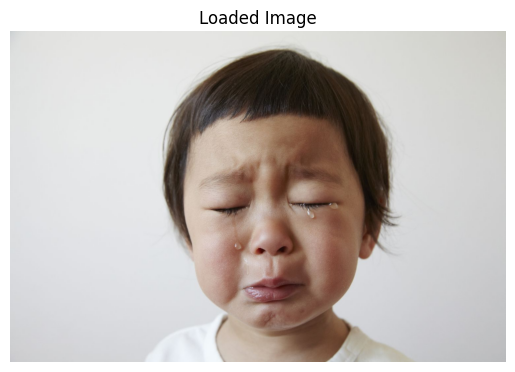

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.



Crying child


In [11]:
import cv2
from matplotlib import pyplot as plt
#Define the local image file path and prompt
image_file = "/home/shamsher/Desktop/Websocket_data/test3/weeping.jpg"  # Replace with the path to your image
prompt = "describe image"#"what are the object where cat are seat?"

# Load the image using OpenCV
raw_image = cv2.imread(image_file)
raw_image_rgb = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)

# Display the image using Matplotlib
plt.imshow(raw_image_rgb)
plt.axis("off")  # Hide axes
plt.title("Loaded Image")
plt.show()
if raw_image is None:
    raise FileNotFoundError(f"Image file not found at {image_file}")

# Convert the image to RGB (OpenCV loads images in BGR format)
raw_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)

# Convert OpenCV image to PIL for processing
pil_image = Image.fromarray(raw_image)

# Process the image and generate output
inputs = processor(pil_image, prompt, return_tensors="pt")
output = model.generate(**inputs, max_new_tokens=20)
result = processor.decode(output[0], skip_special_tokens=True)[len(prompt):]

# Print the result
print(result)



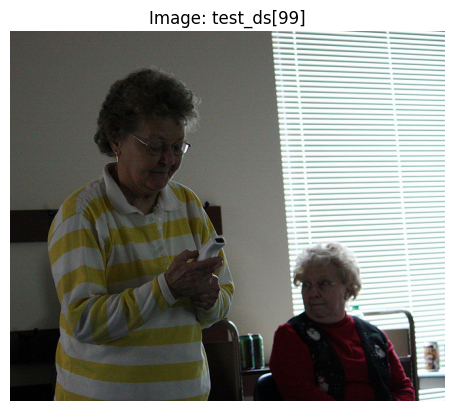

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x544 at 0x7F32554D4BB0>

woman holding phone and looking at it. woman sitting in chair.
Inference time: 10.296843 seconds


In [12]:
import time
start_time = time.time() 
prompt = "Describe the image."
image_file = test_ds[99]["image"]

# Convert to a PIL image if needed
if not isinstance(image_file, Image.Image):
    image_file = Image.open(image_file)

# Display the image using Matplotlib
plt.imshow(image_file)
plt.axis("off")  # Hide axes
plt.title("Image: test_ds[99]")
plt.show()
print(image_file)
inputs = processor(image_file, prompt, return_tensors="pt")
output = model.generate(**inputs, max_new_tokens=20)
print(processor.decode(output[0], skip_special_tokens=True)[len(prompt):])
end_time = time.time()
inference_time = end_time - start_time
print(f"Inference time: {inference_time:.6f} seconds")

In [43]:
pip uninstall opencv-python


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Found existing installation: opencv-python 4.10.0.84
Uninstalling opencv-python-4.10.0.84:
  Would remove:
    /home/shamsher/miniconda3/envs/ocr_test/lib/python3.9/site-packages/cv2/*
    /home/shamsher/miniconda3/envs/ocr_test/lib/python3.9/site-packages/opencv_python-4.10.0.84.dist-info/*
    /home/shamsher/miniconda3/envs/ocr_test/lib/python3.9/site-packages/opencv_python.libs/libQt5Core-e6d3f451.so.5.15.13
    /home/shamsher/miniconda3/envs/ocr_test/lib/python3.9/site-packages/opencv_python.libs/libQt5Gui-5dea4132.so.5.15.13
    /home/shamsher/miniconda3/envs/ocr_test/lib/python3.9/site-packages/opencv_python.libs/libQt5Test-d435aae7.so.5.15.13
    /home/shamsher/miniconda3/envs/ocr_test/lib/python3.9/site-packages/opencv_python.libs/libQt5Widgets-e392eaf8.so.5.15.13
    /home/shamsher/miniconda3/envs/ocr_test/lib/python3.9/site-packages/opencv_python.libs/libQt5XcbQpa-3bf8a55a.so.5.15.13
    /home/shamsher/miniconda3/envs/ocr_test/lib/python3.9/site-packages/opencv_python.libs/li

In [52]:
pip install libgtk2.0-dev pkg-config


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
ERROR: Could not find a version that satisfies the requirement libgtk2.0-dev (from versions: none)
ERROR: No matching distribution found for libgtk2.0-dev
Note: you may need to restart the kernel to use updated packages.


You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   0


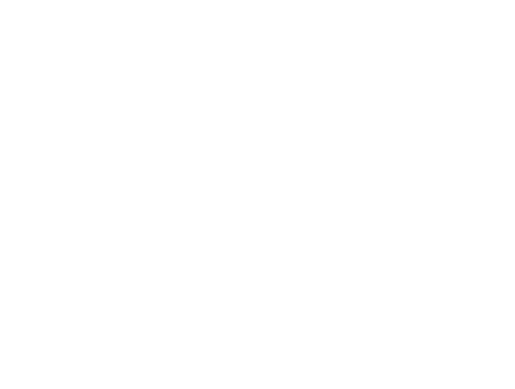

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   1


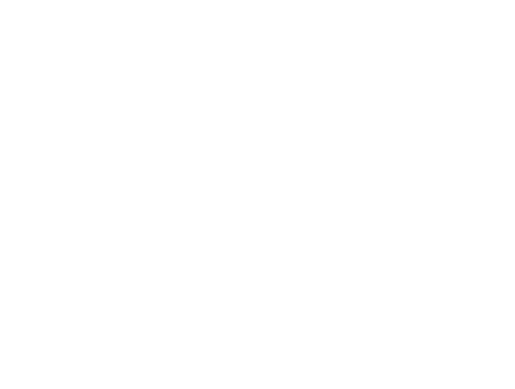

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   2


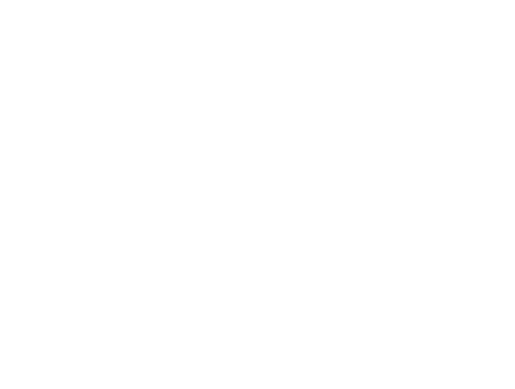

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   3


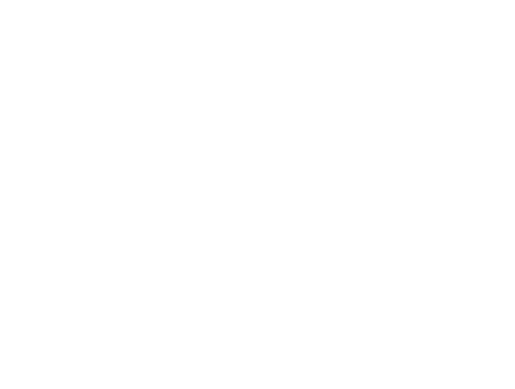

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   4


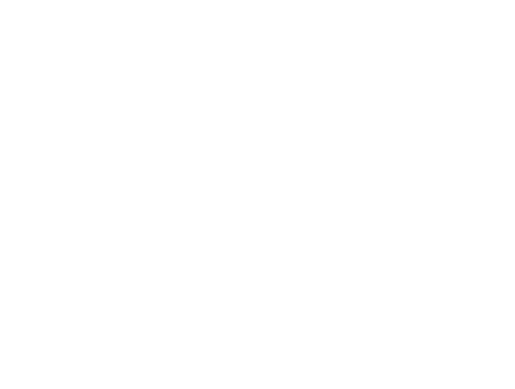

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   5


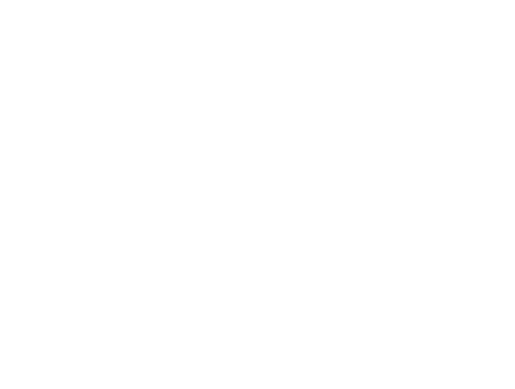

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   6


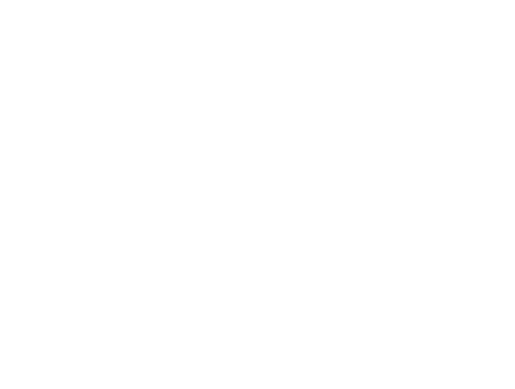

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   7


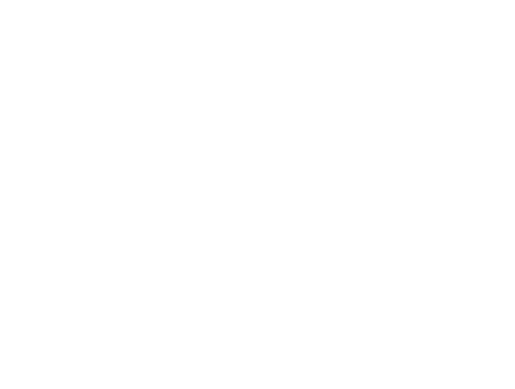

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   8


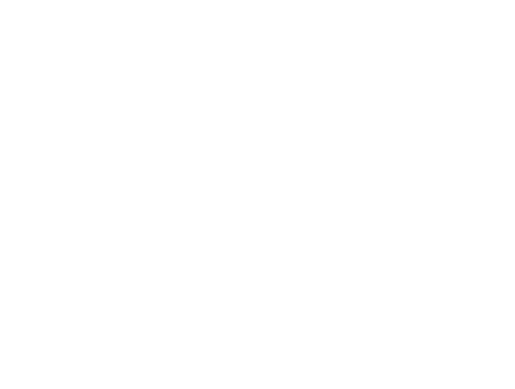

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   9


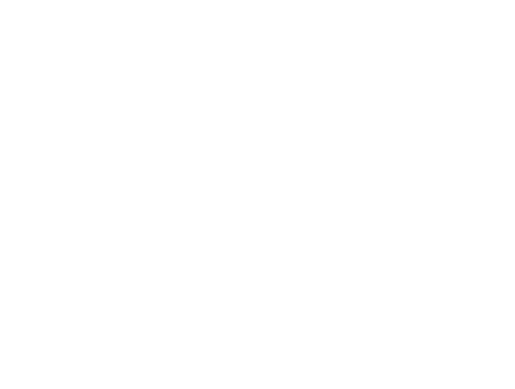

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   10


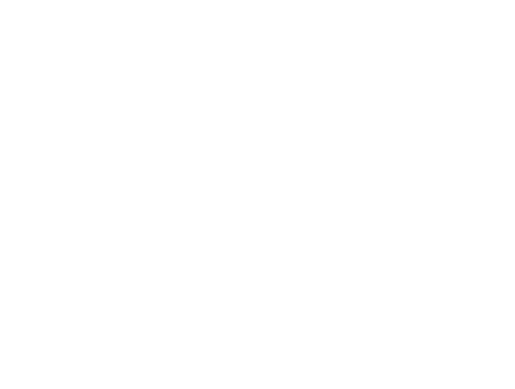

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   11


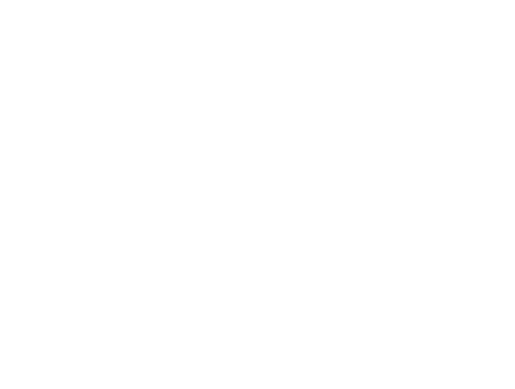

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   12


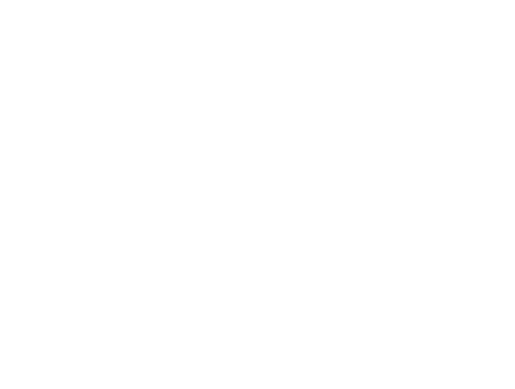

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   13


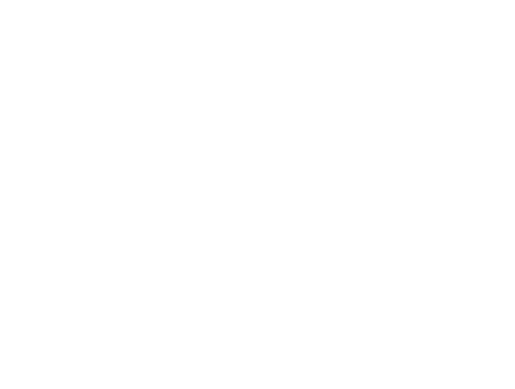

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   14


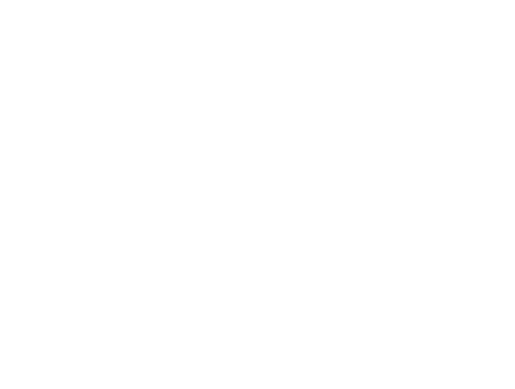

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   15


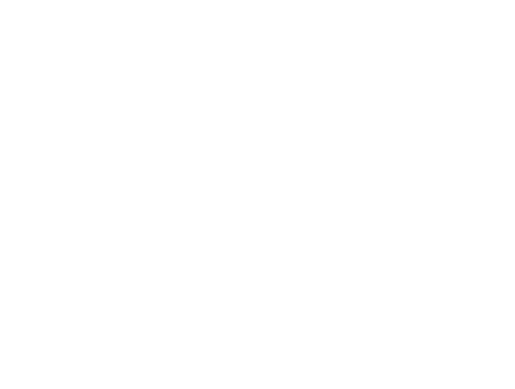

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   16


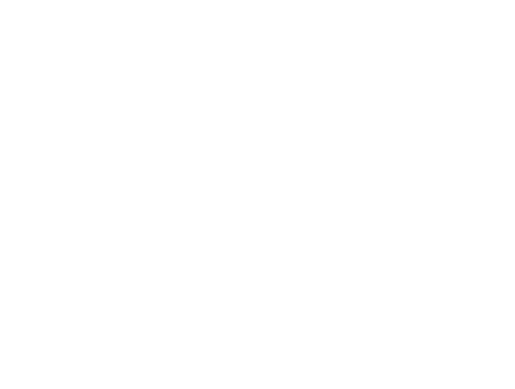

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   17


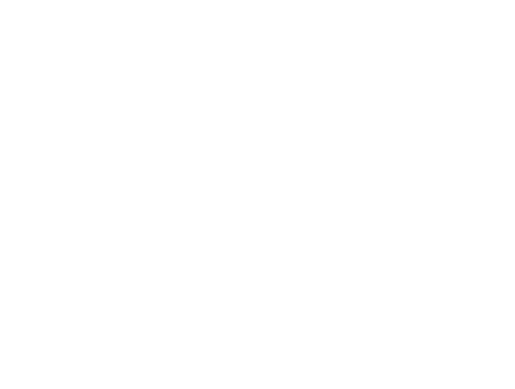

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   18


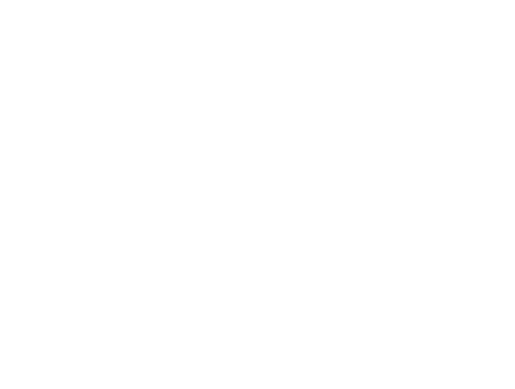

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   19


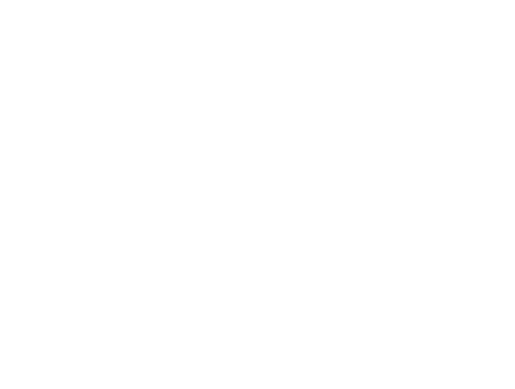

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   20


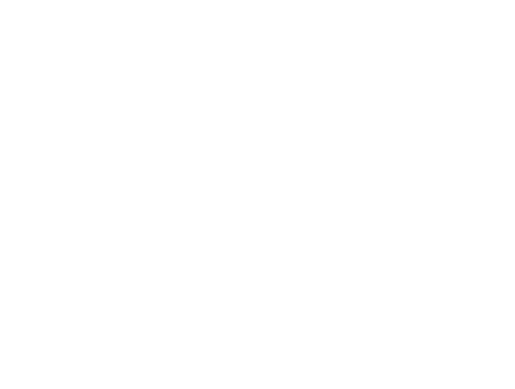

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   21


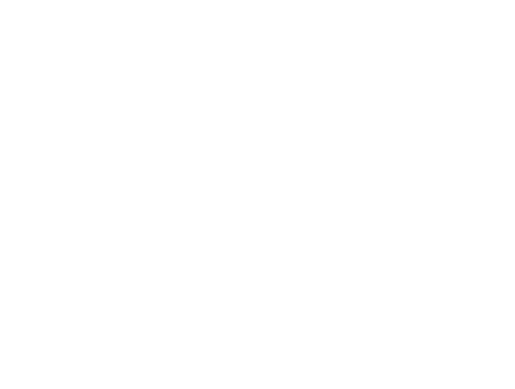

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   22


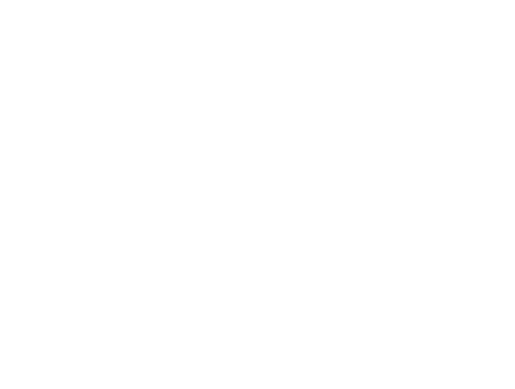

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   23


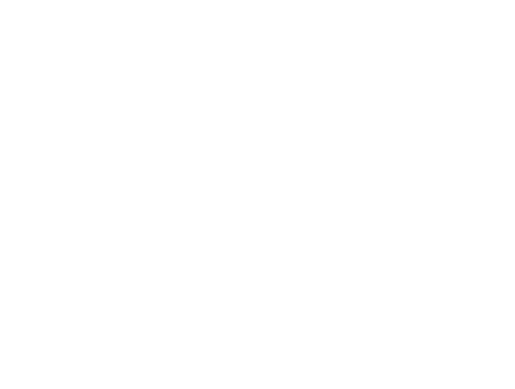

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   24


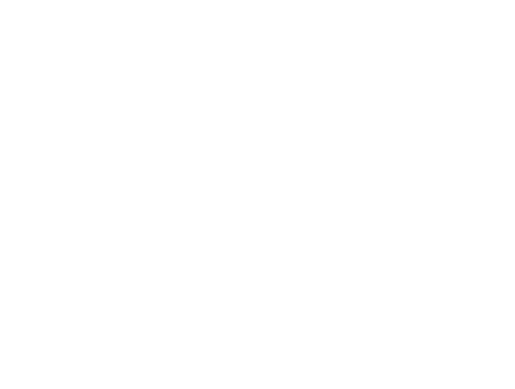

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   25


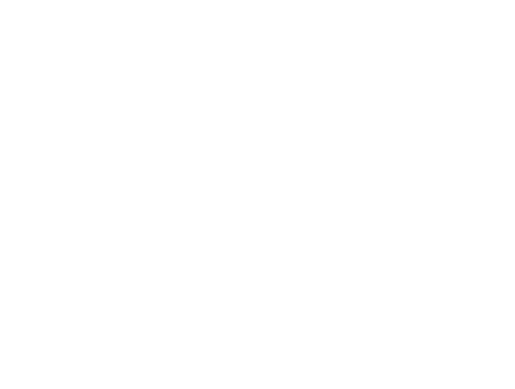

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   26


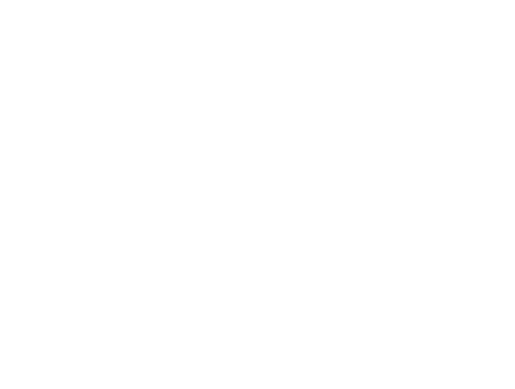

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   27


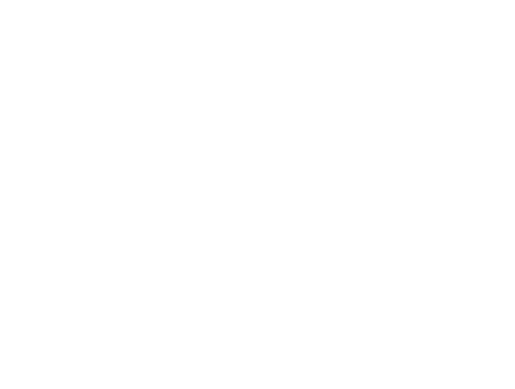

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   28


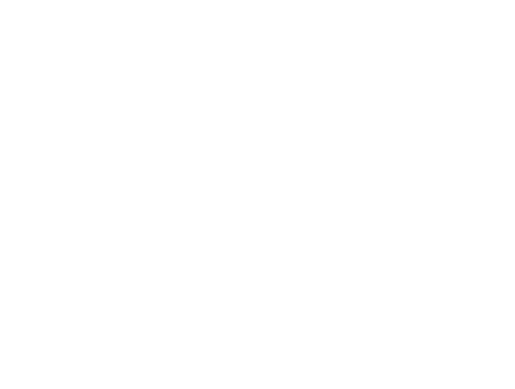

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   29


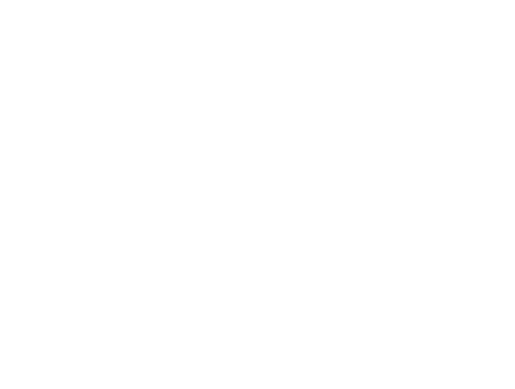

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   30


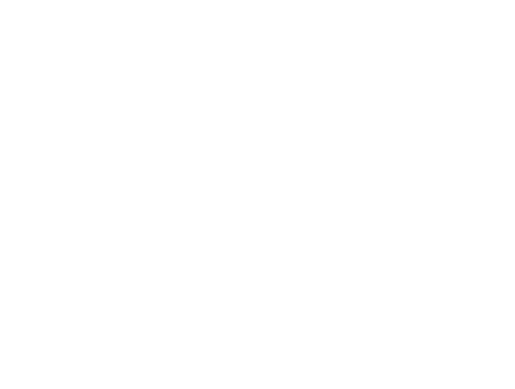

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   31


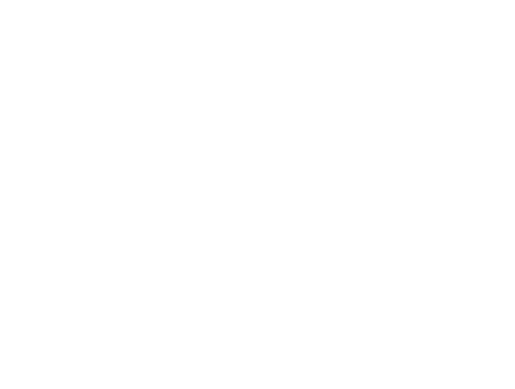

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   32


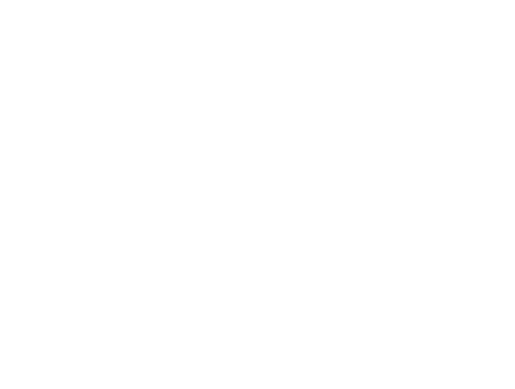

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   33


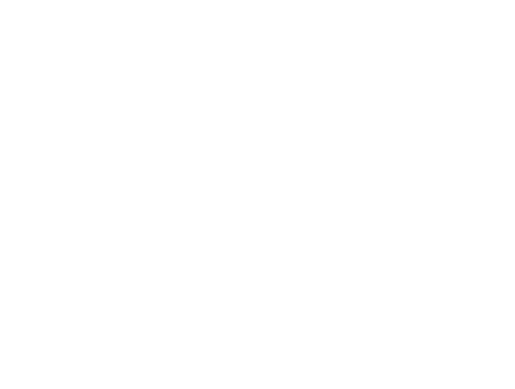

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   34


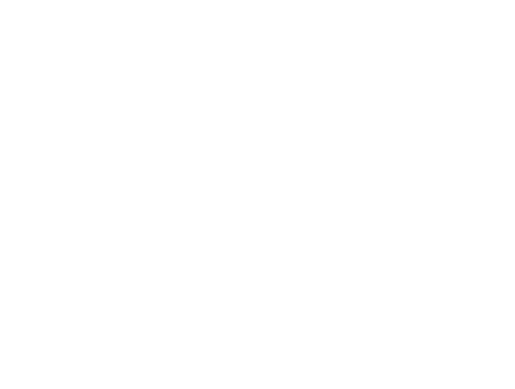

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   35


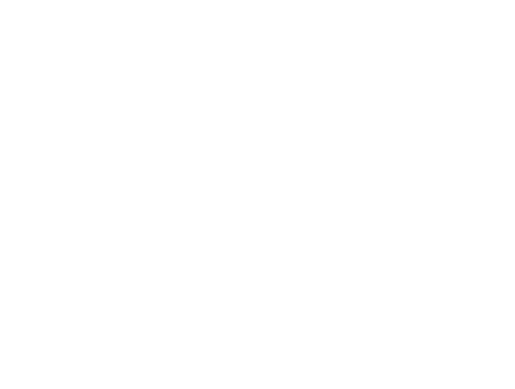

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   36


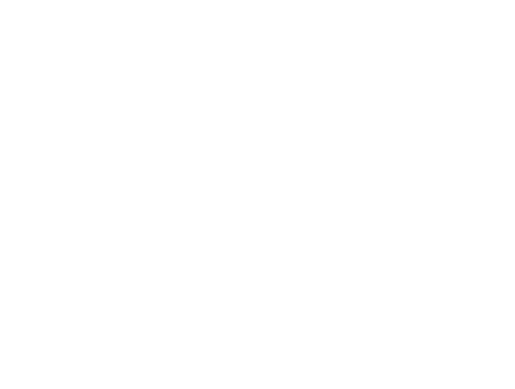

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   37


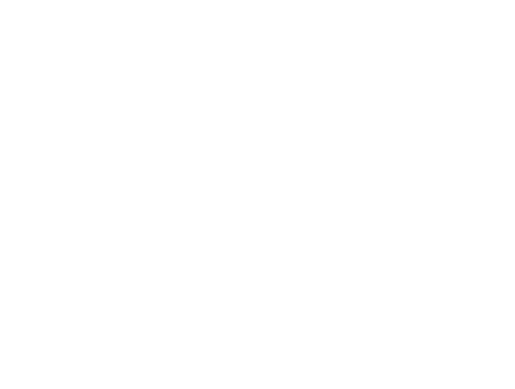

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   38


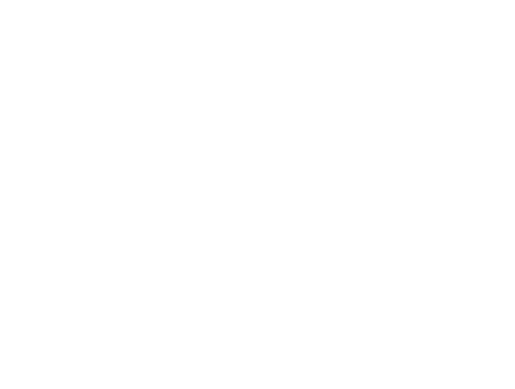

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   39


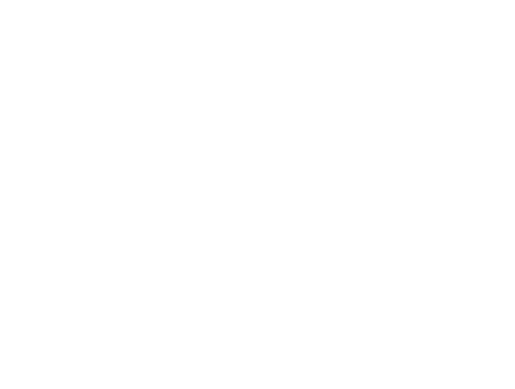

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   40


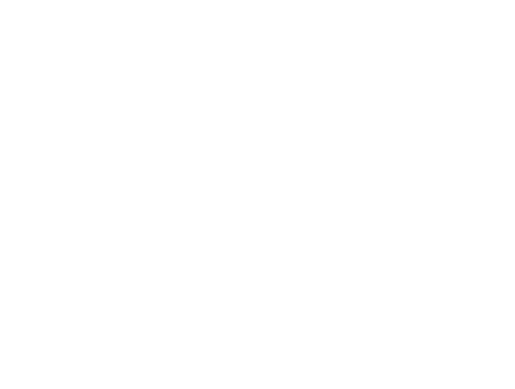

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   41


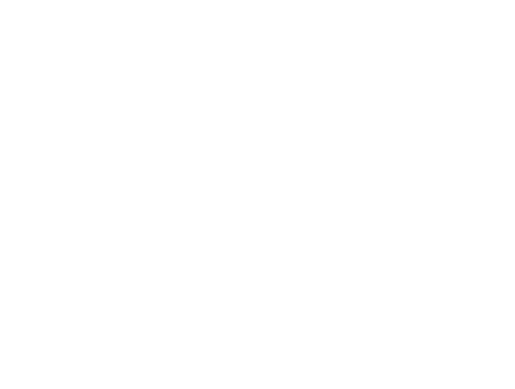

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   42


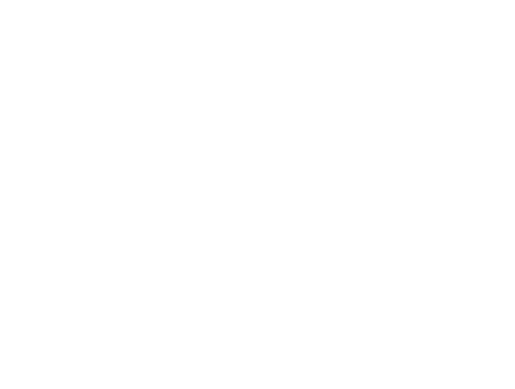

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   43


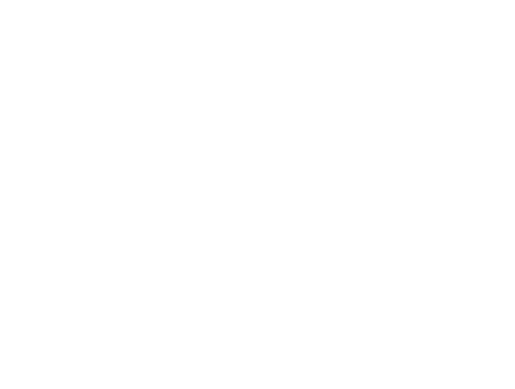

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   44


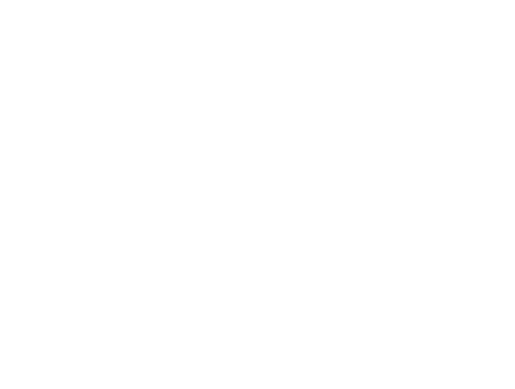

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   45


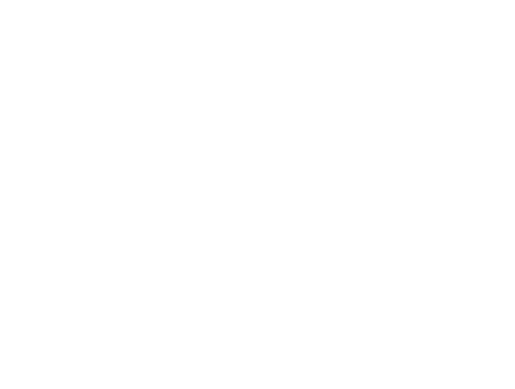

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   46


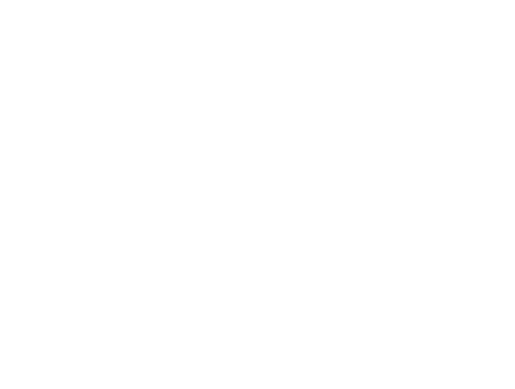

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   47


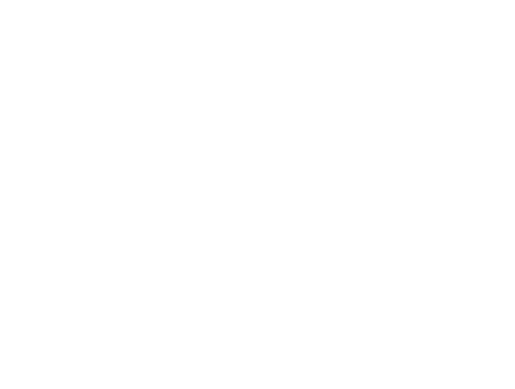

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   48


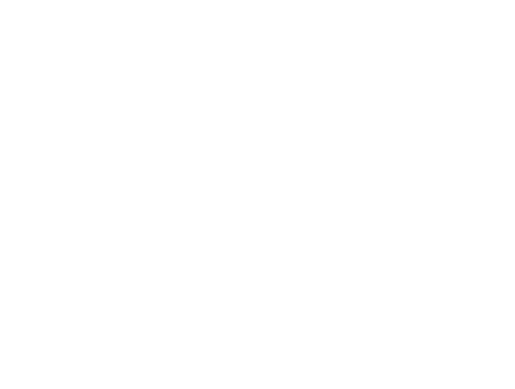

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   49


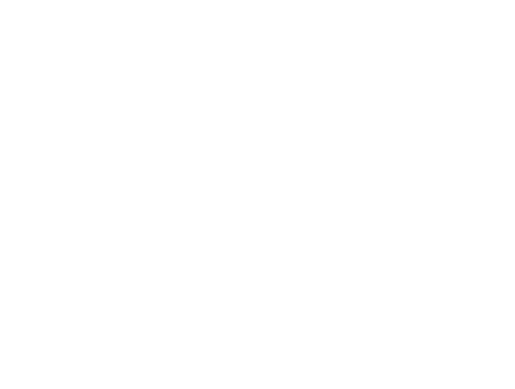

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   50


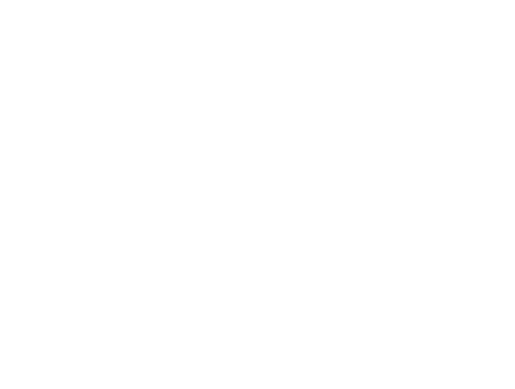

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   51


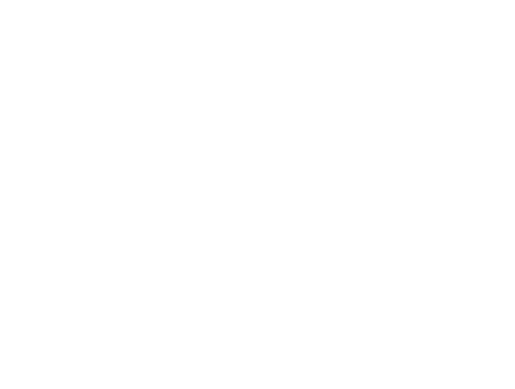

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   52


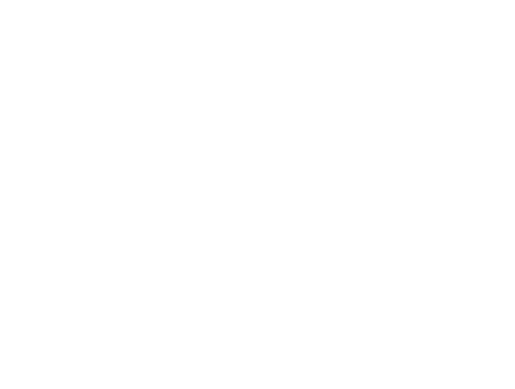

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   53


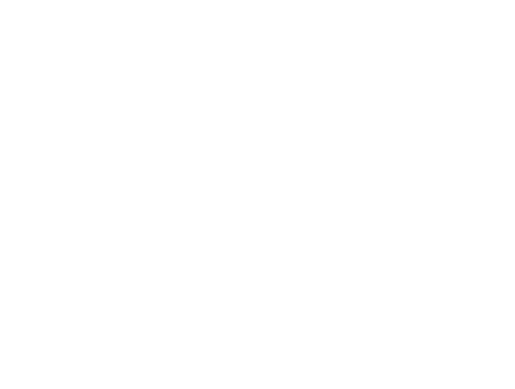

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   54


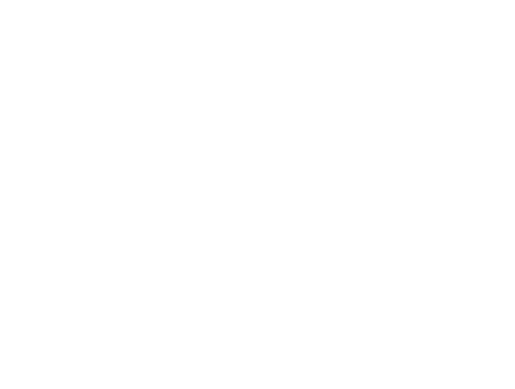

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   55


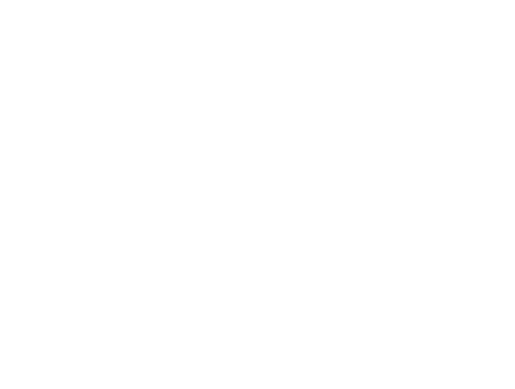

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   56


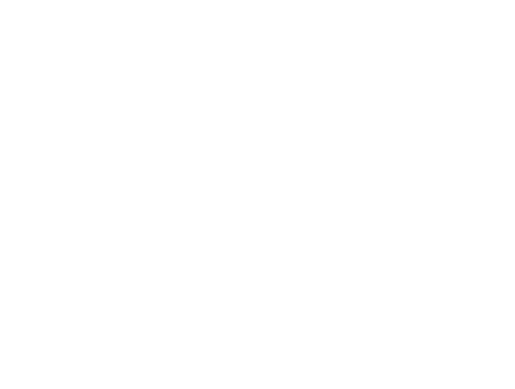

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   57


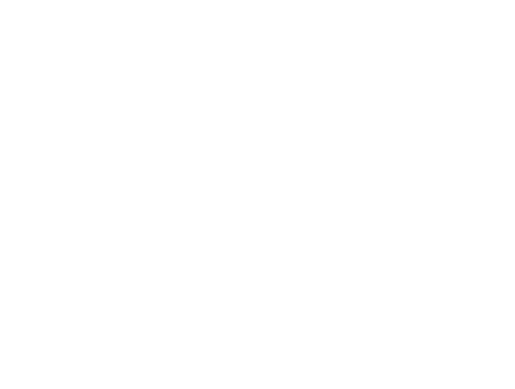

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   58


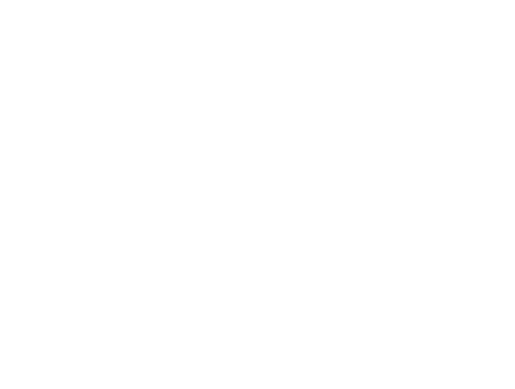

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   59


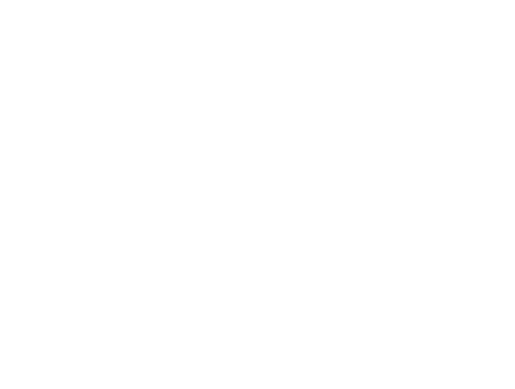

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   60


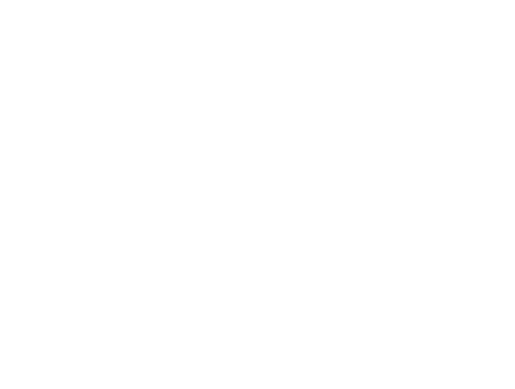

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   61


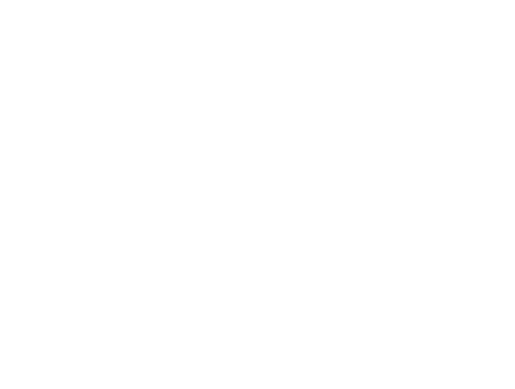

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   62


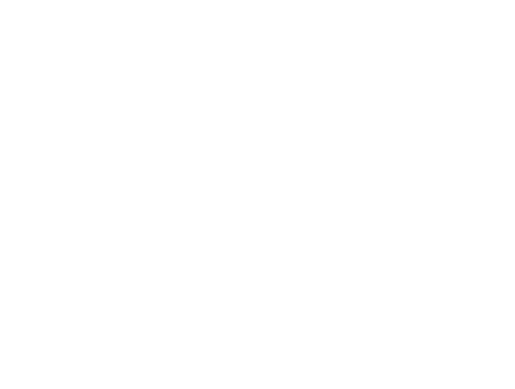

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   63


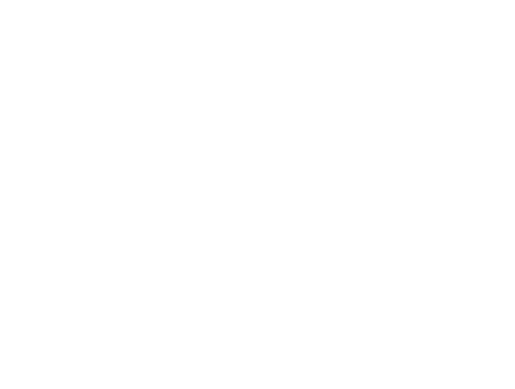

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   64


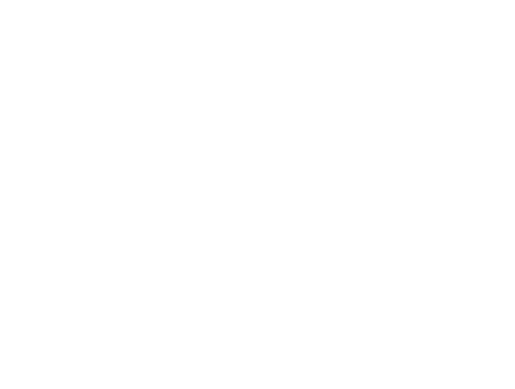

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   65


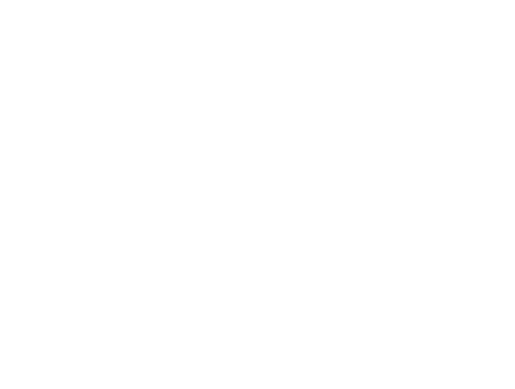

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   66


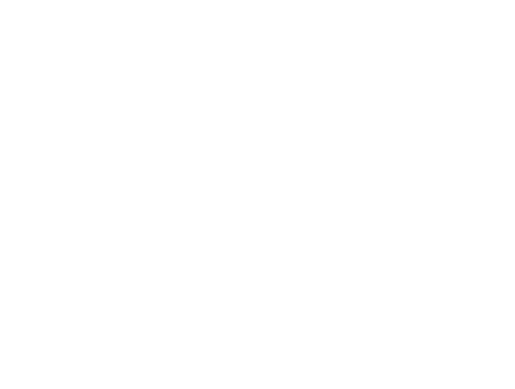

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   67


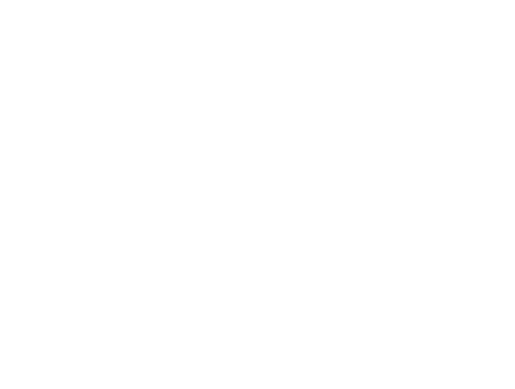

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   68


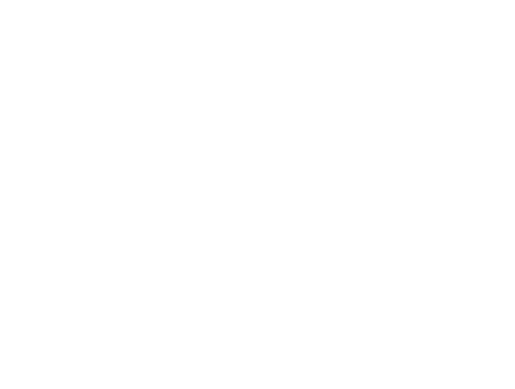

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   69


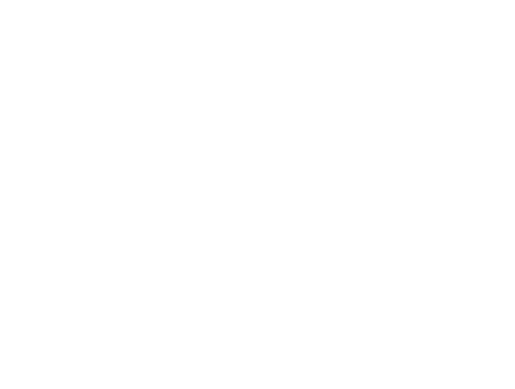

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   70


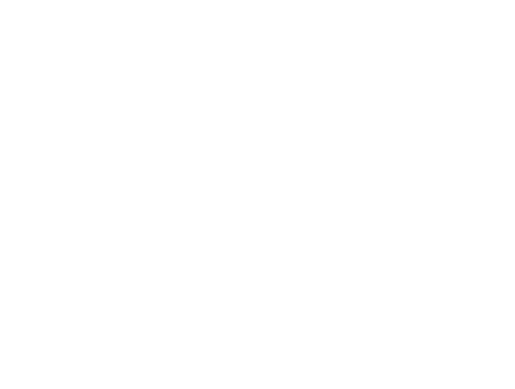

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   71


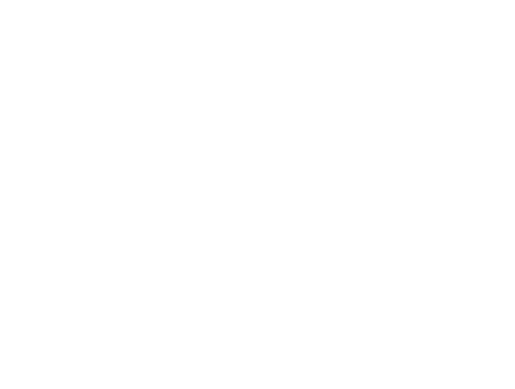

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   72


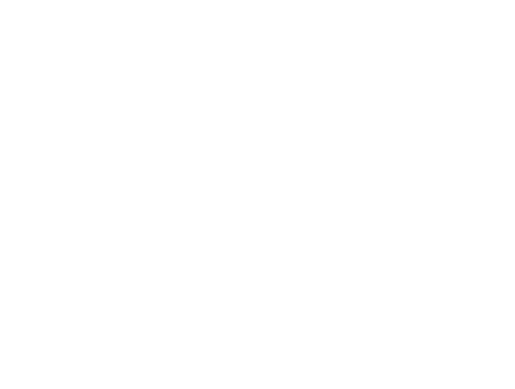

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   73


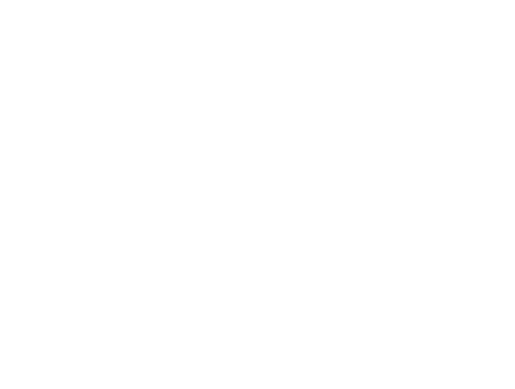

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   74


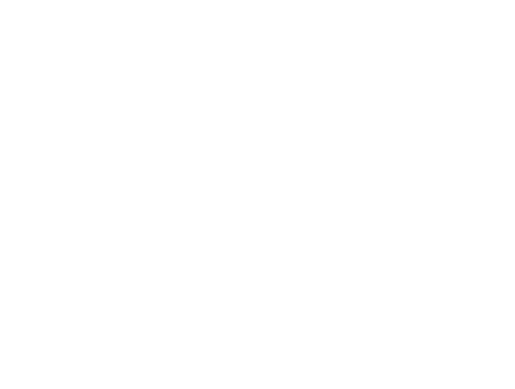

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   75


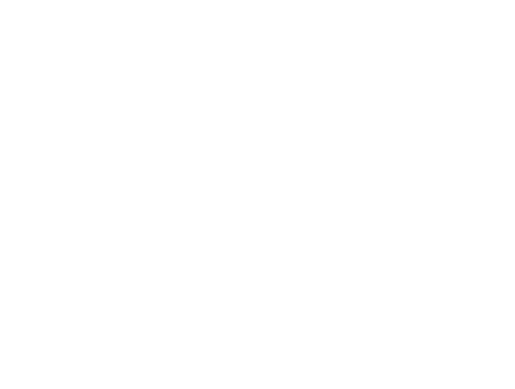

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   76


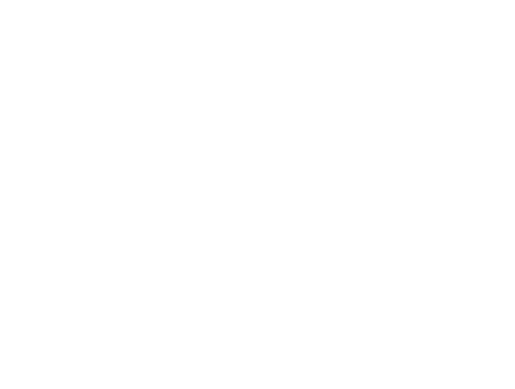

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   77


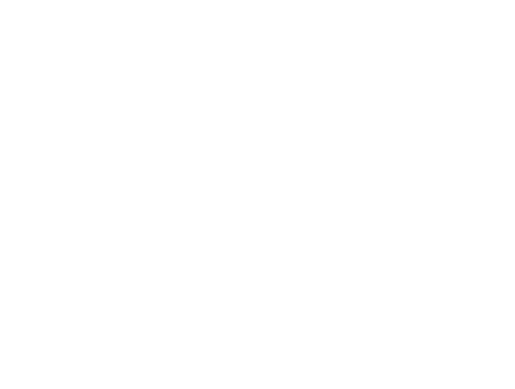

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   78


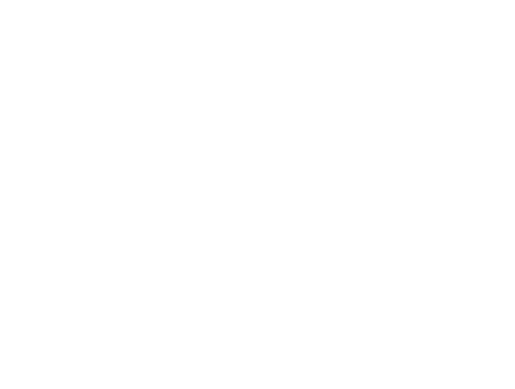

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   79


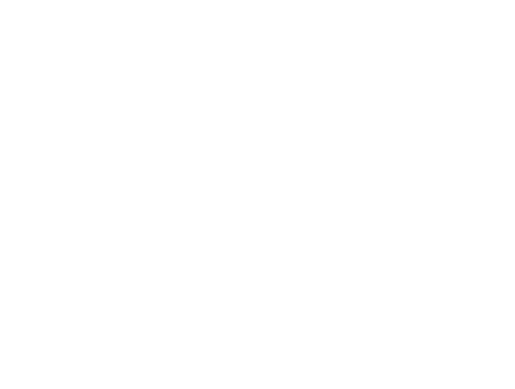

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   80


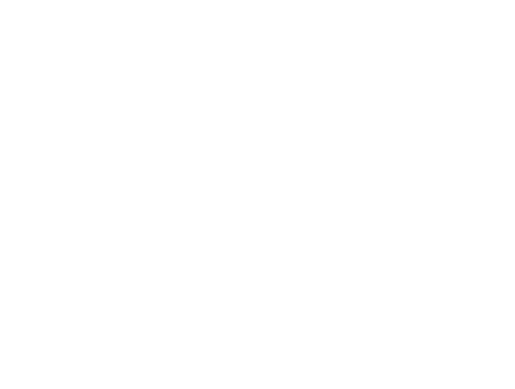

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   81


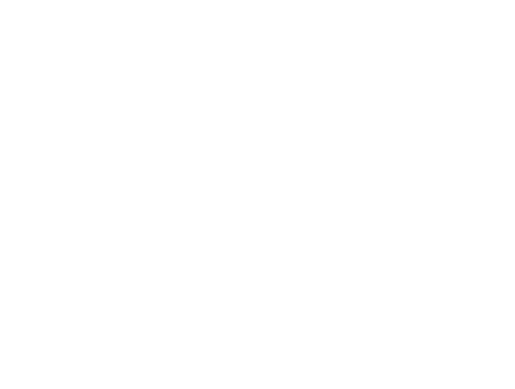

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   82


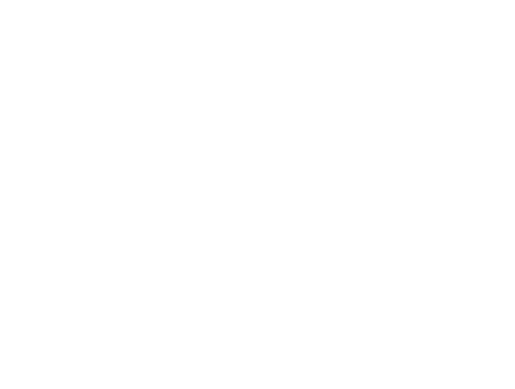

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   83


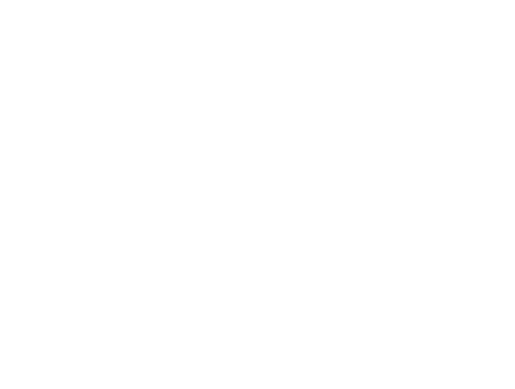

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   84


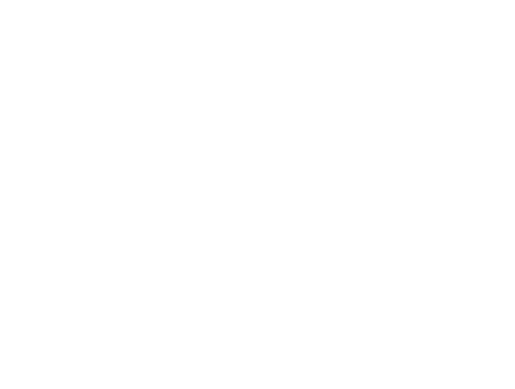

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   85


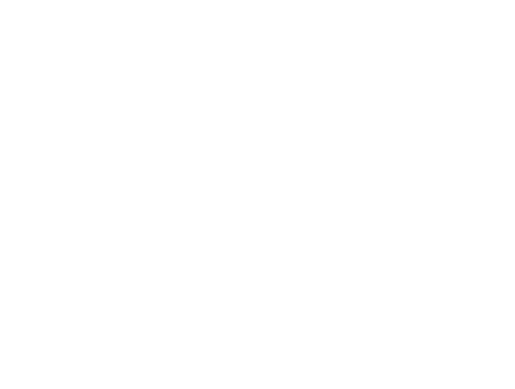

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   86


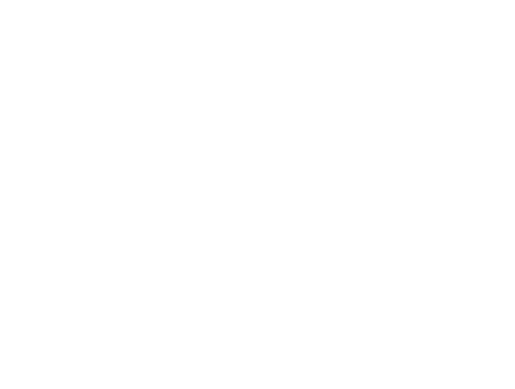

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   87


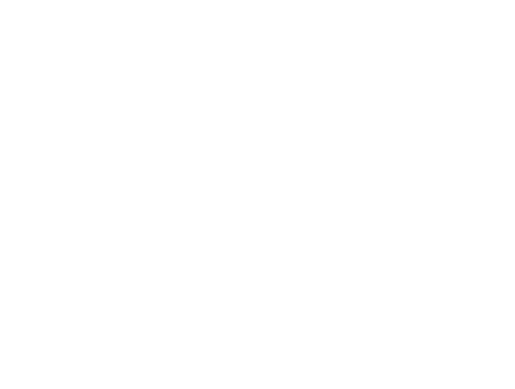

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   88


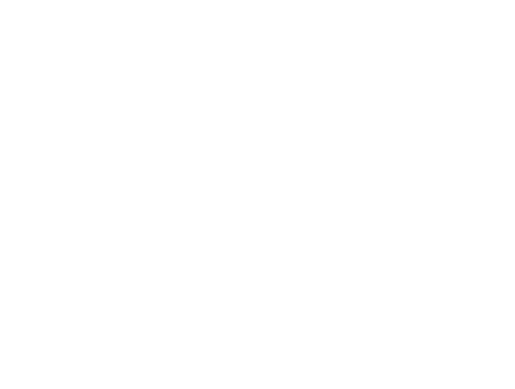

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   89


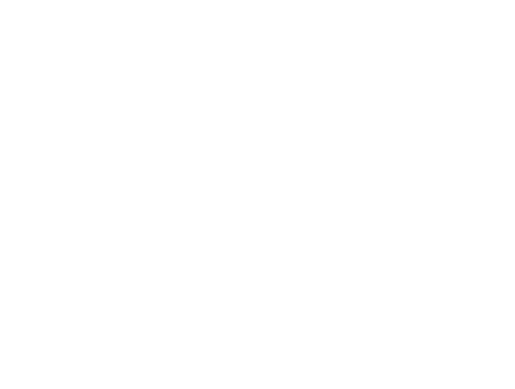

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   90


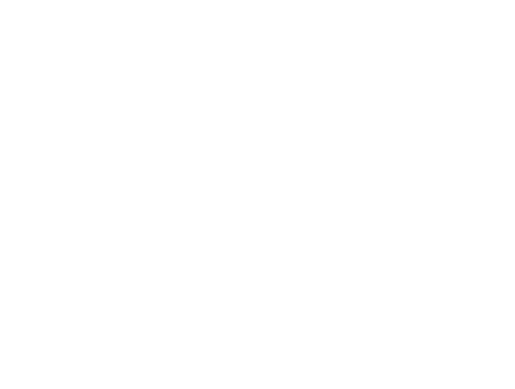

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   91


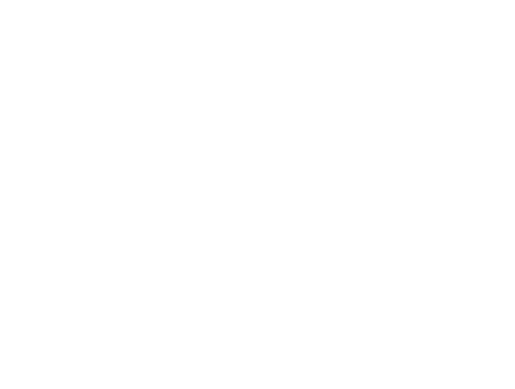

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   92


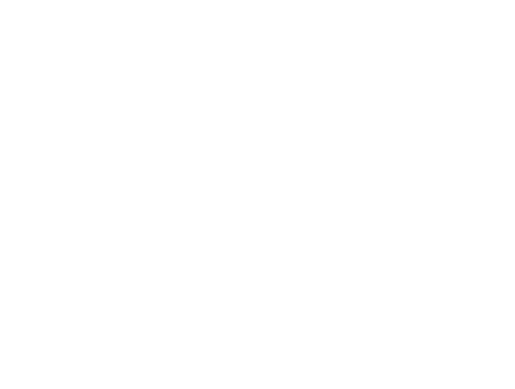

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   93


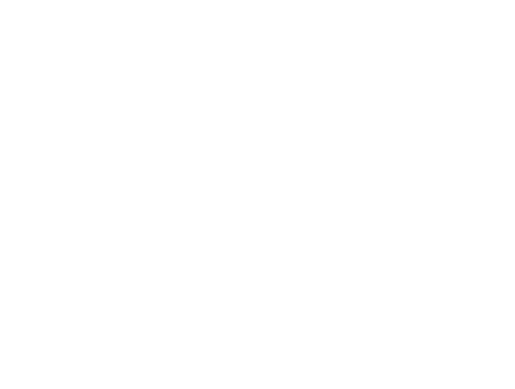

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   94


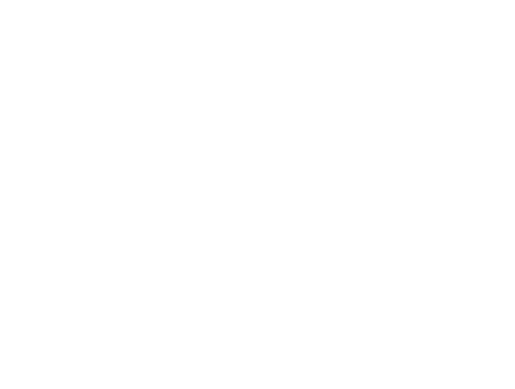

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   95


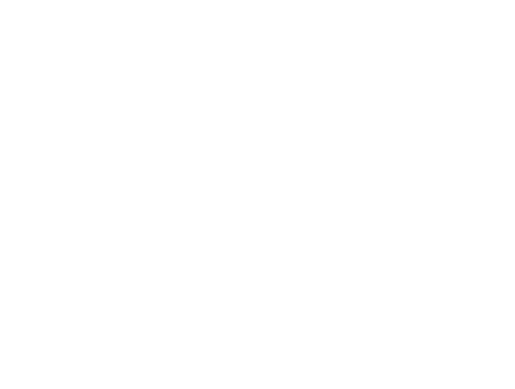

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   96


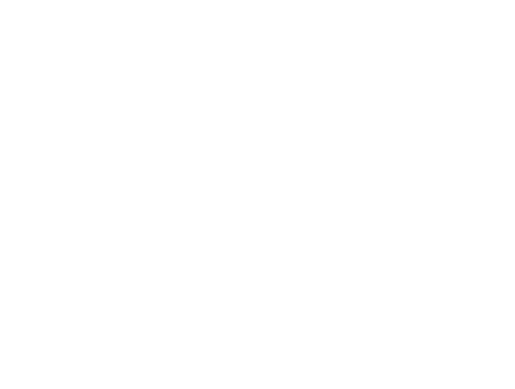

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   97


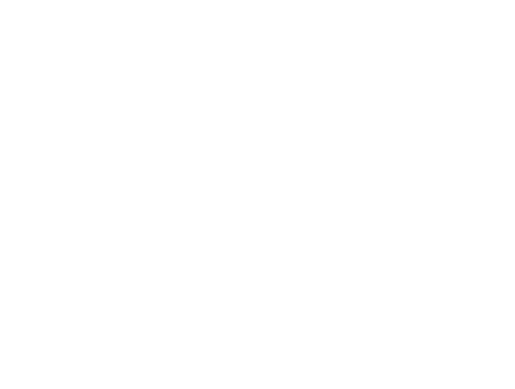

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   98


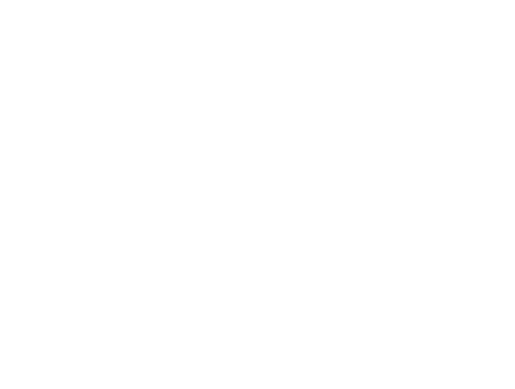

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   99


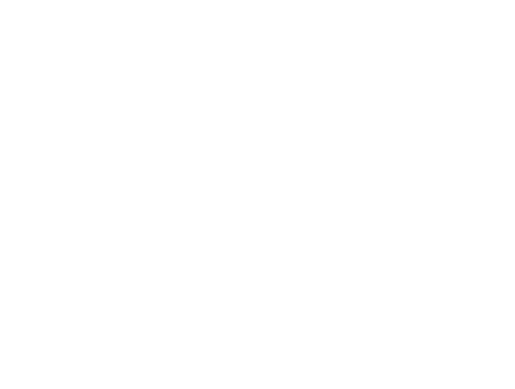

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   100


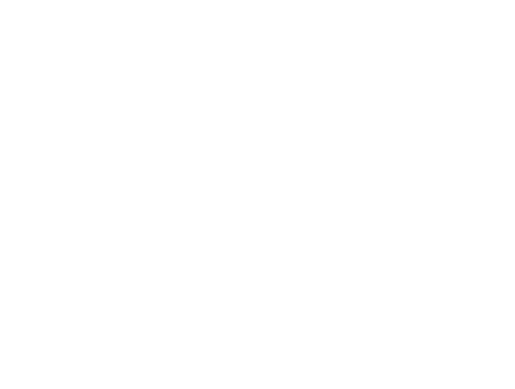

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   101


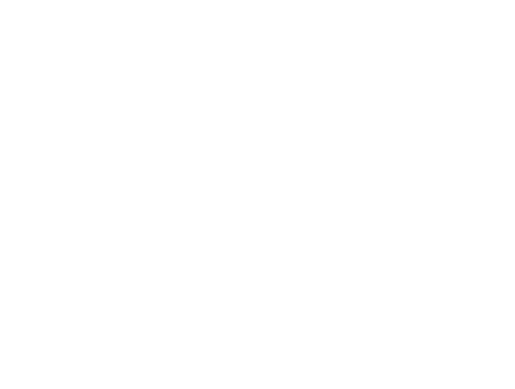

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   102


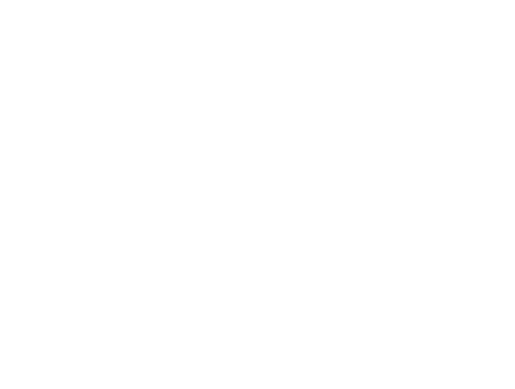

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   103


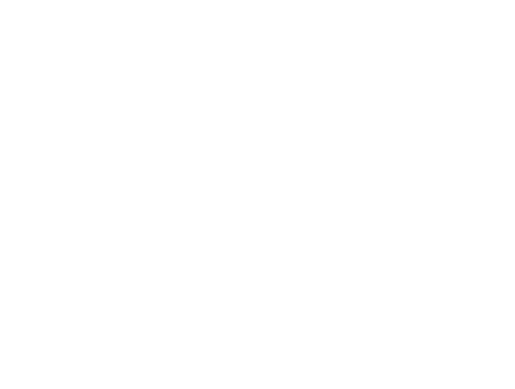

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   104


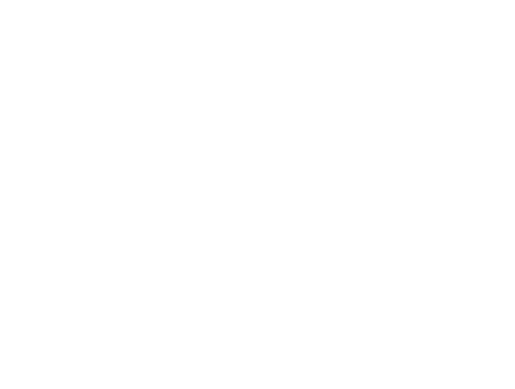

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   105


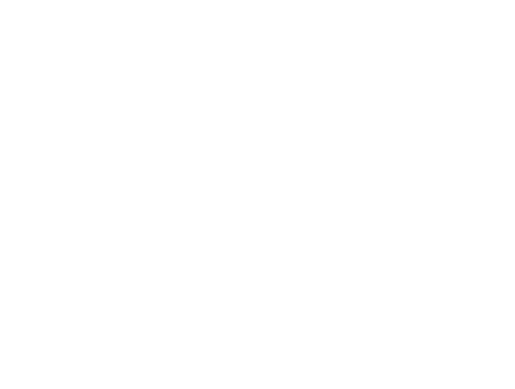

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   106


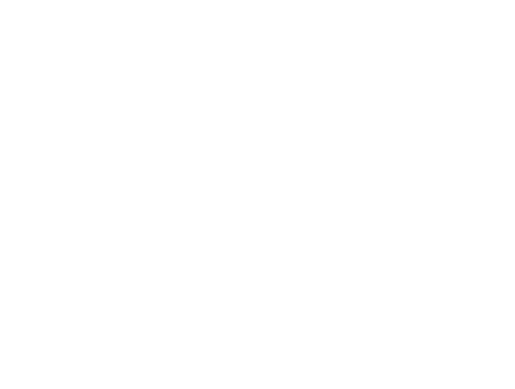

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   107


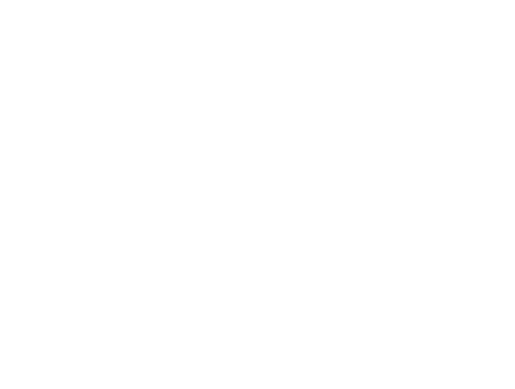

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   108


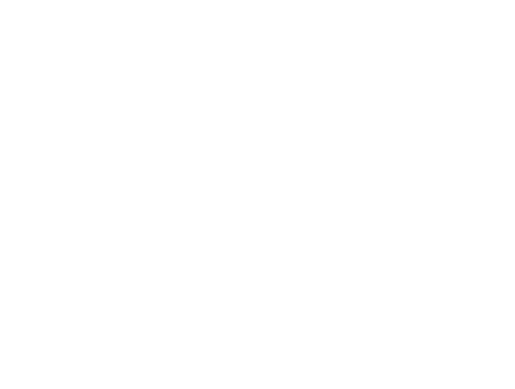

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   109


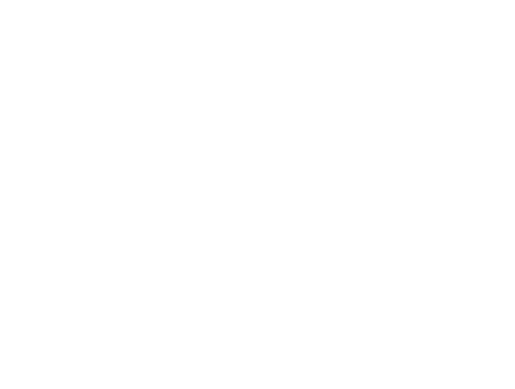

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   110


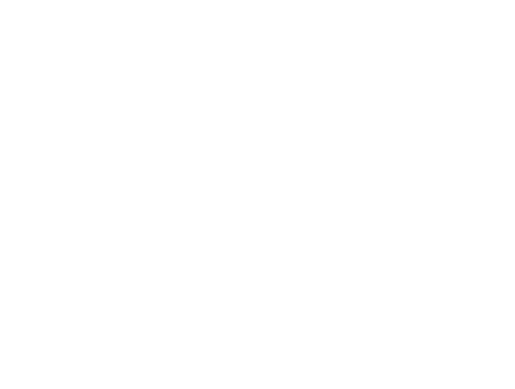

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   111


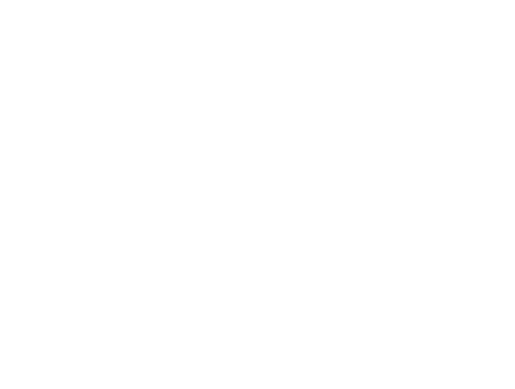

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   112


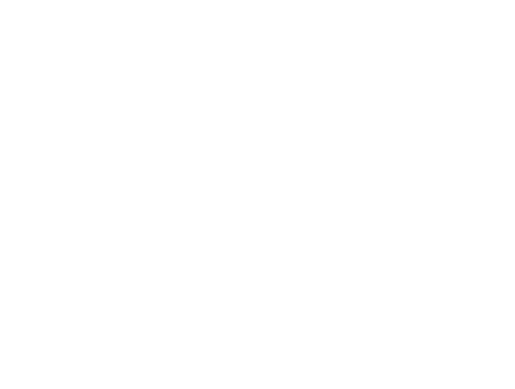

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   113


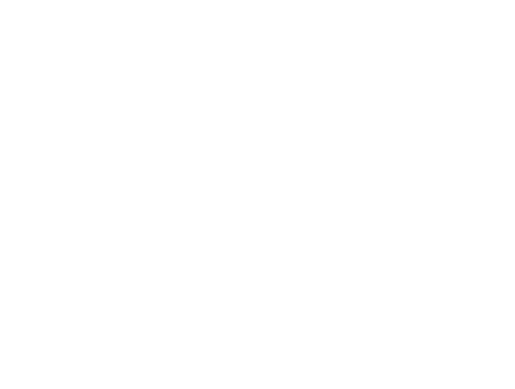

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   114


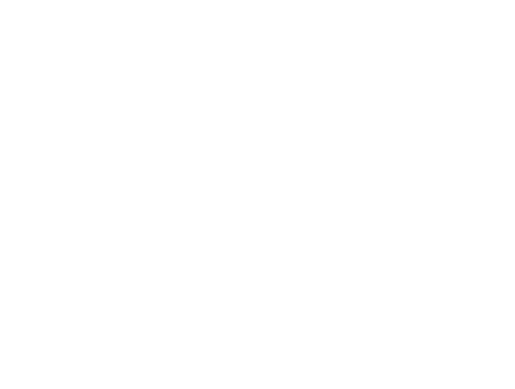

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   115


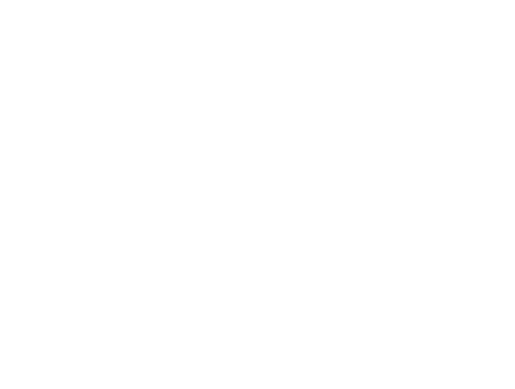

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   116


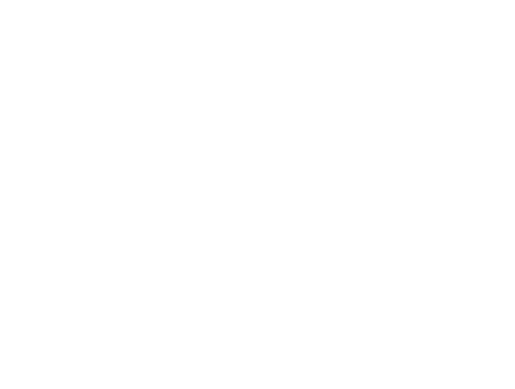

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   117


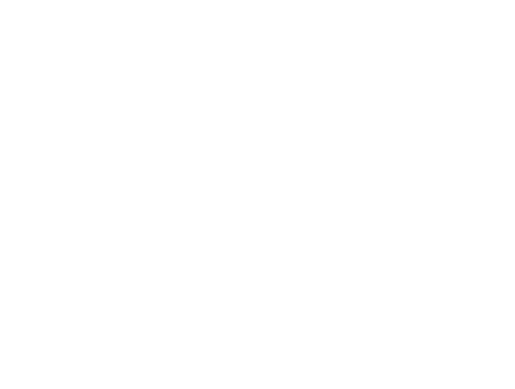

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   118


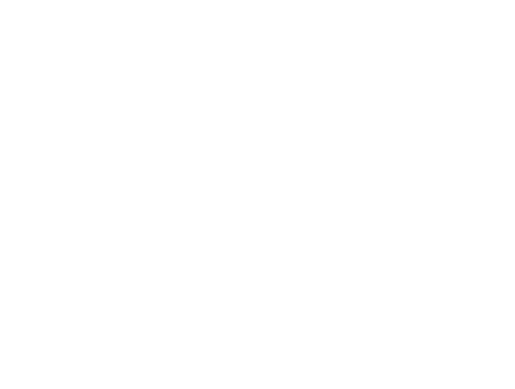

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   119


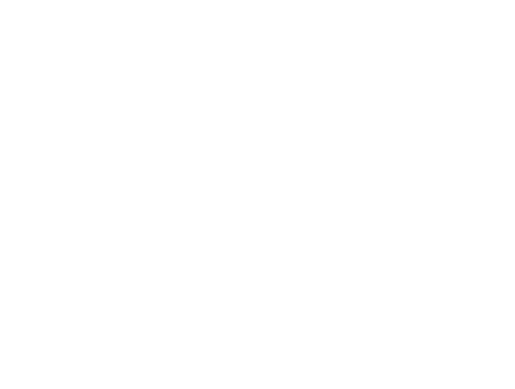

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   120


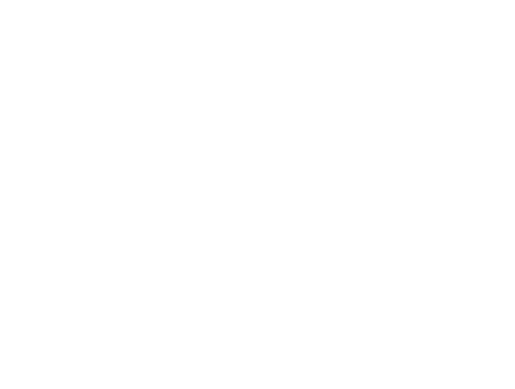

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   121


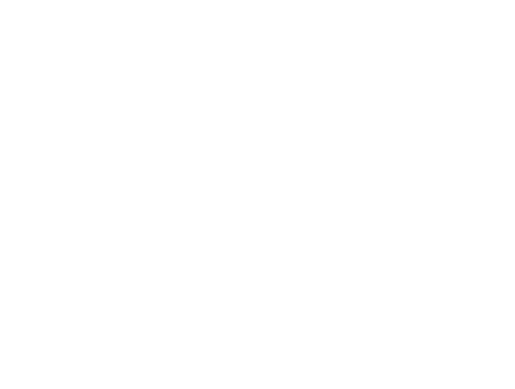

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   122


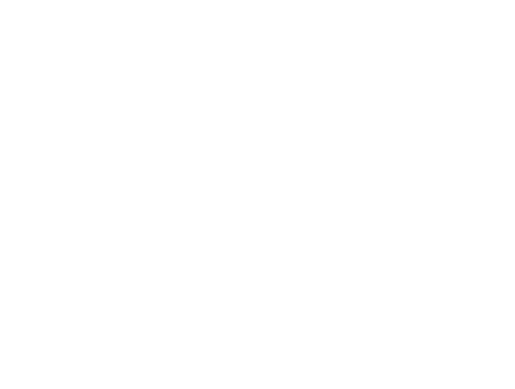

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   123


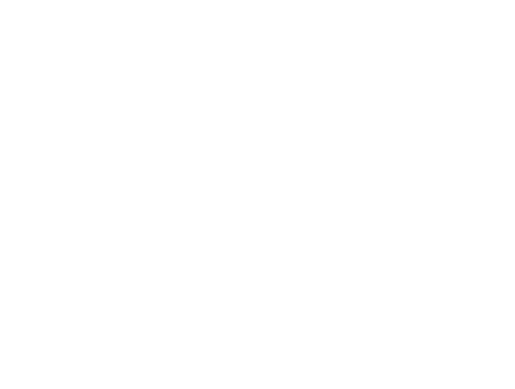

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   124


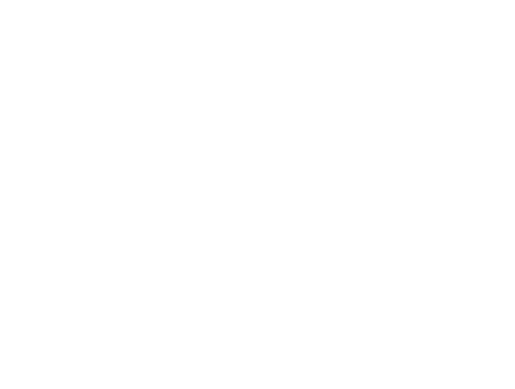

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   125


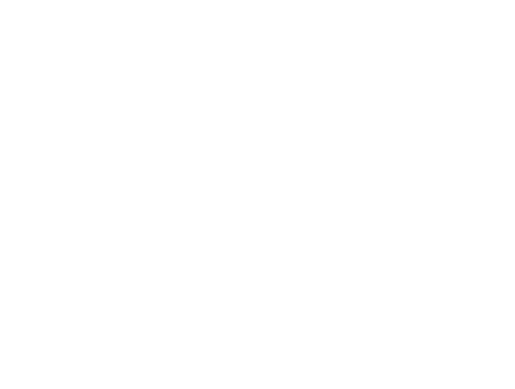

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   126


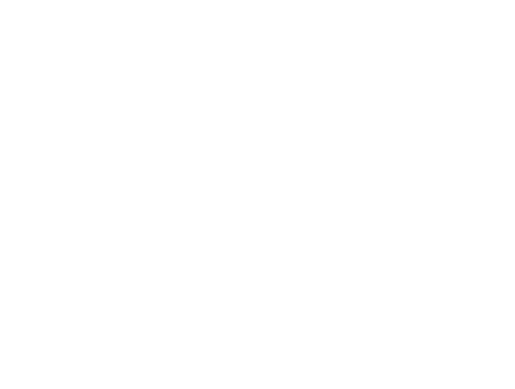

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   127


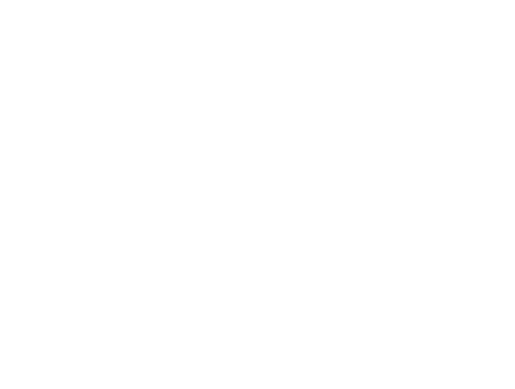

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   128


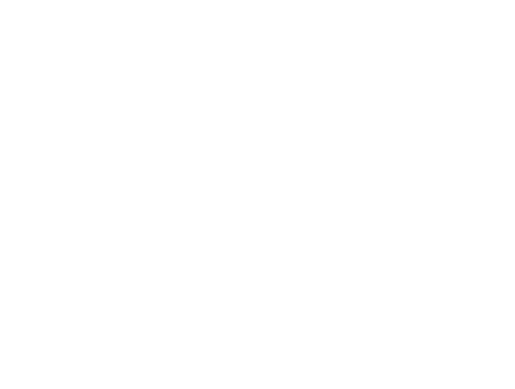

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   129


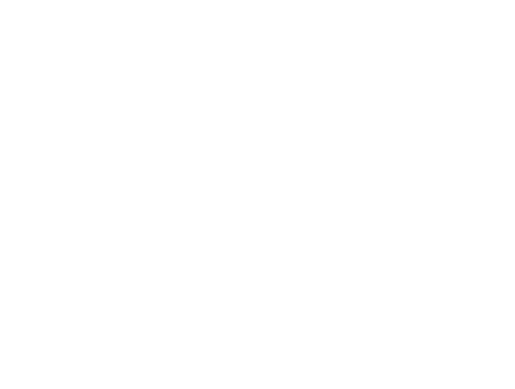

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   130


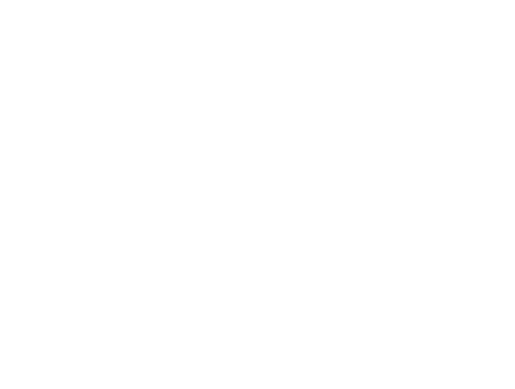

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   131


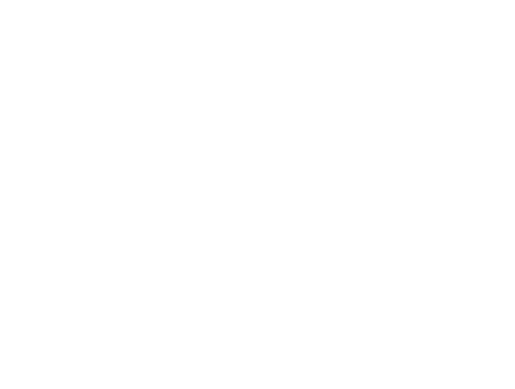

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   132


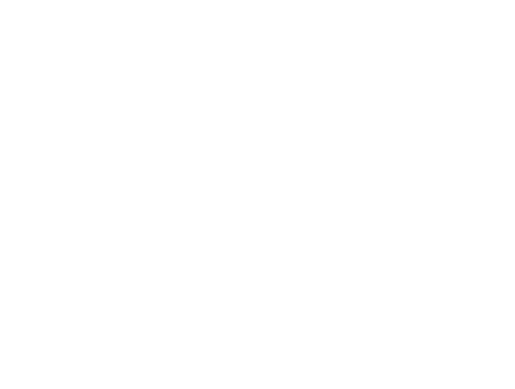

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   133


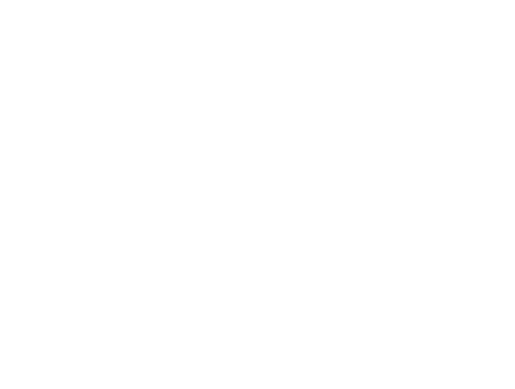

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   134


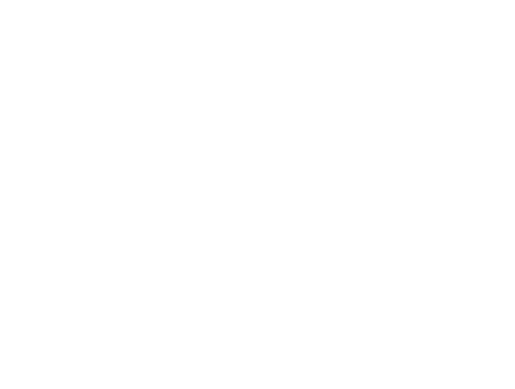

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   135


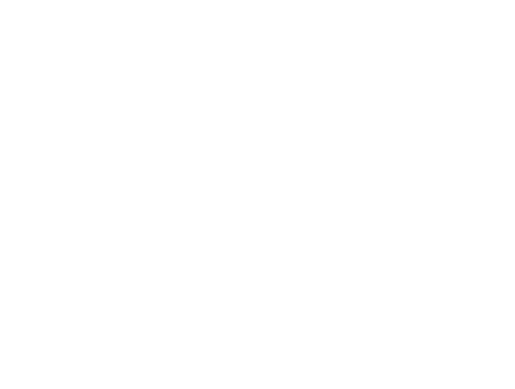

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   136


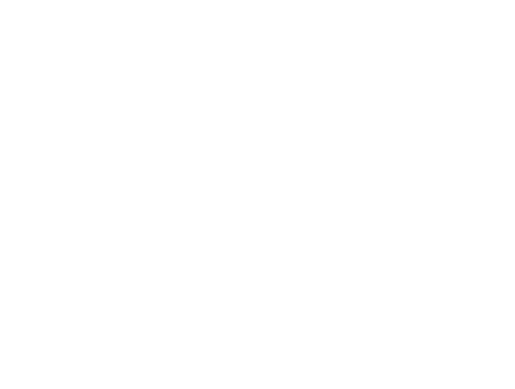

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   137


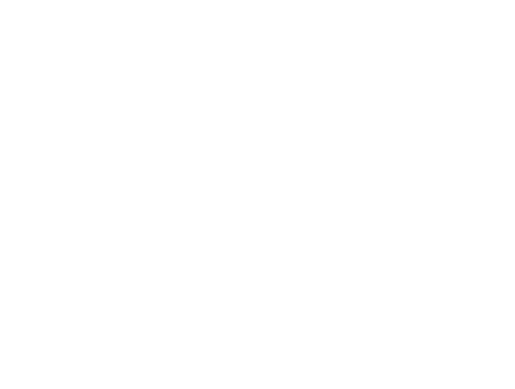

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   138


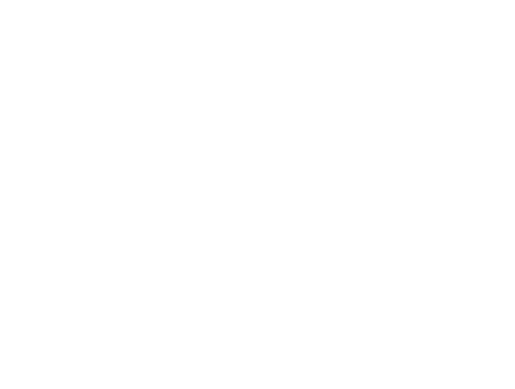

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   139


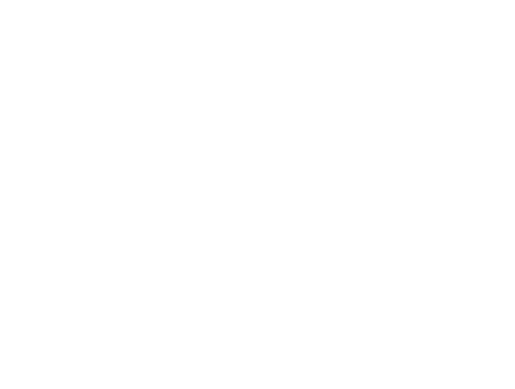

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   140


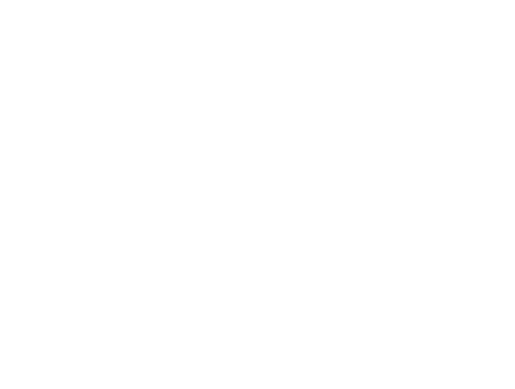

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   141


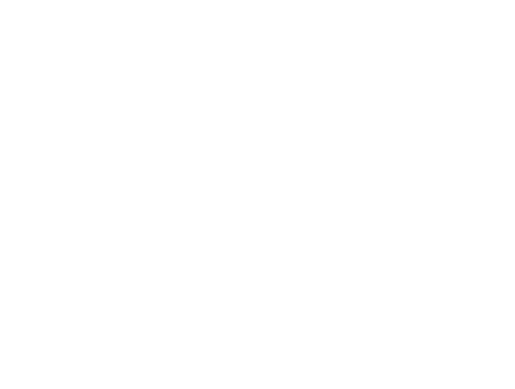

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   142


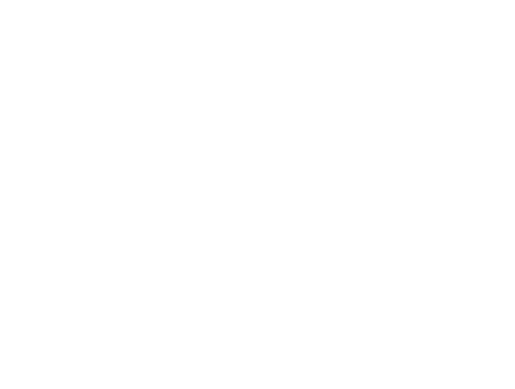

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   143


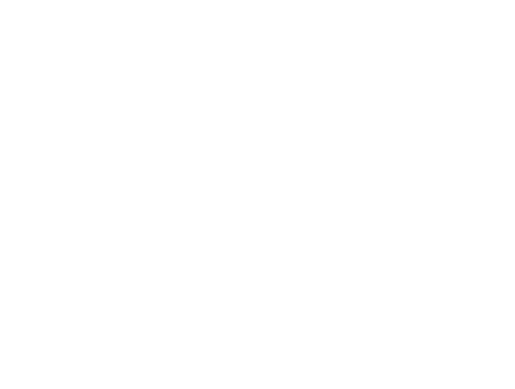

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   144


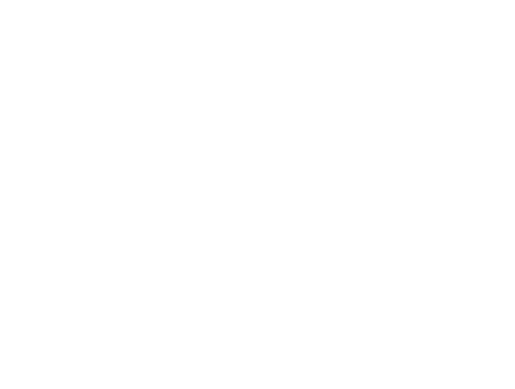

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   145


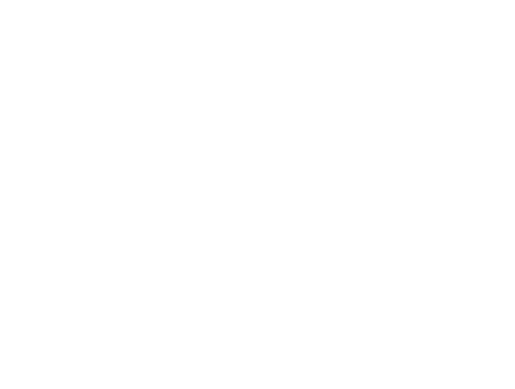

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   146


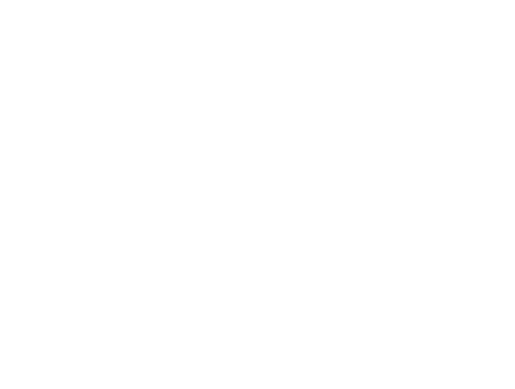

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   147


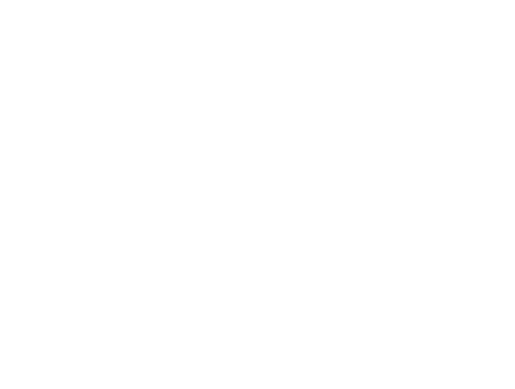

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   148


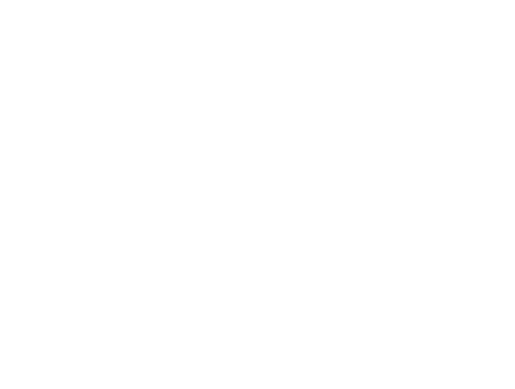

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   149


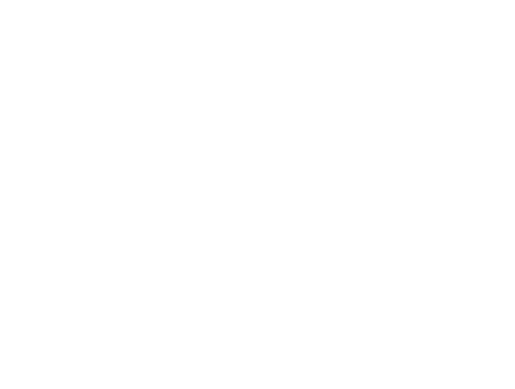

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   150


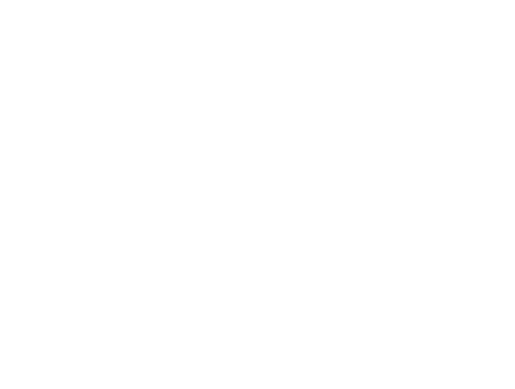

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   151


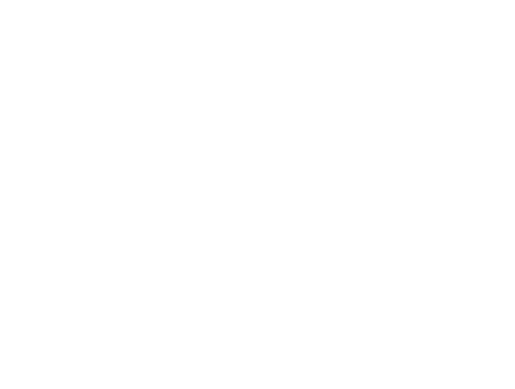

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   152


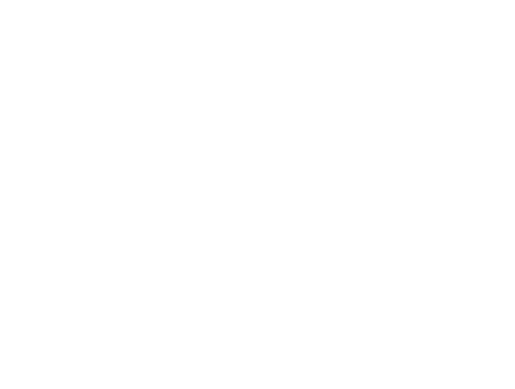

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   153


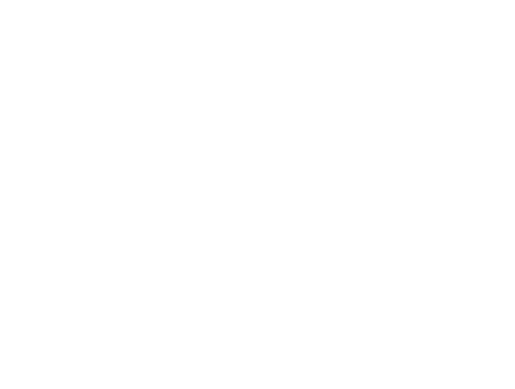

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   154


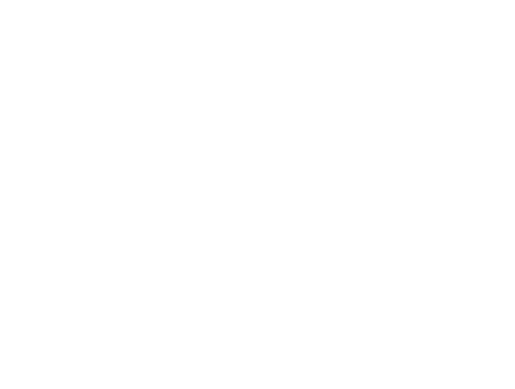

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   155


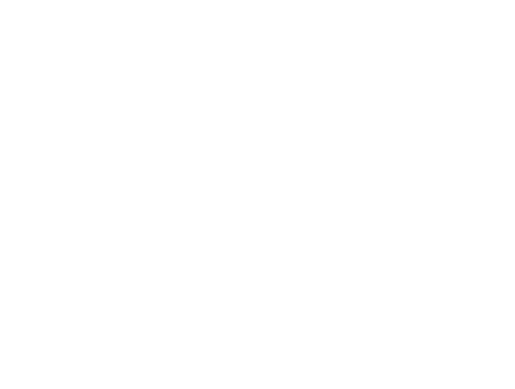

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   156


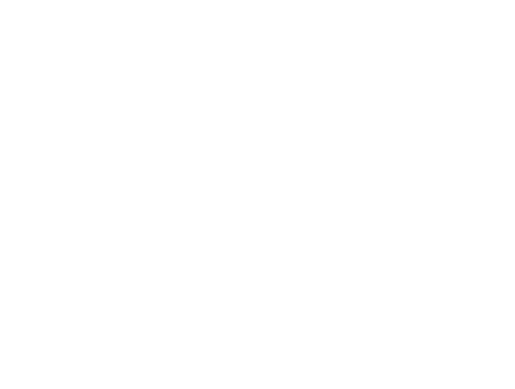

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   157


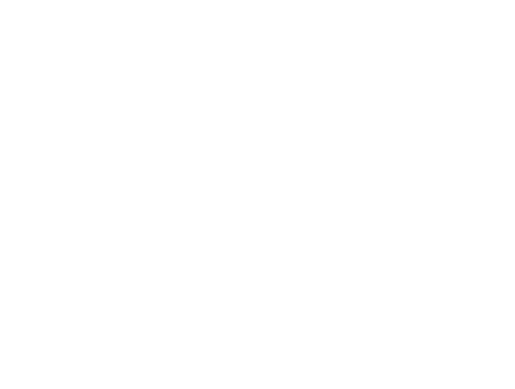

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   158


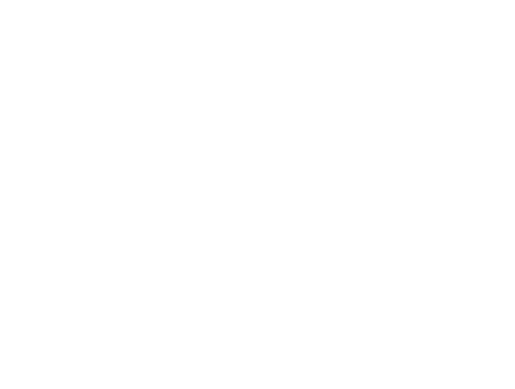

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   159


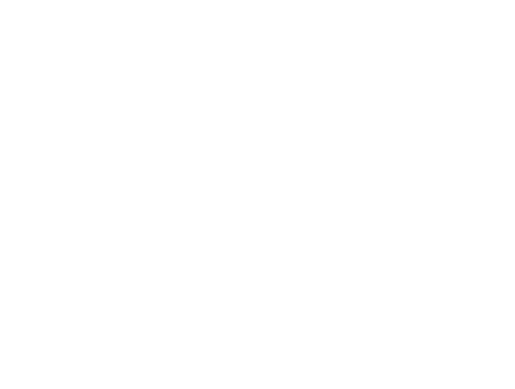

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   160


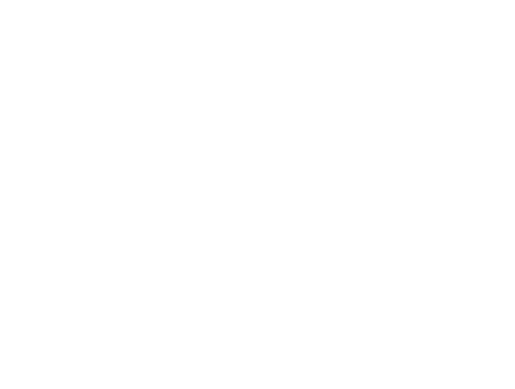

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   161


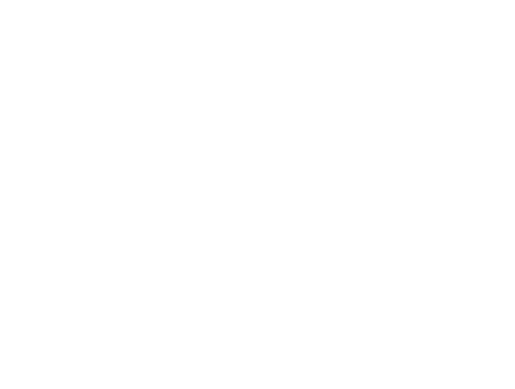

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   162


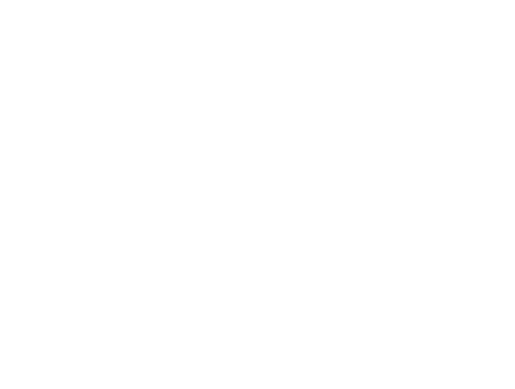

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   163


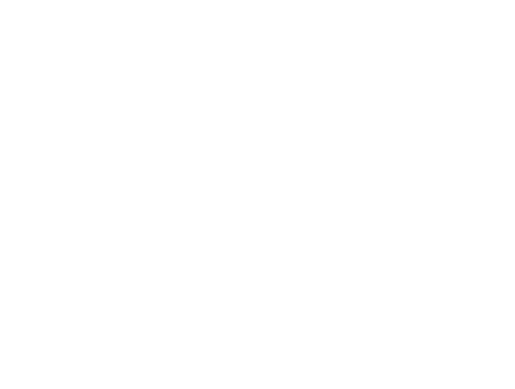

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   164


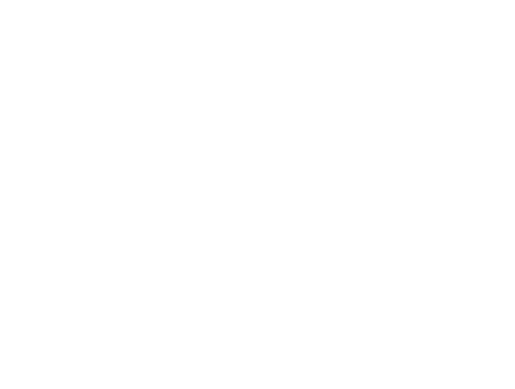

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   165


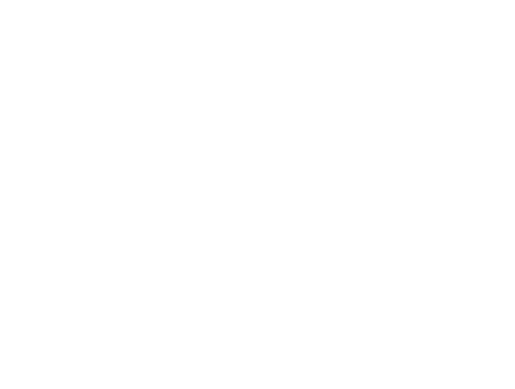

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   166


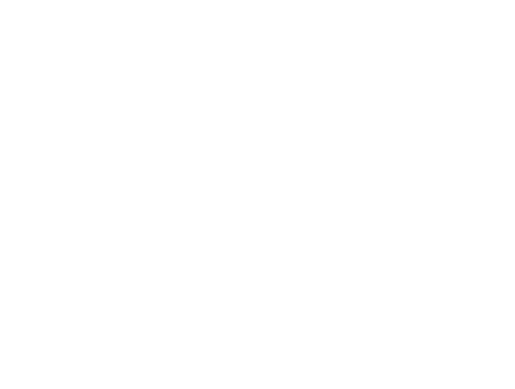

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   167


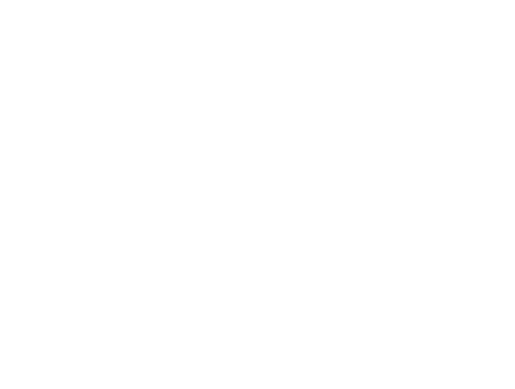

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   168


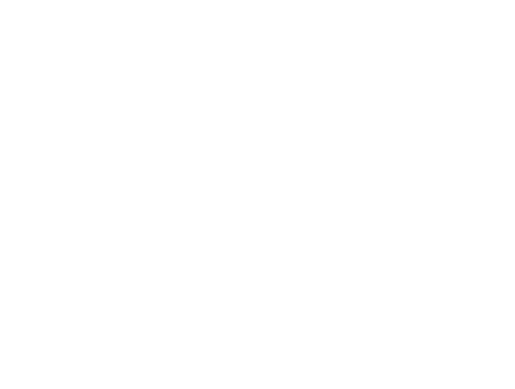

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   169


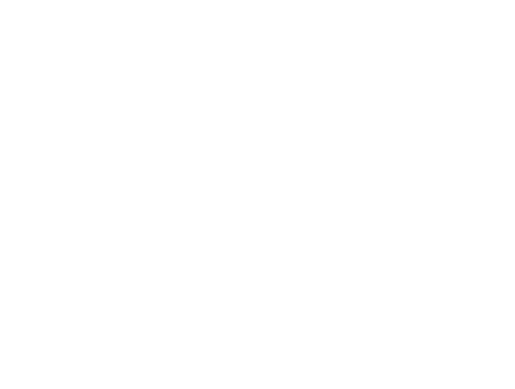

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   170


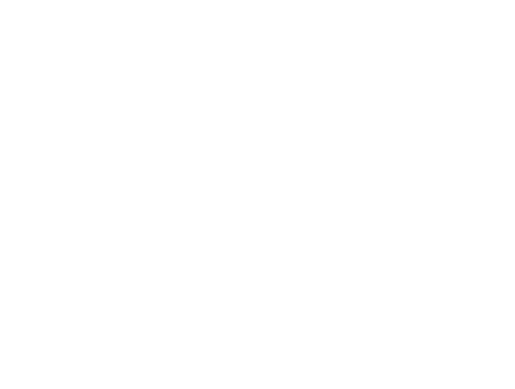

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   171


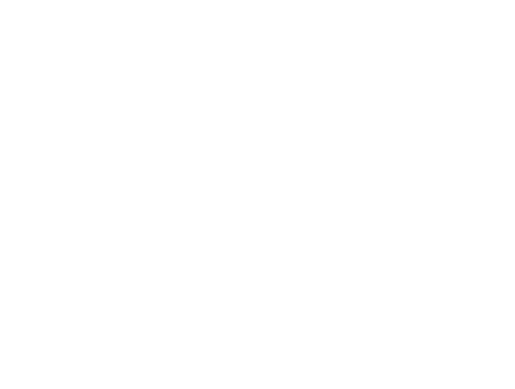

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   172


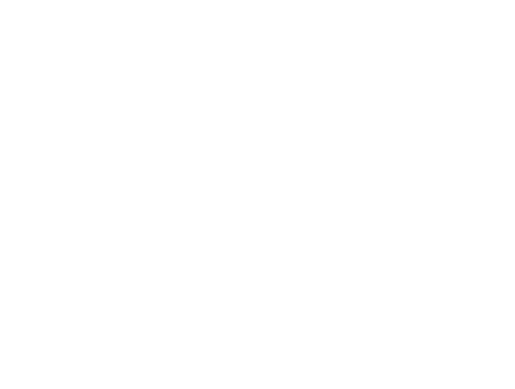

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   173


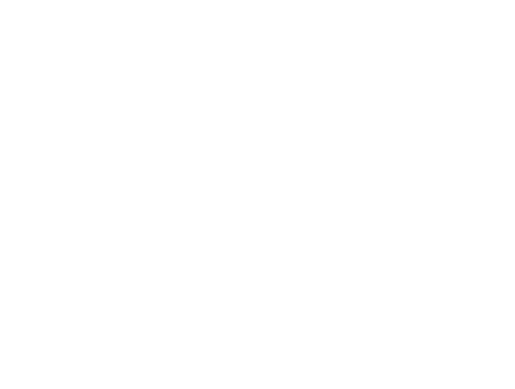

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   174


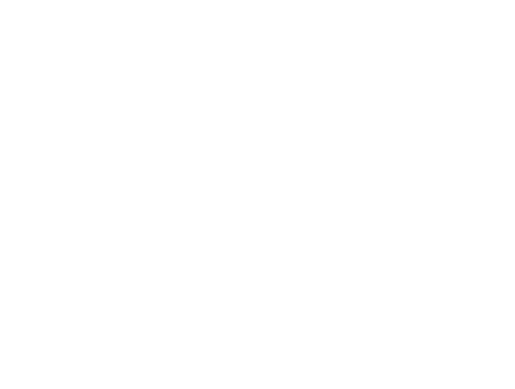

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   175


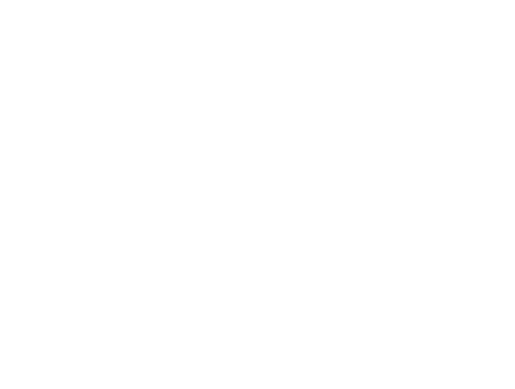

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   176


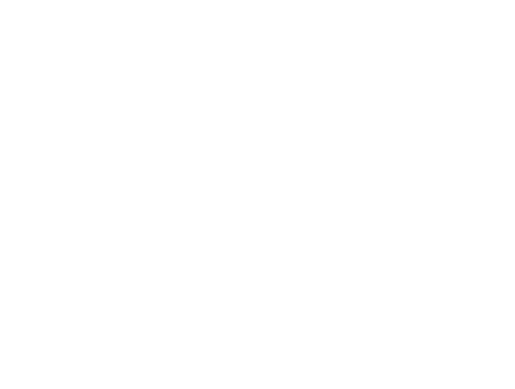

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   177


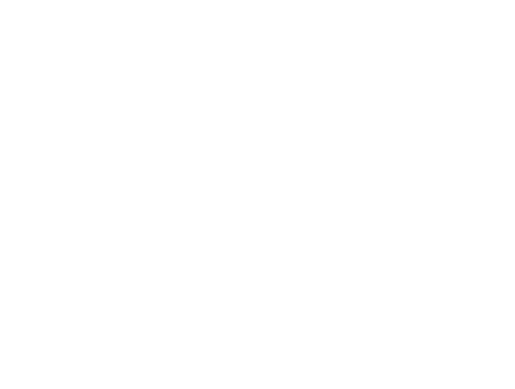

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   178


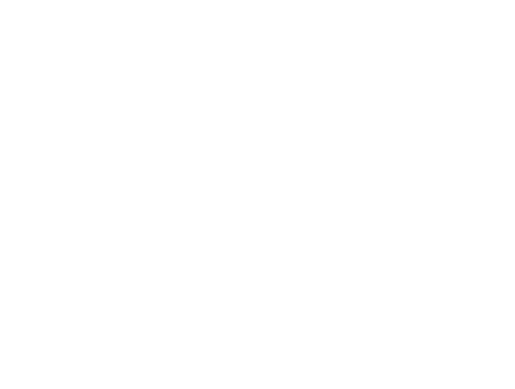

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   179


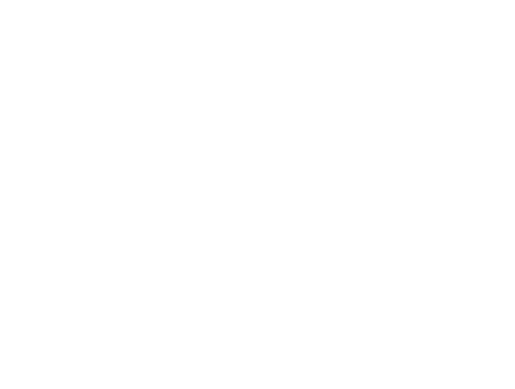

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   180


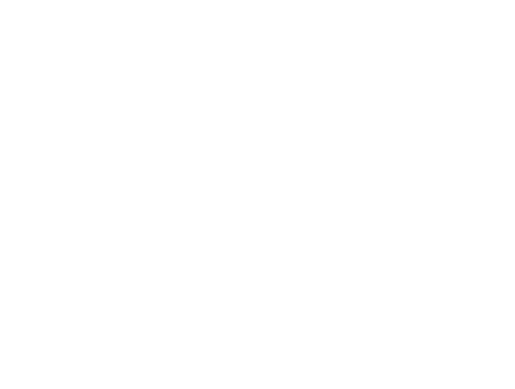

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   181


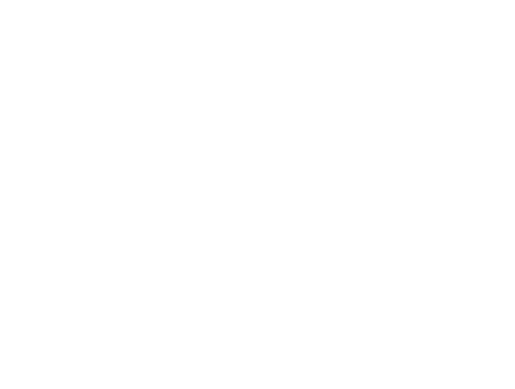

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   182


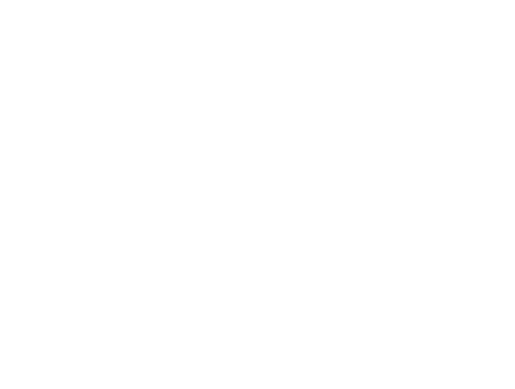

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   183


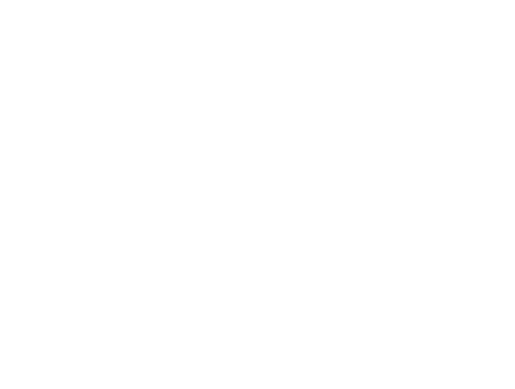

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   184


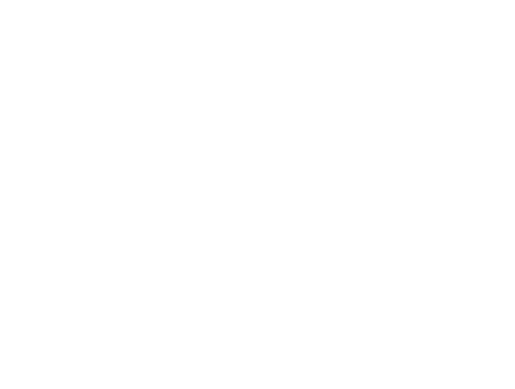

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   185


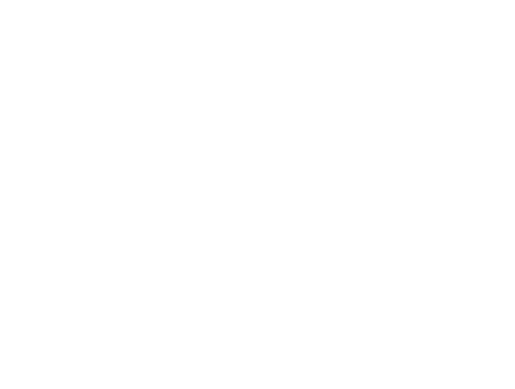

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   186


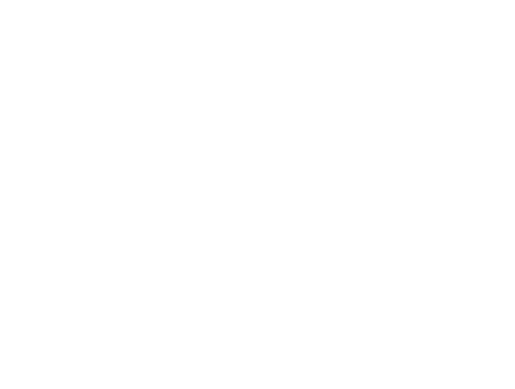

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   187


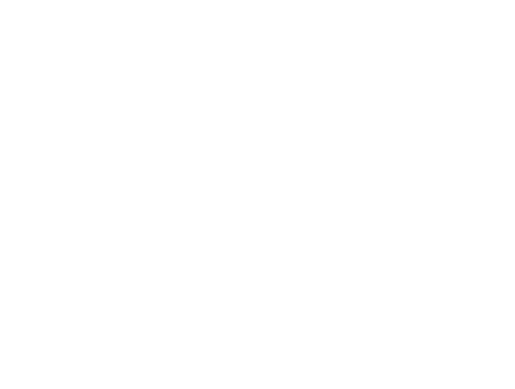

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   188


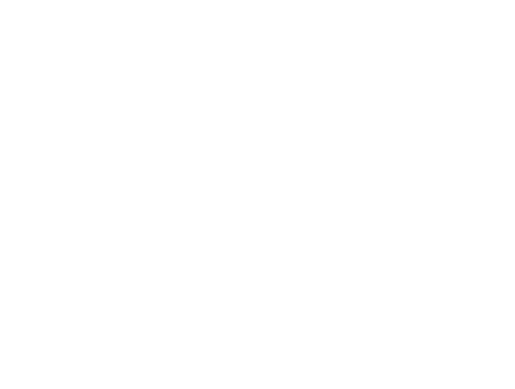

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   189


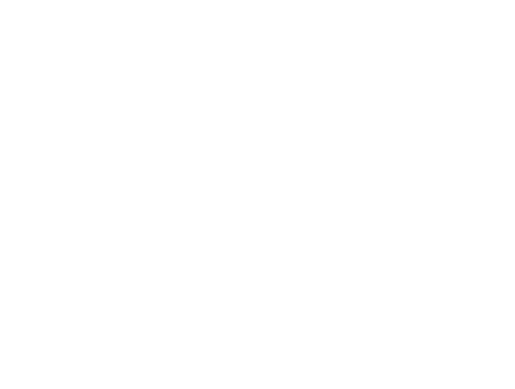

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   190


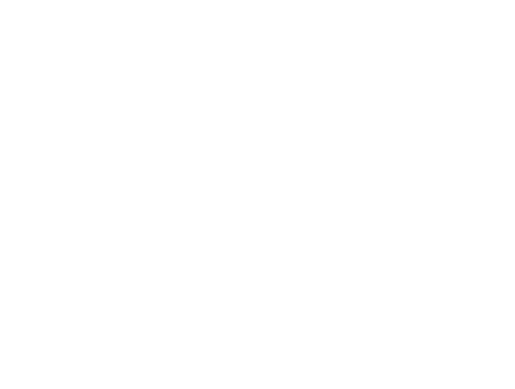

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   191


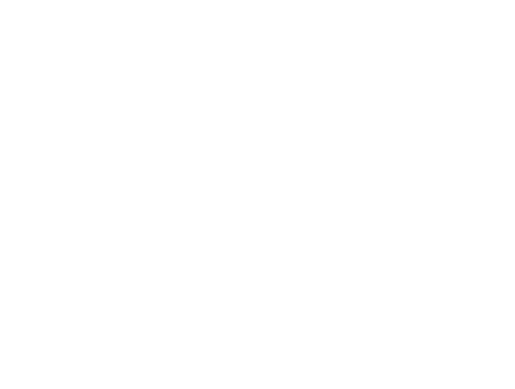

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   192


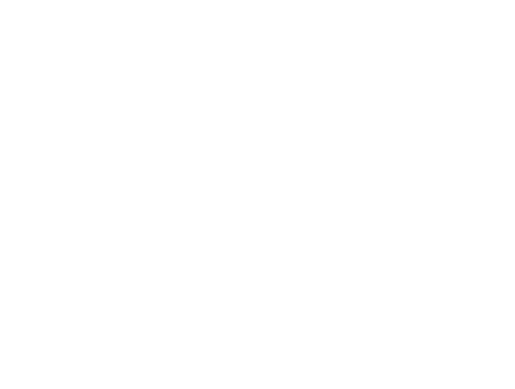

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   193


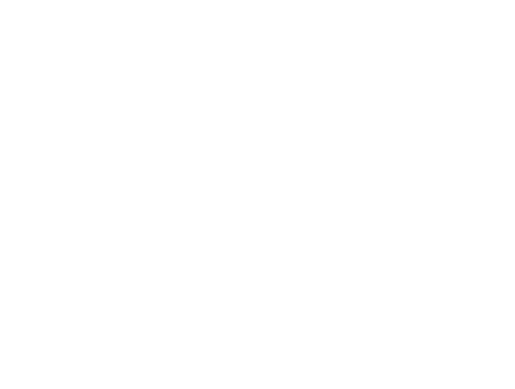

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   194


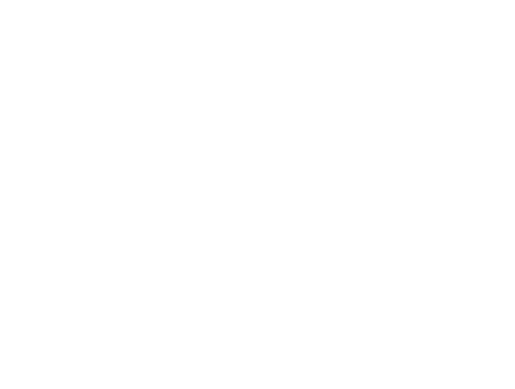

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   195


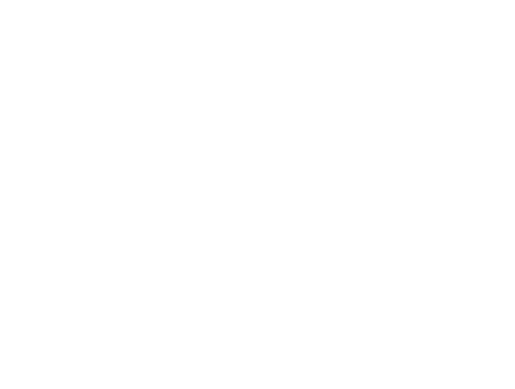

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   196


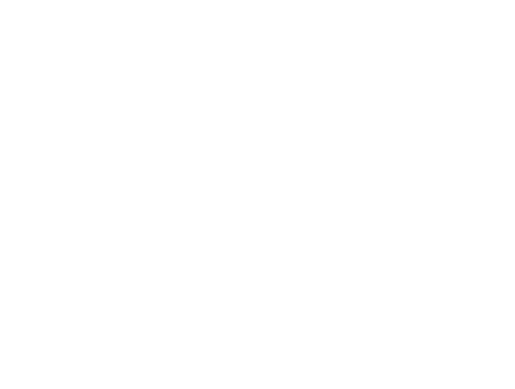

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   197


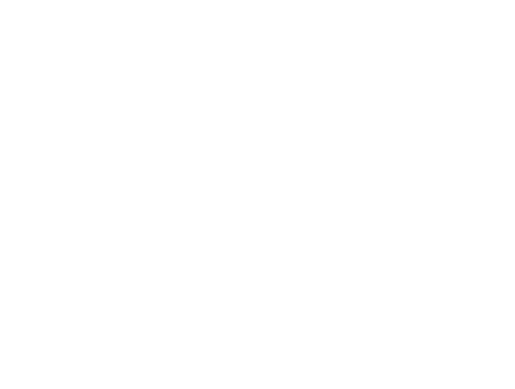

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   198


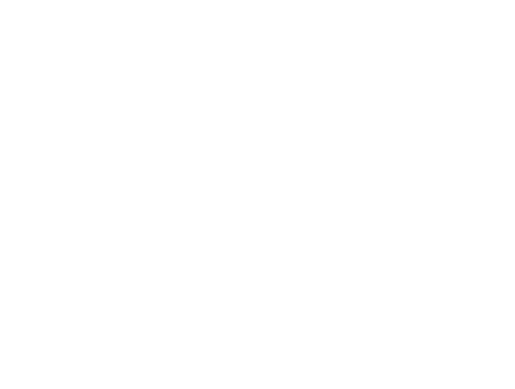

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   199


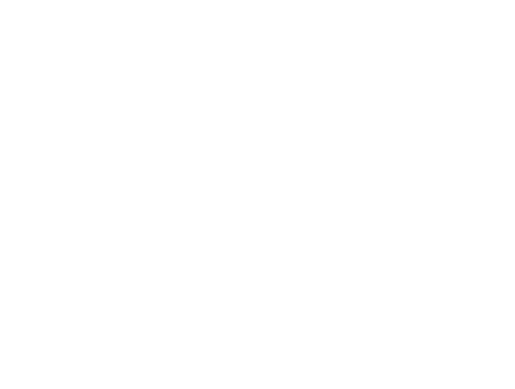

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   200


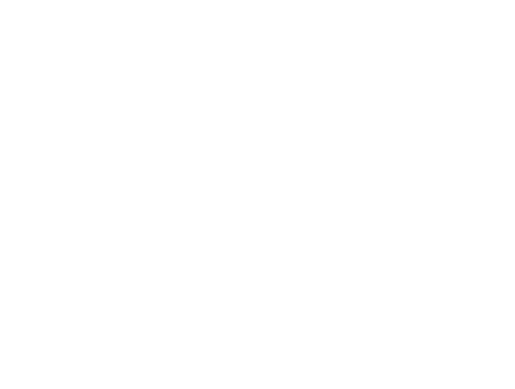

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   201


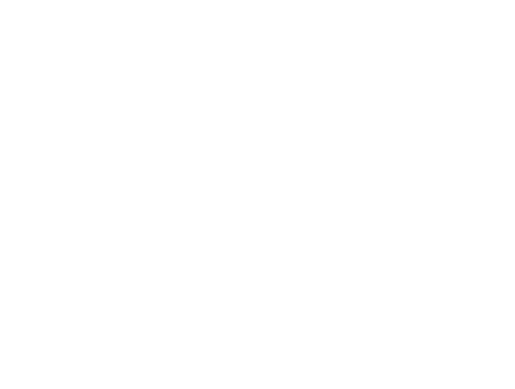

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   202


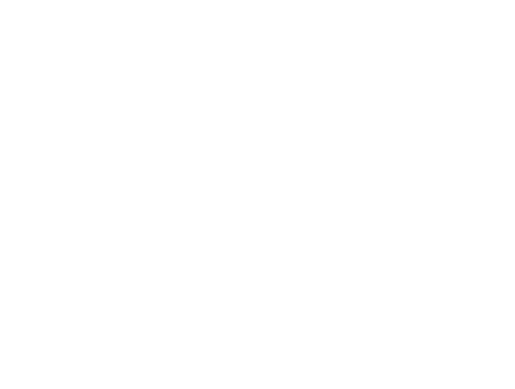

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   203


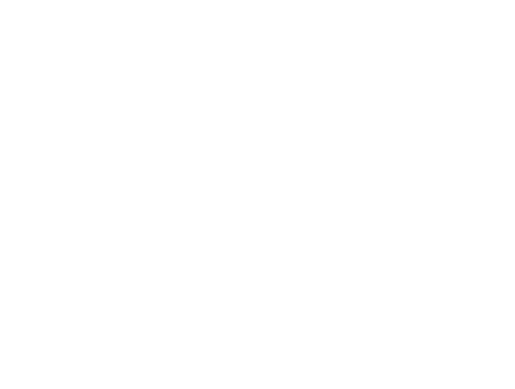

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   204


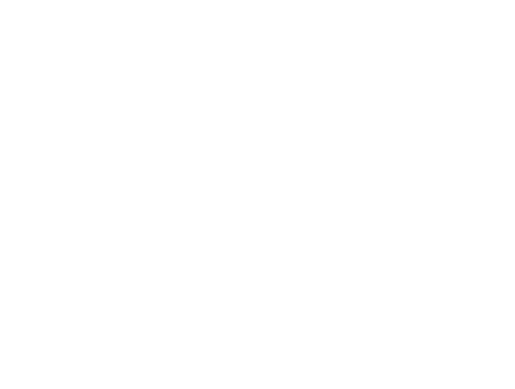

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   205


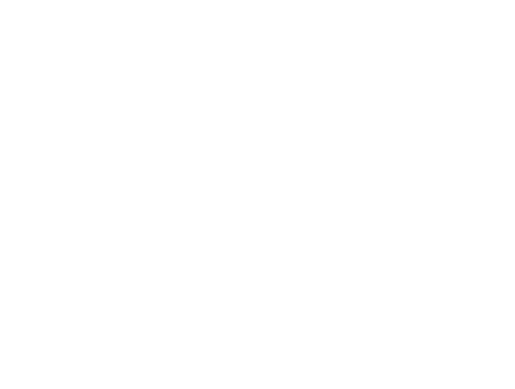

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   206


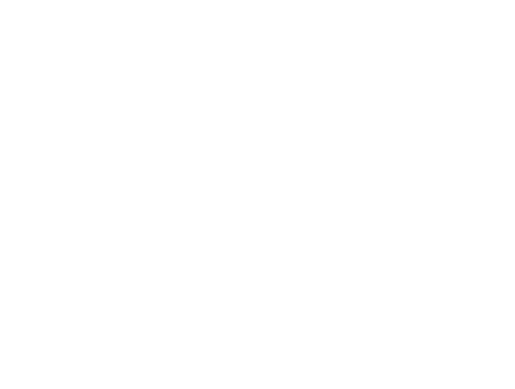

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   207


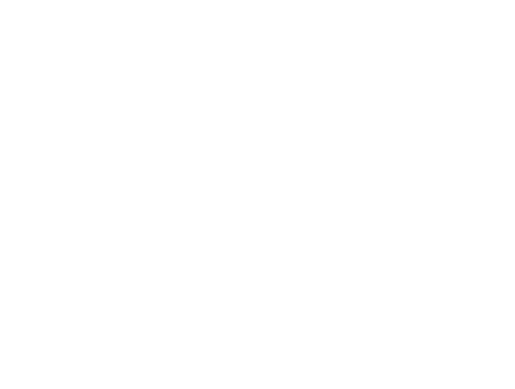

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   208


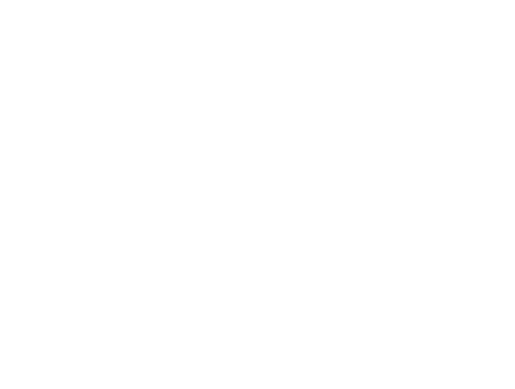

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   209


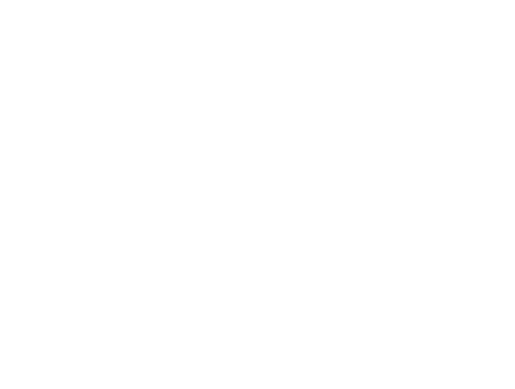

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   210


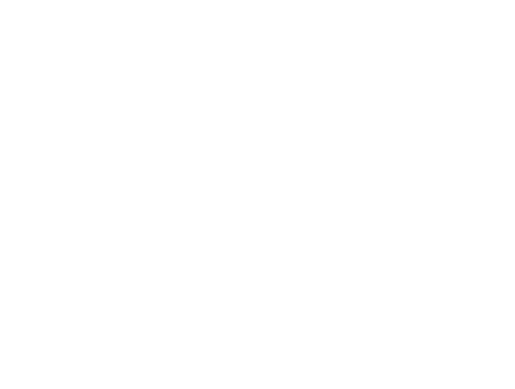

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   211


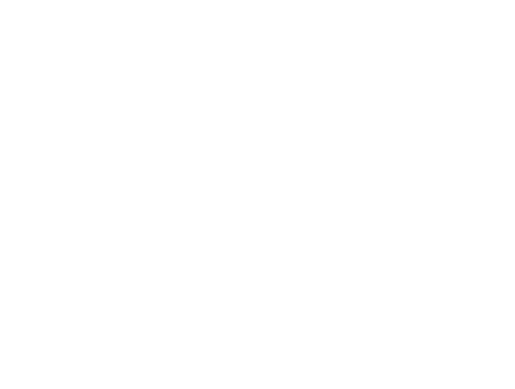

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   212


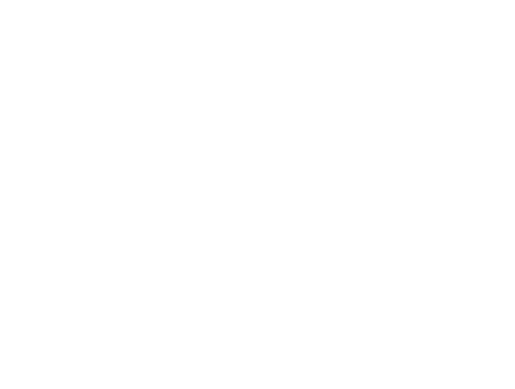

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   213


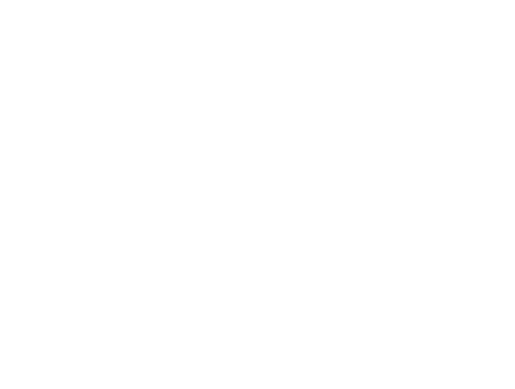

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   214


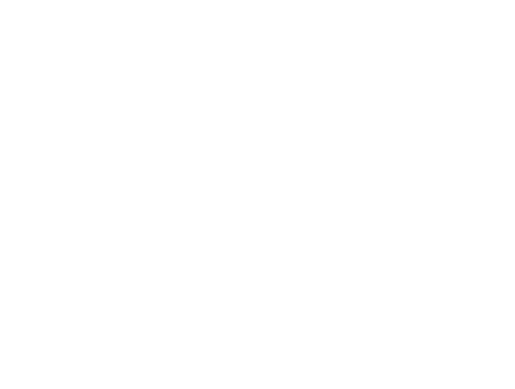

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   215


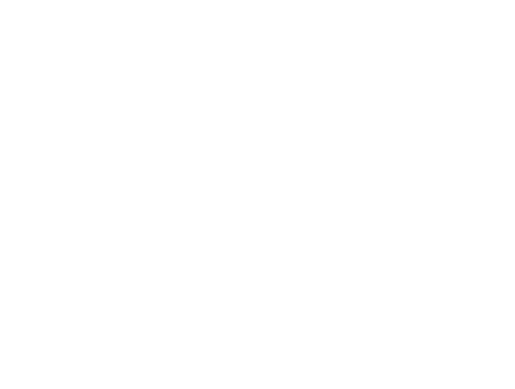

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   216


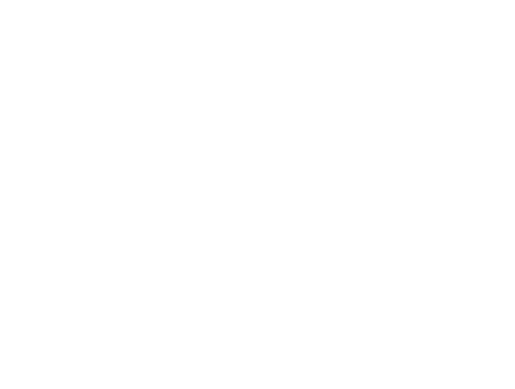

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   217


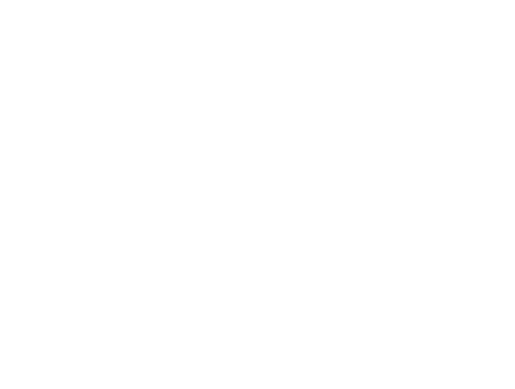

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   218


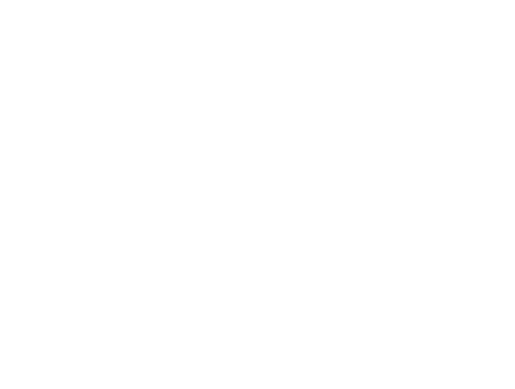

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   219


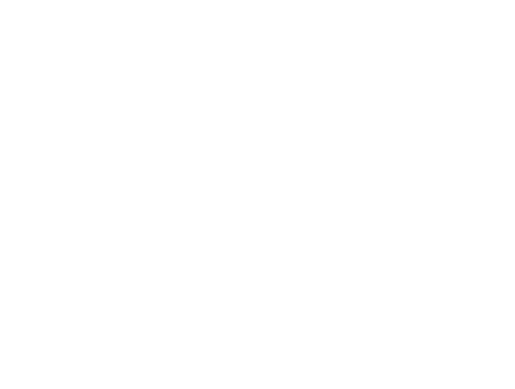

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   220


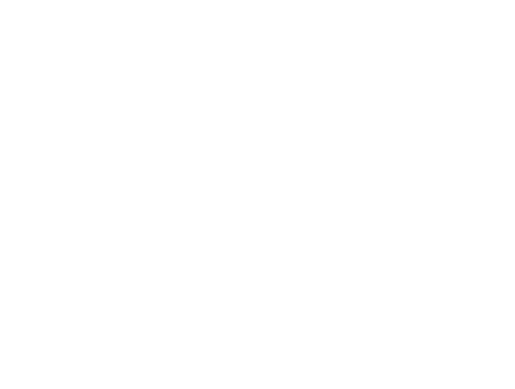

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   221


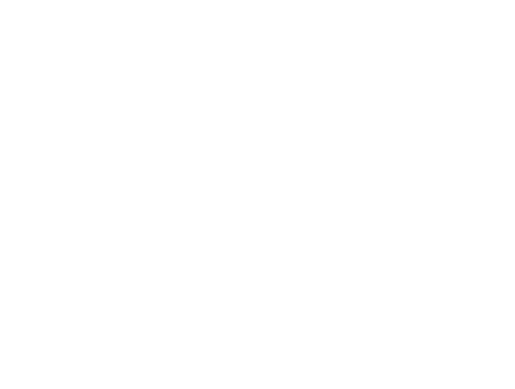

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   222


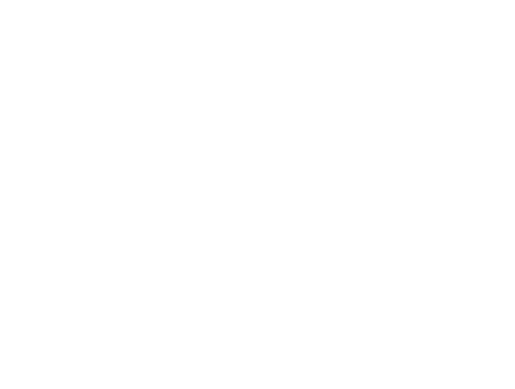

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   223


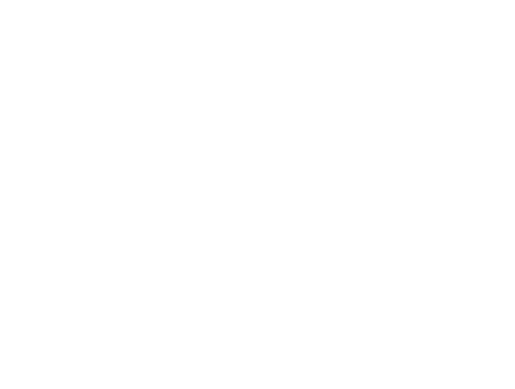

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   224


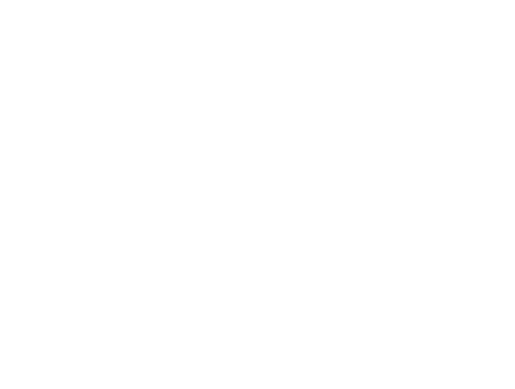

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   225


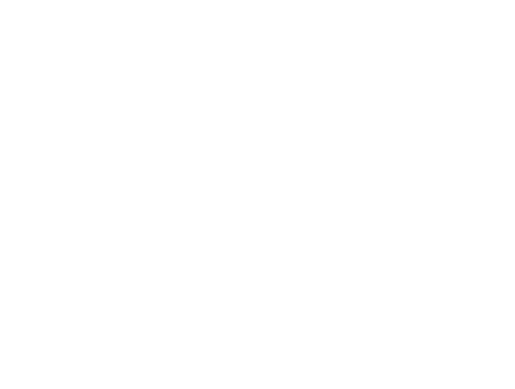

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   226


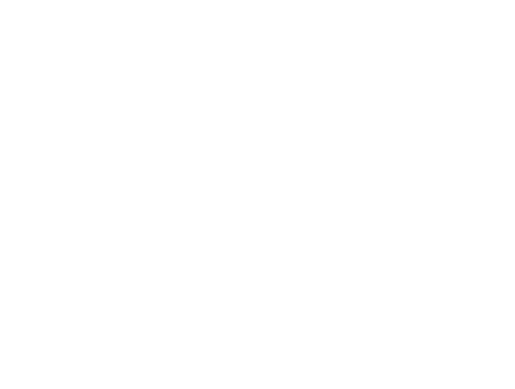

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   227


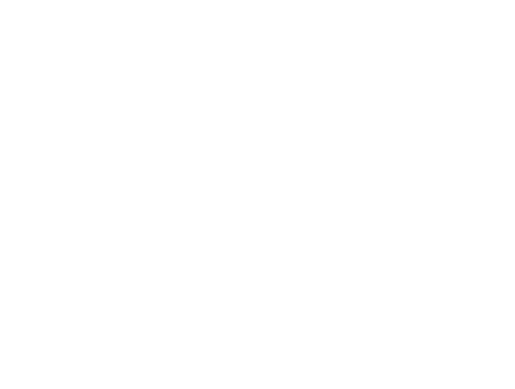

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   228


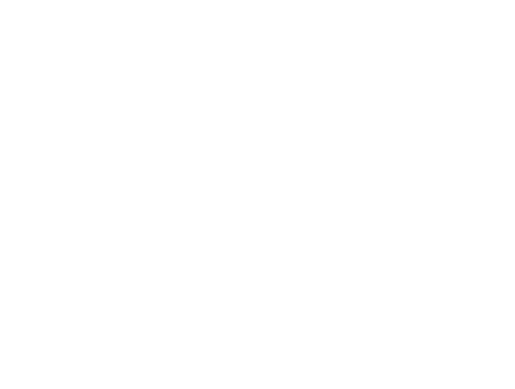

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   229


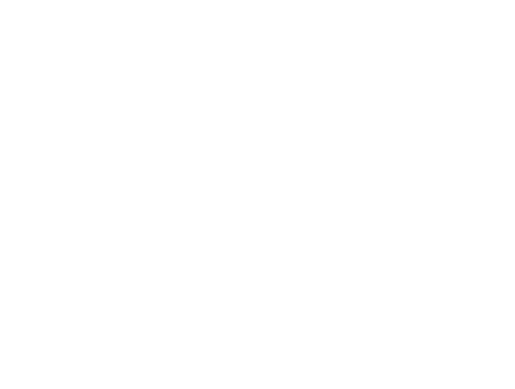

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   230


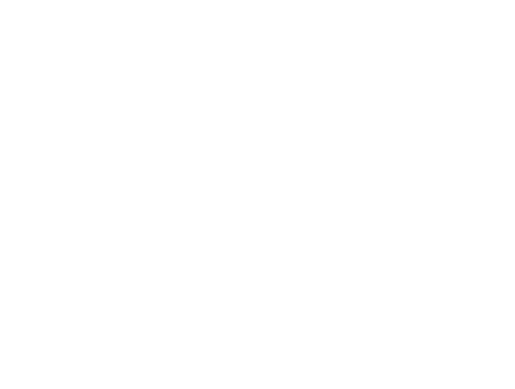

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   231


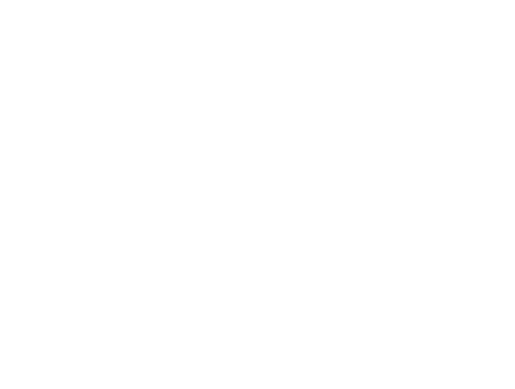

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   232


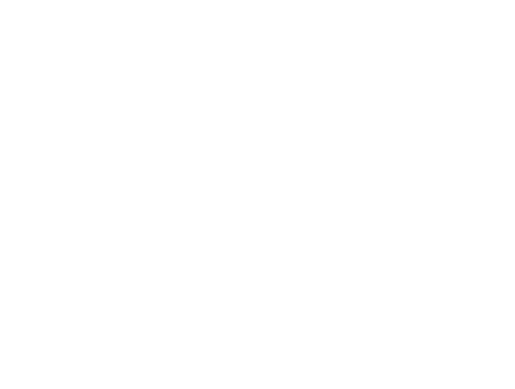

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   233


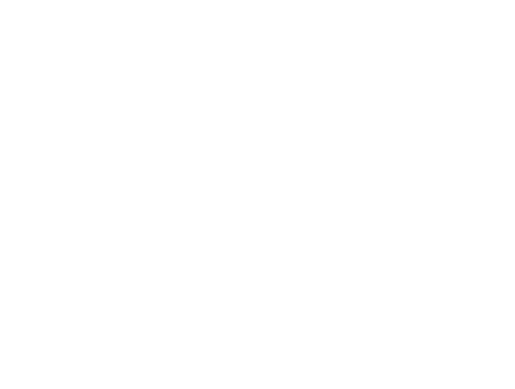

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   234


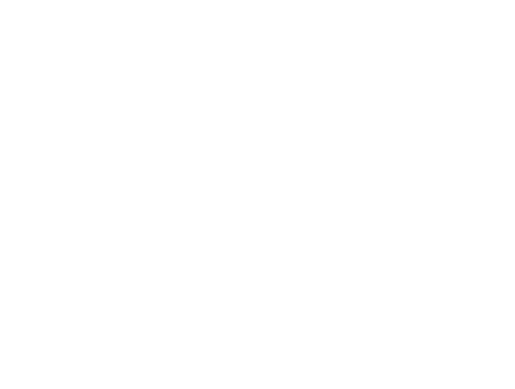

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   235


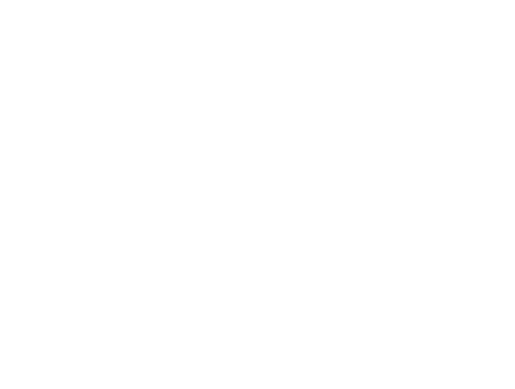

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   236


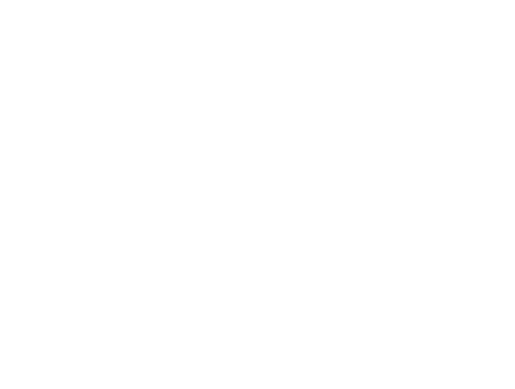

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   237


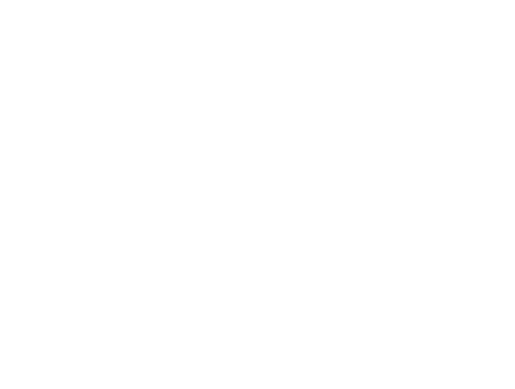

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   238


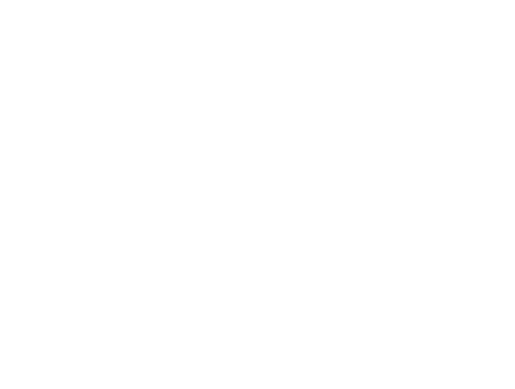

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   239


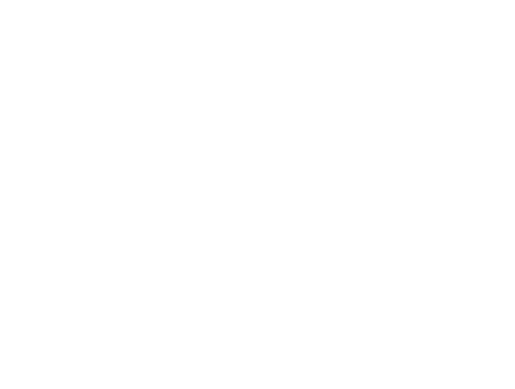

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   240


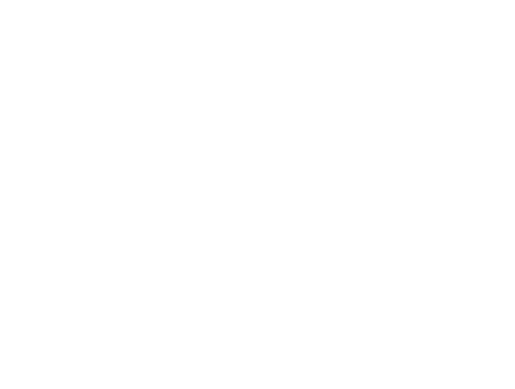

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   241


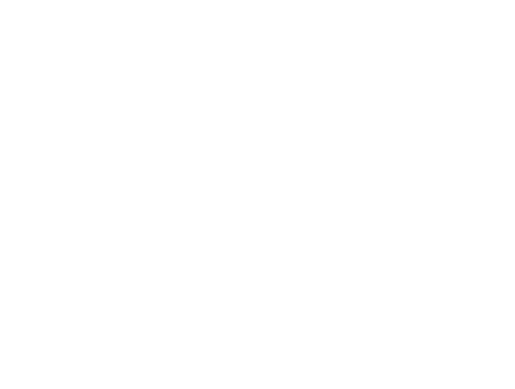

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   242


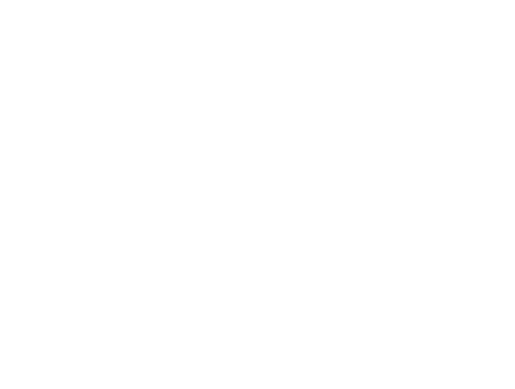

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   243


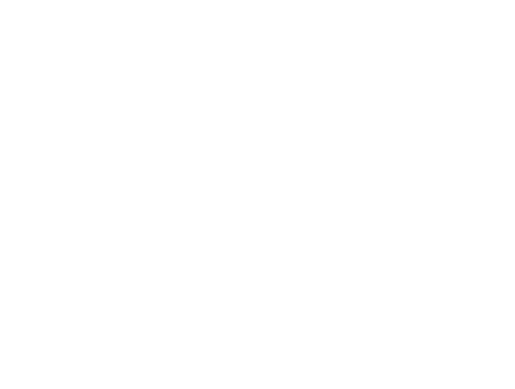

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   244


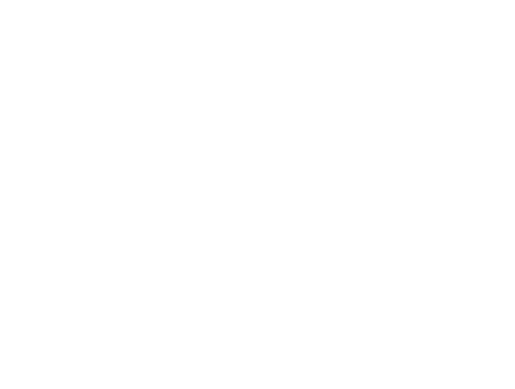

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   245


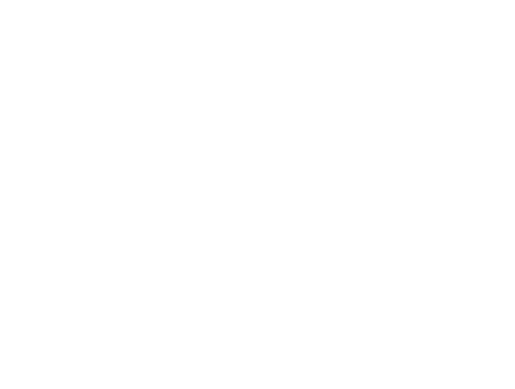

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   246


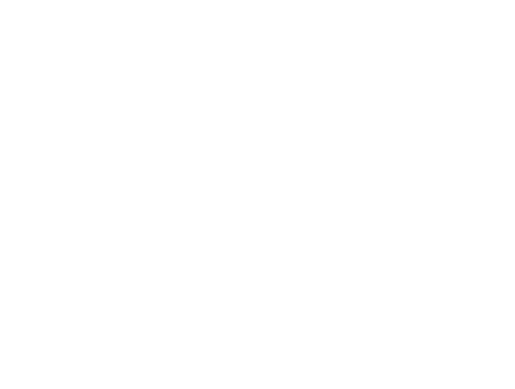

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   247


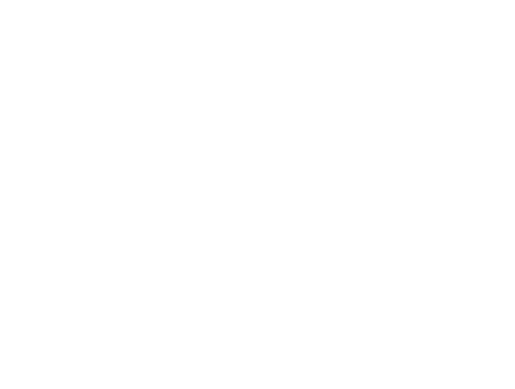

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   248


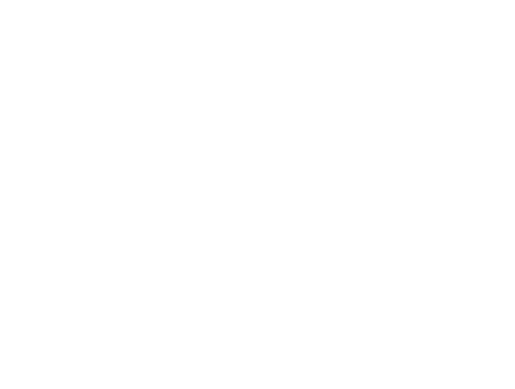

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   249


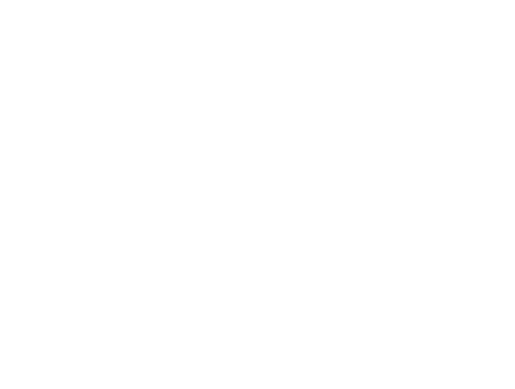

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   250


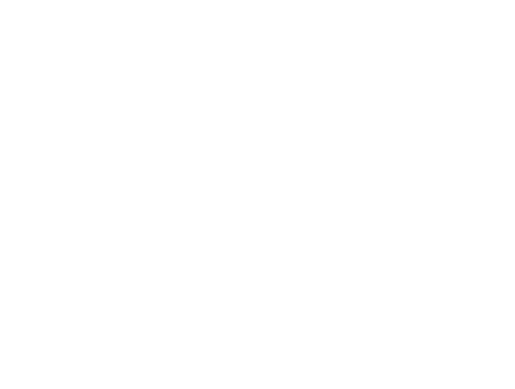

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   251


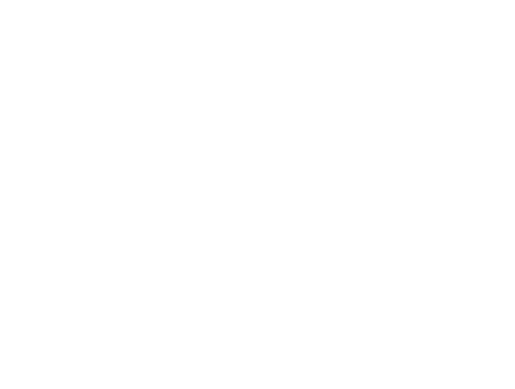

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   252


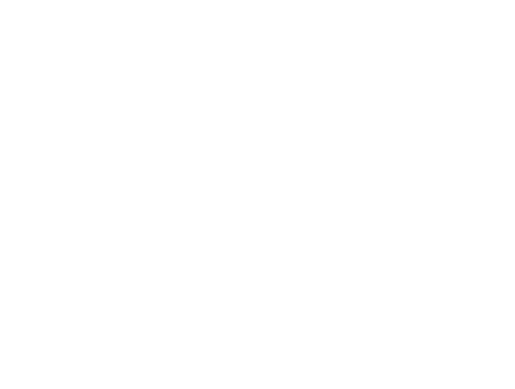

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   253


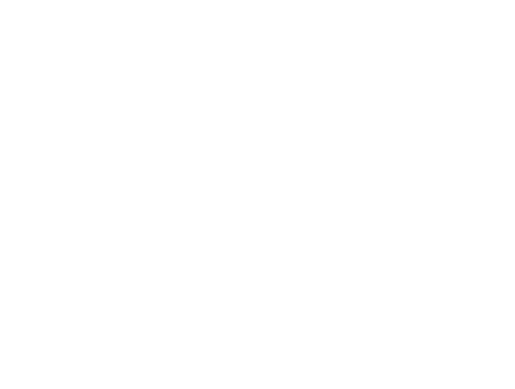

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   254


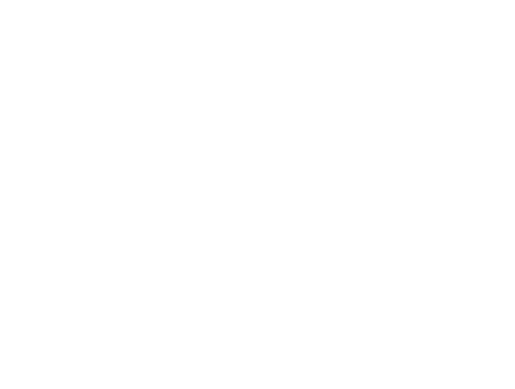

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   255


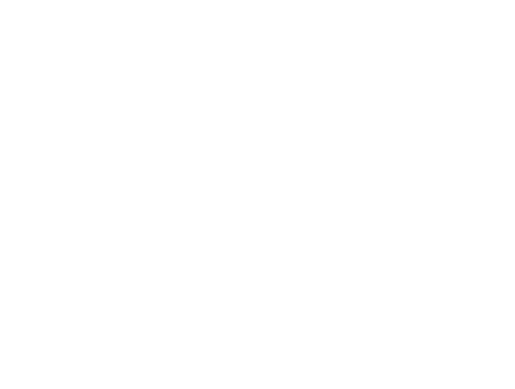

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   256


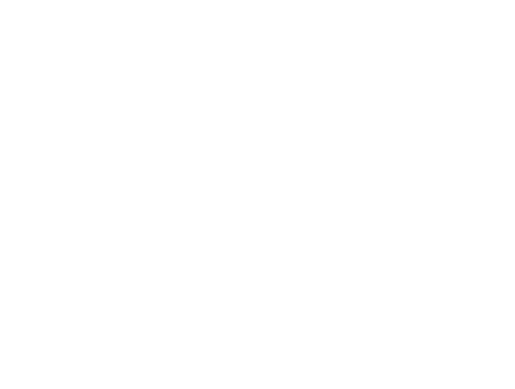

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   257


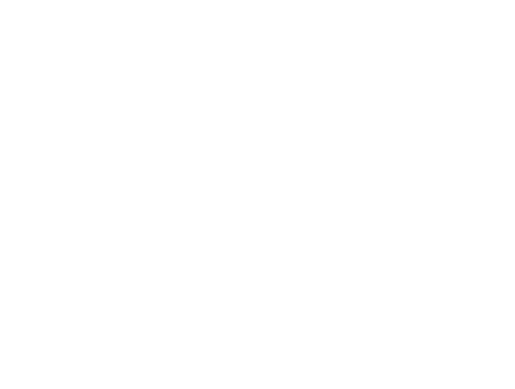

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   258


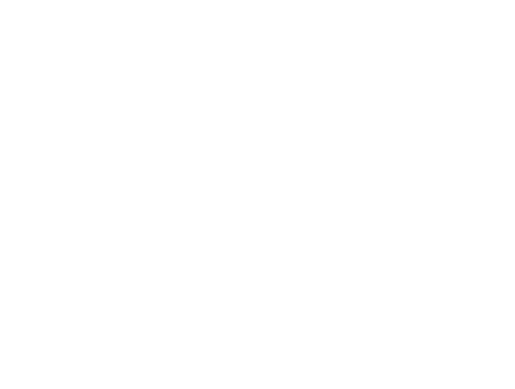

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   259


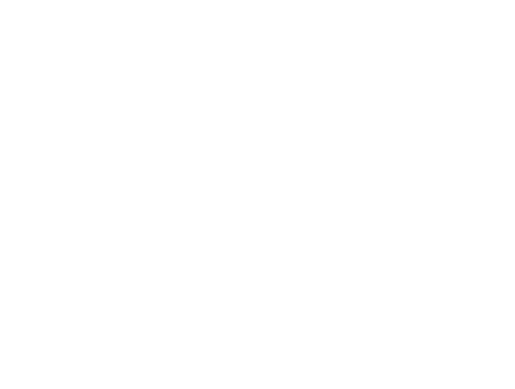

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   260


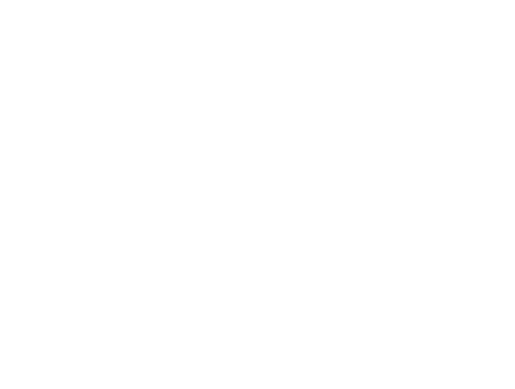

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   261


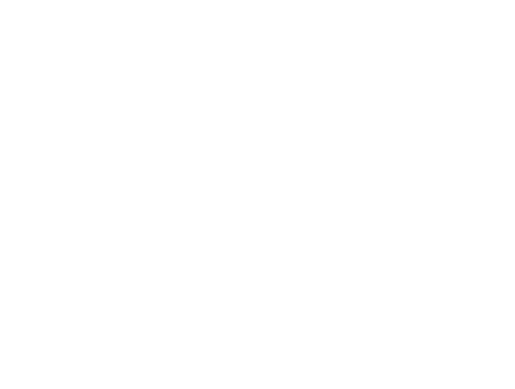

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   262


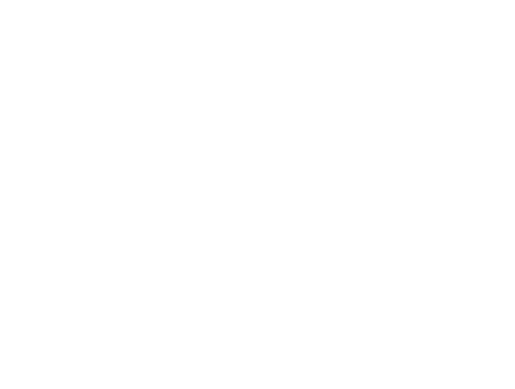

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   263


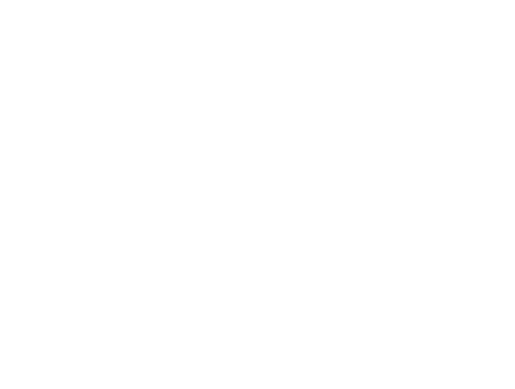

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   264


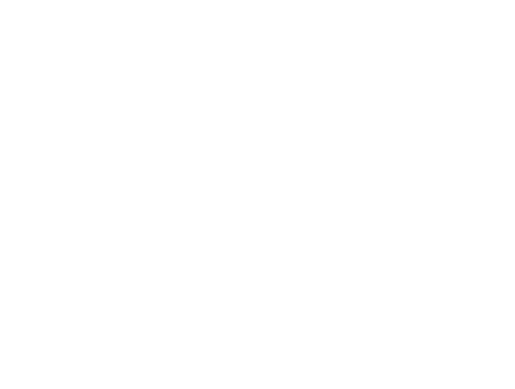

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   265


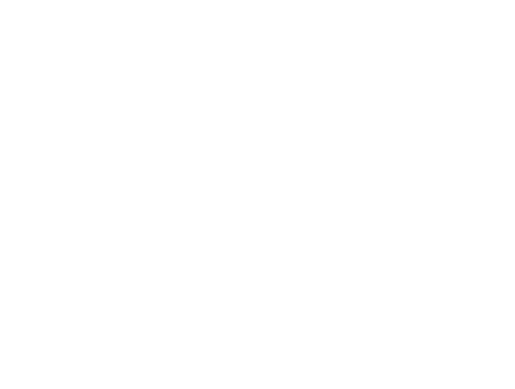

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   266


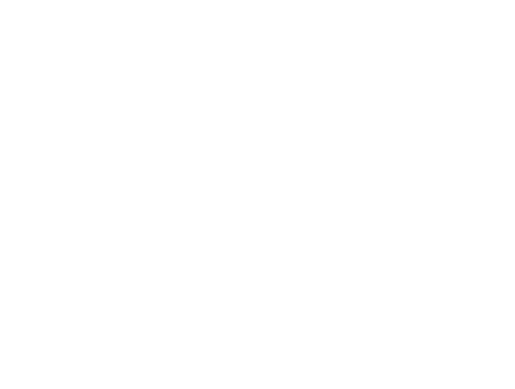

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   267


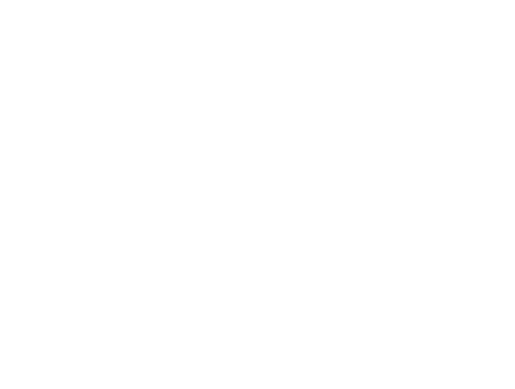

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   268


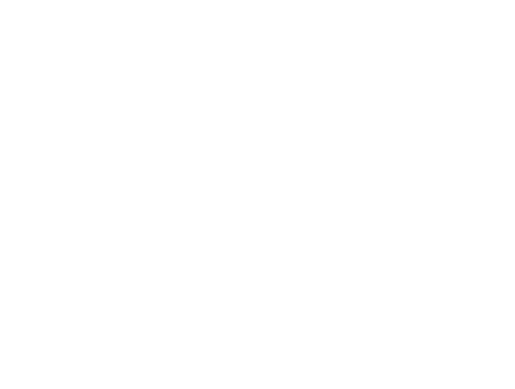

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   269


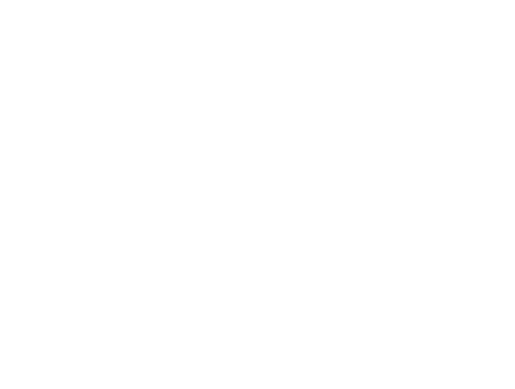

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   270


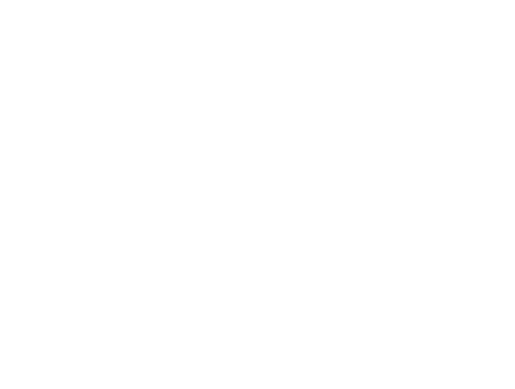

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   271


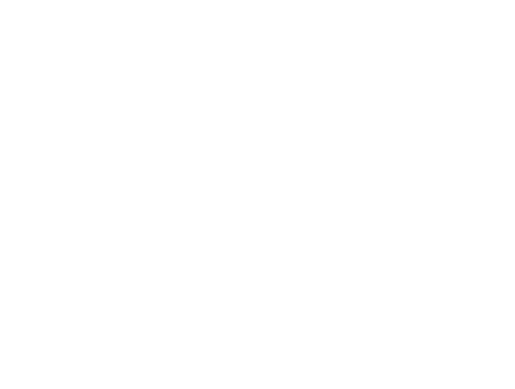

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   272


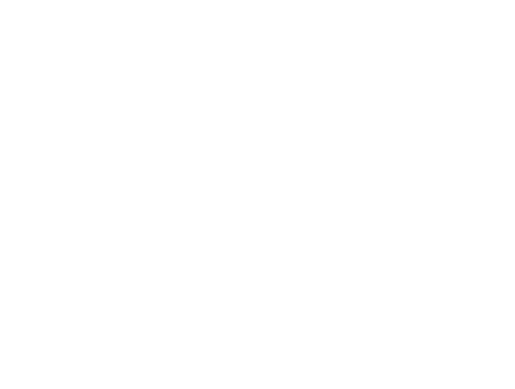

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   273


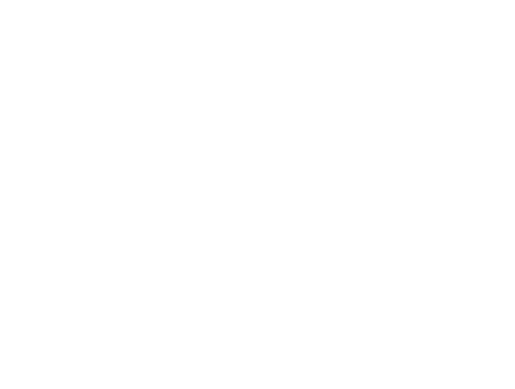

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   274


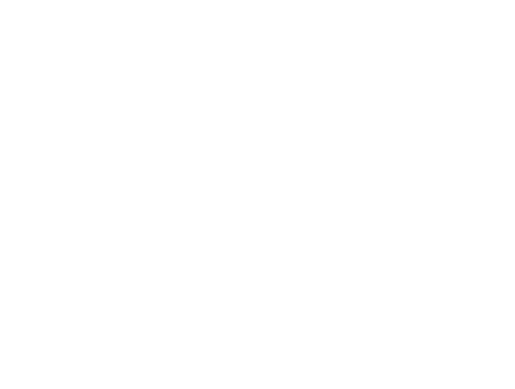

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   275


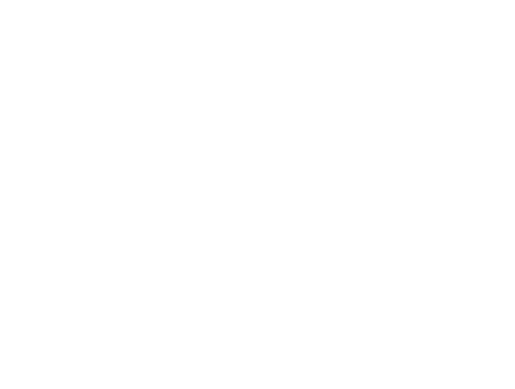

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   276


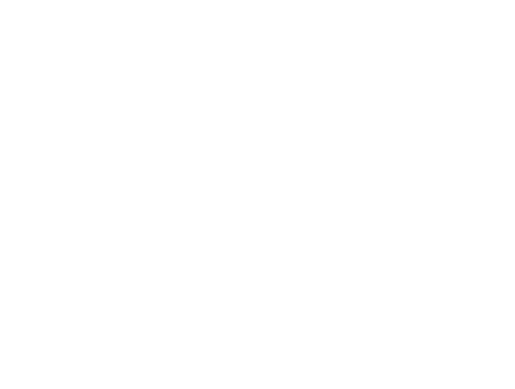

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   277


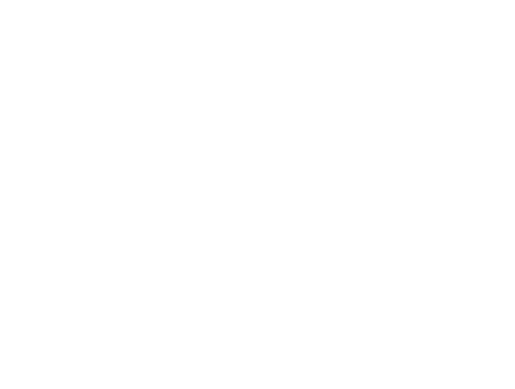

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   278


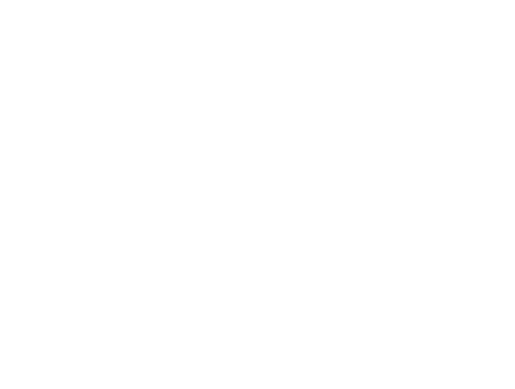

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   279


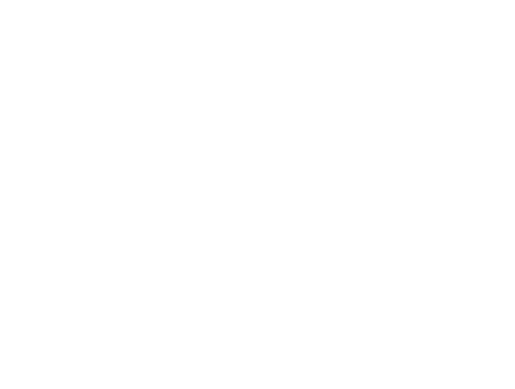

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   280


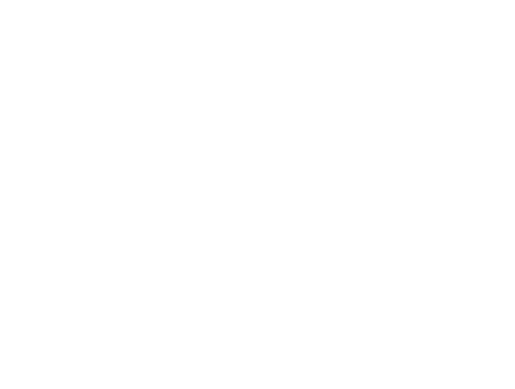

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   281


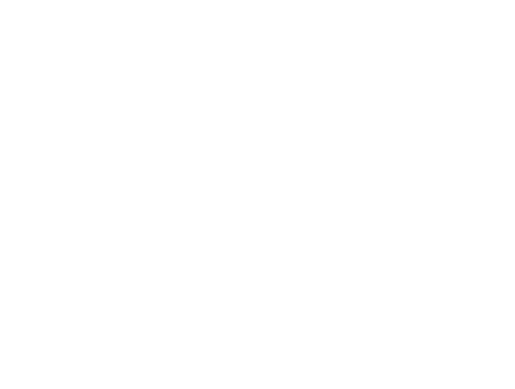

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   282


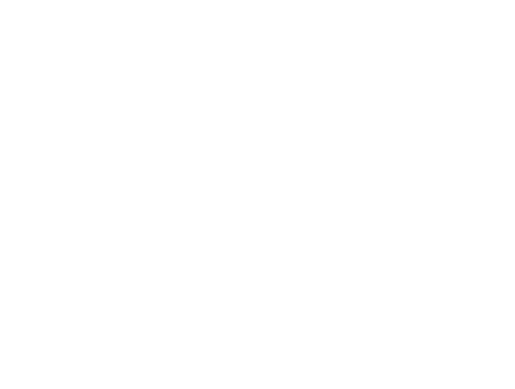

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   283


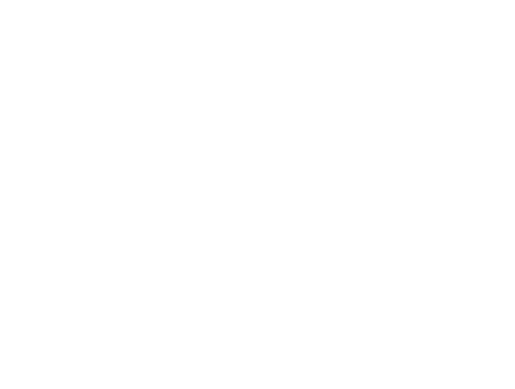

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   284


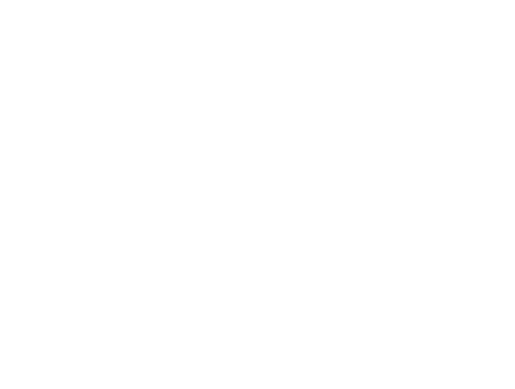

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   285


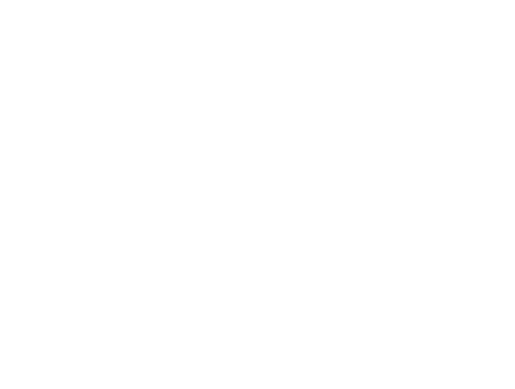

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   286


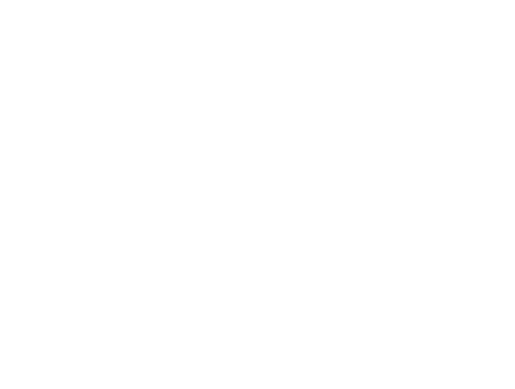

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   287


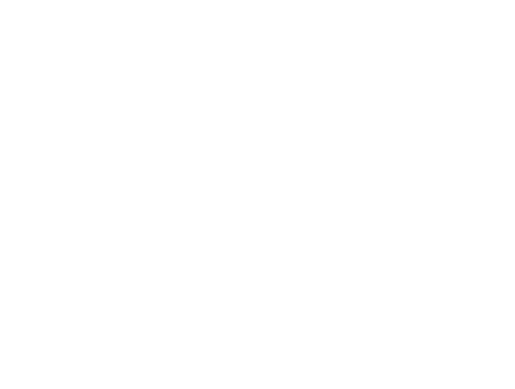

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   288


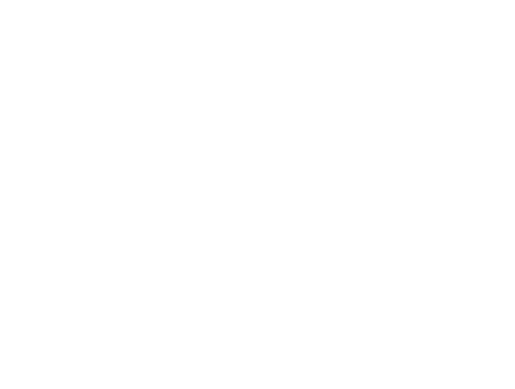

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   289


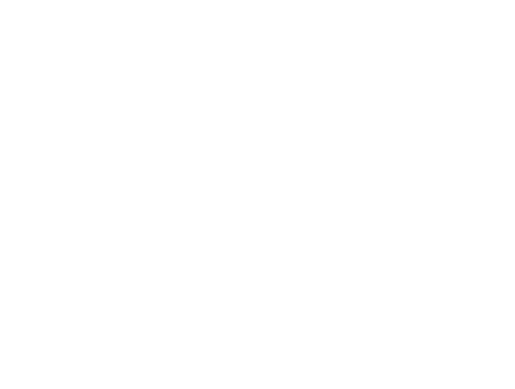

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   290


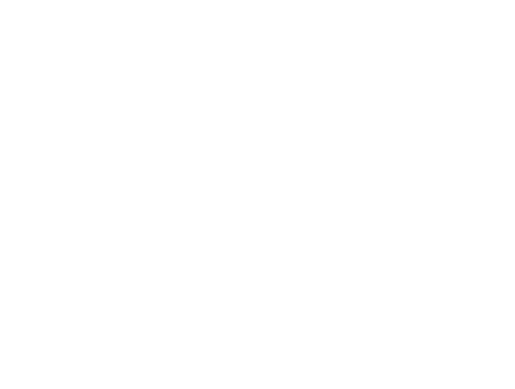

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   291


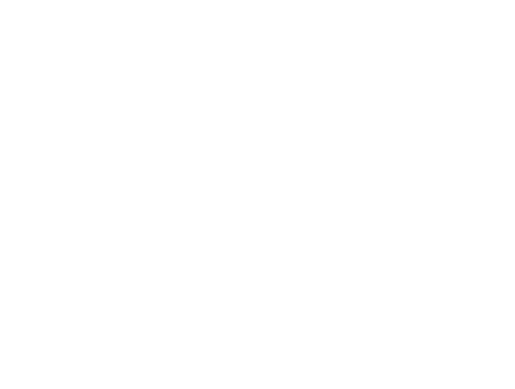

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   292


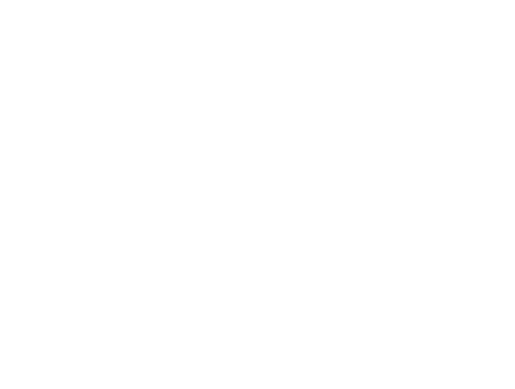

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   293


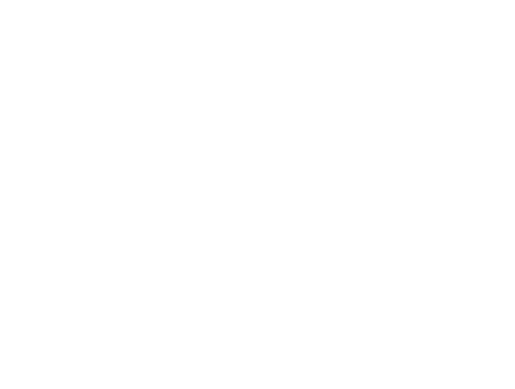

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   294


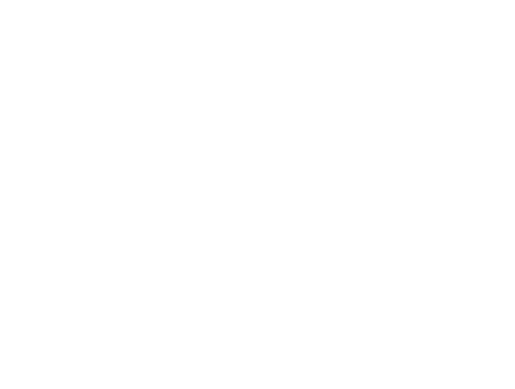

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   295


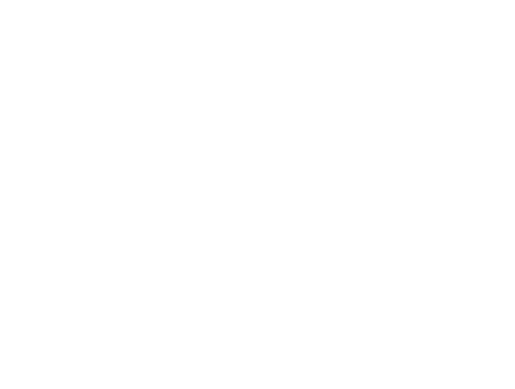

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   296


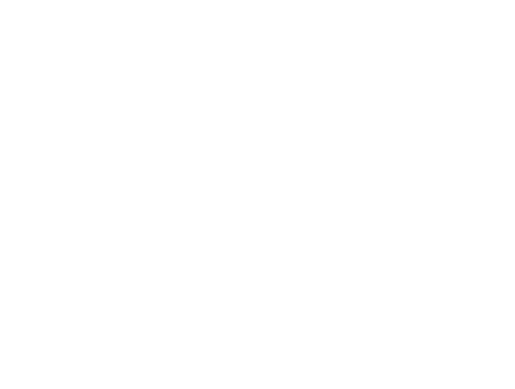

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   297


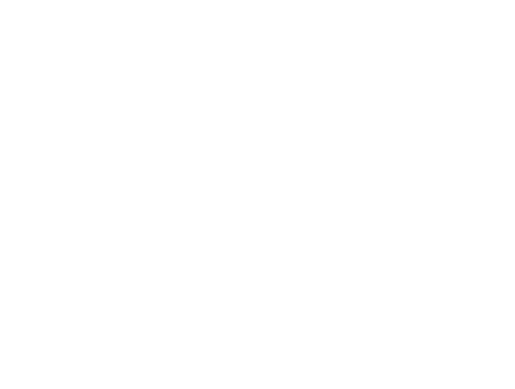

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   298


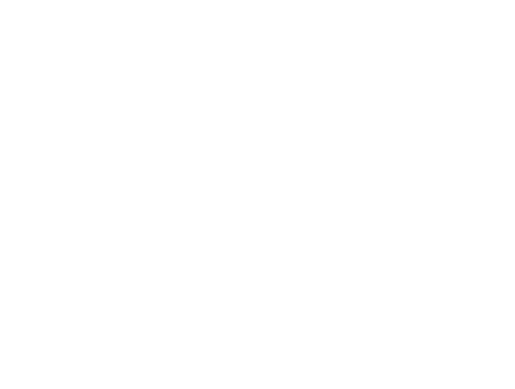

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   299


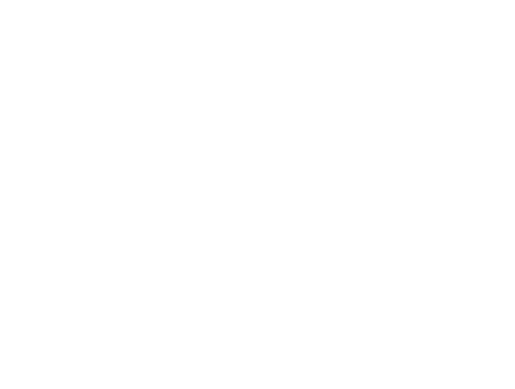

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   300


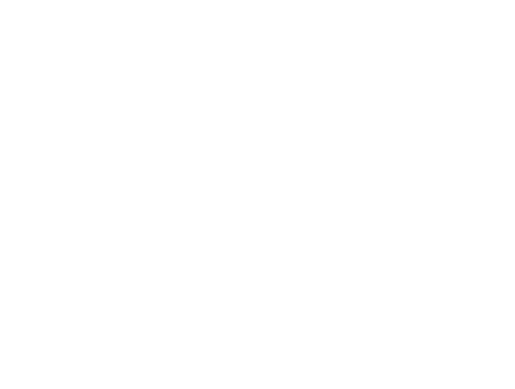

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   301


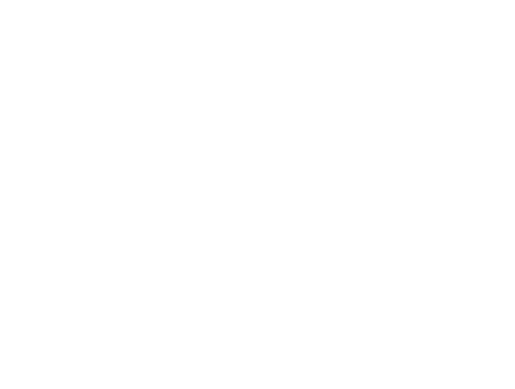

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   302


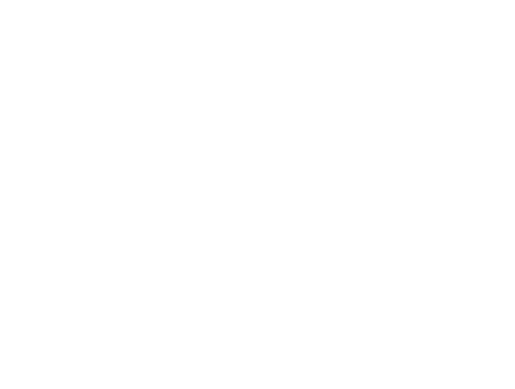

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   303


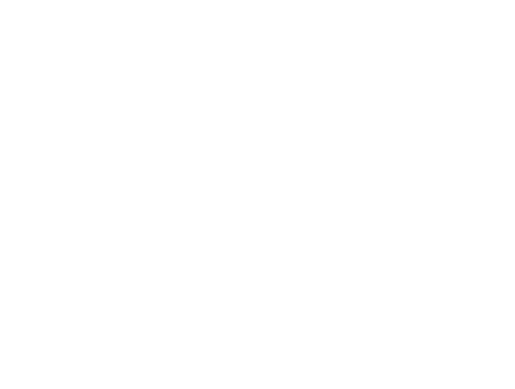

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   304


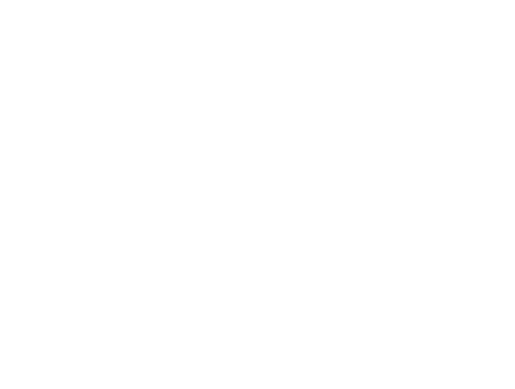

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   305


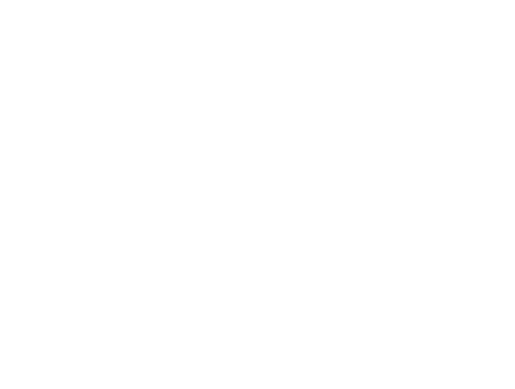

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   306


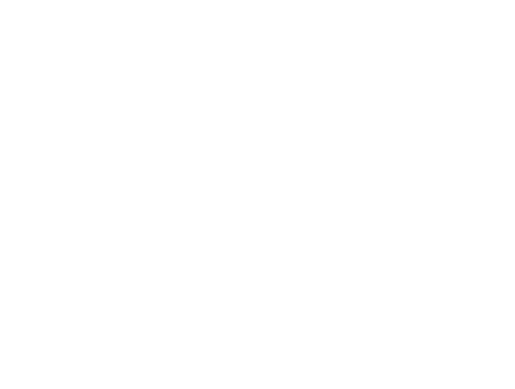

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   307


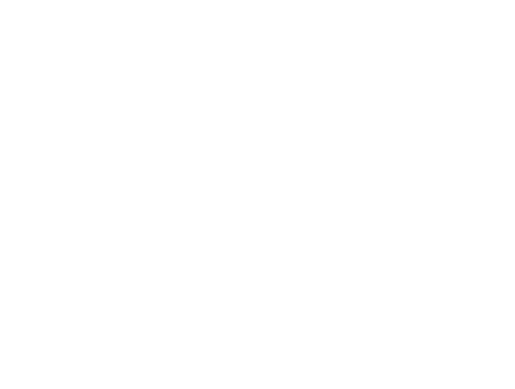

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   308


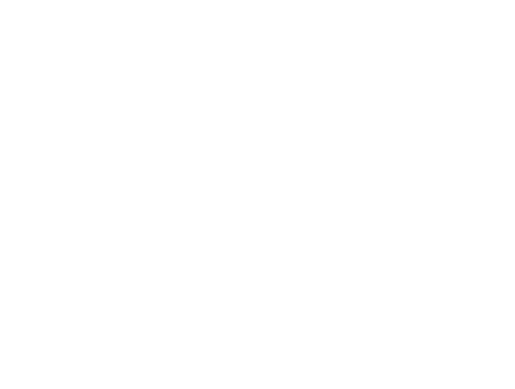

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   309


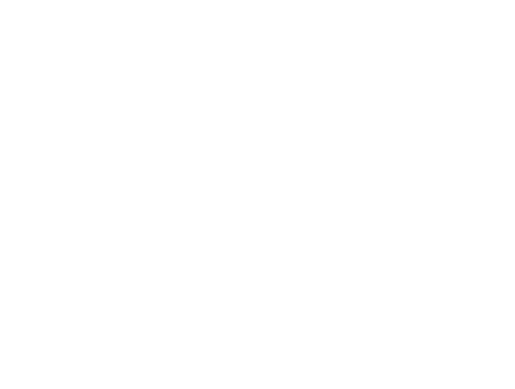

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   310


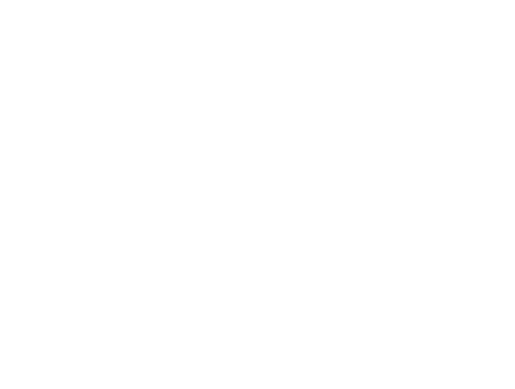

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   311


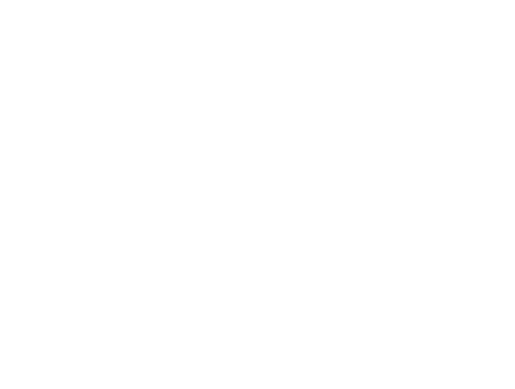

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   312


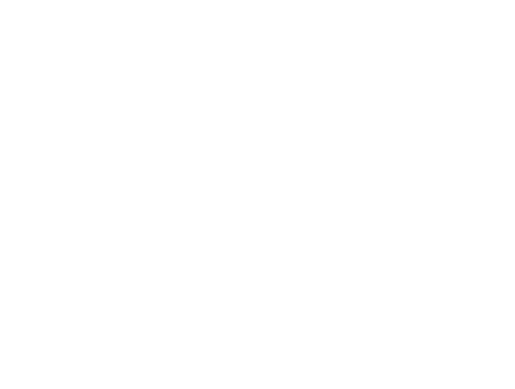

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   313


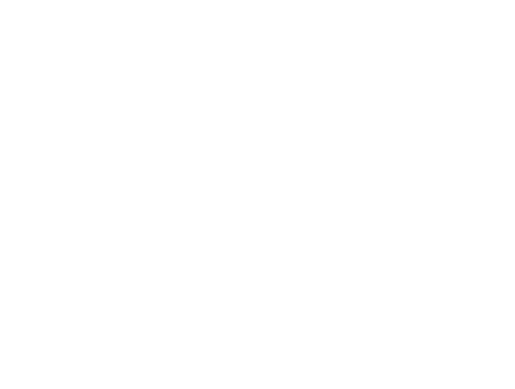

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   314


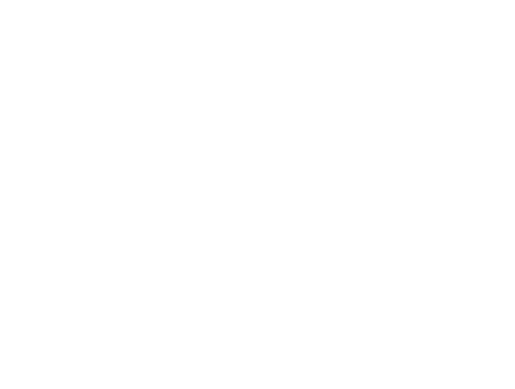

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   315


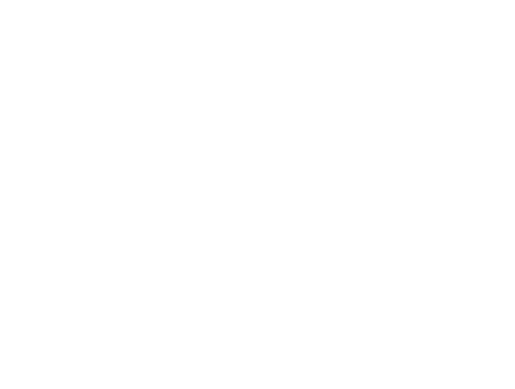

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   316


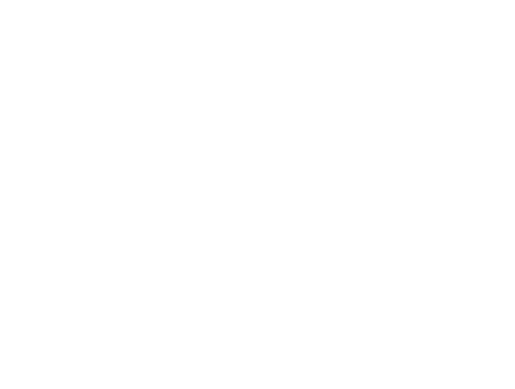

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   317


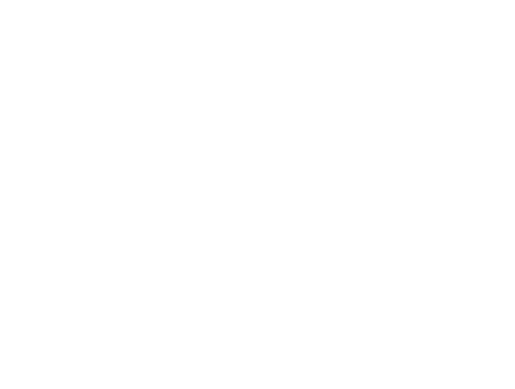

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   318


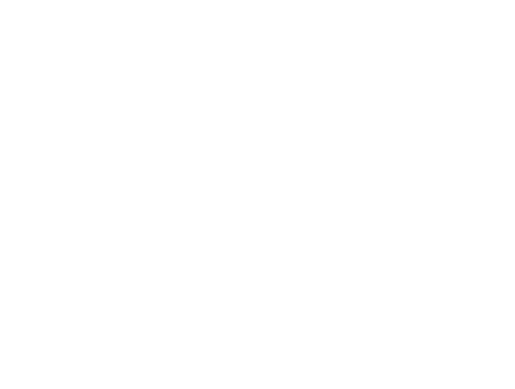

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   319


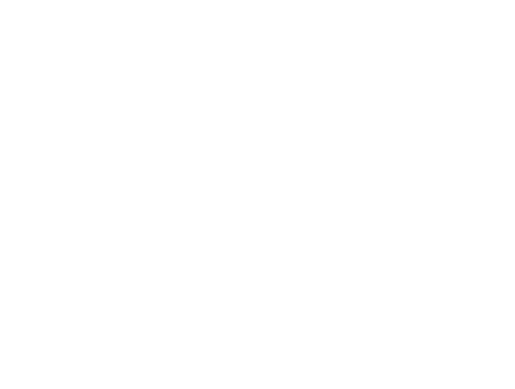

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   320


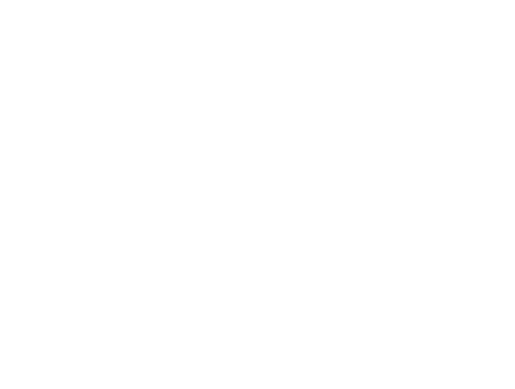

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   321


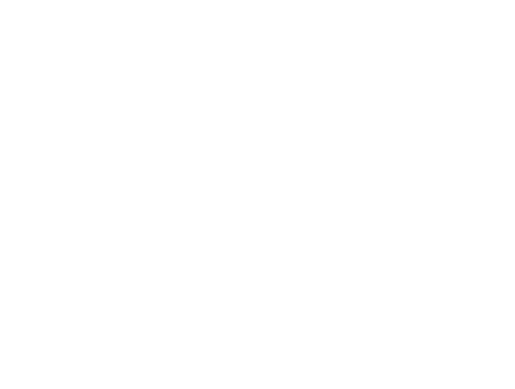

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   322


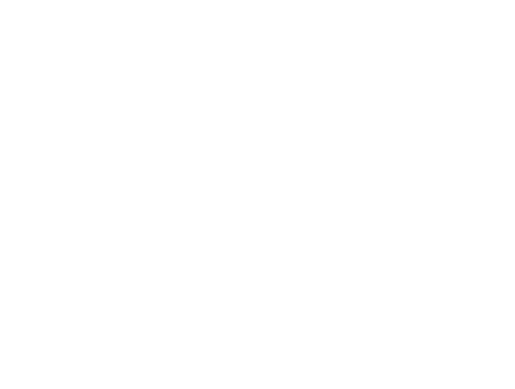

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   323


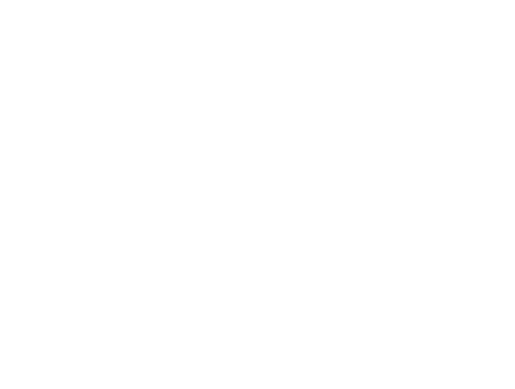

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   324


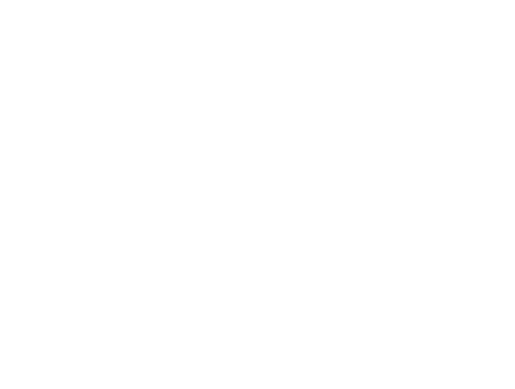

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   325


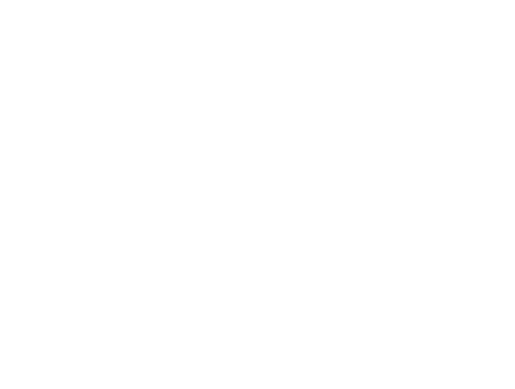

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   326


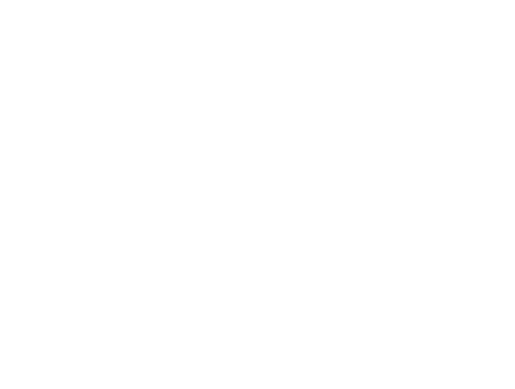

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   327


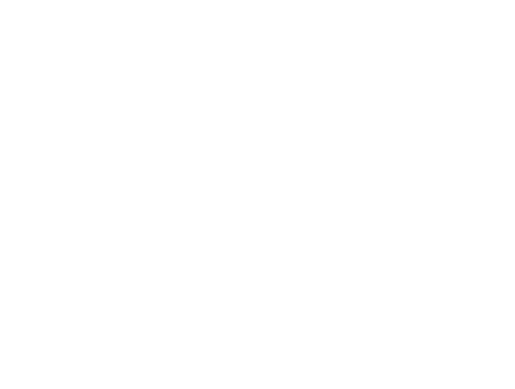

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   328


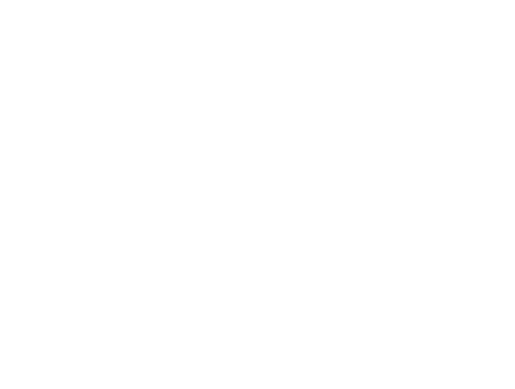

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   329


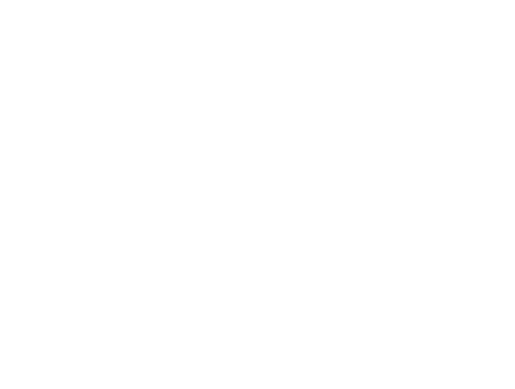

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   330


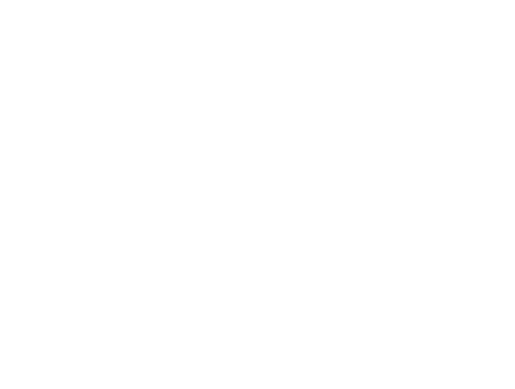

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   331


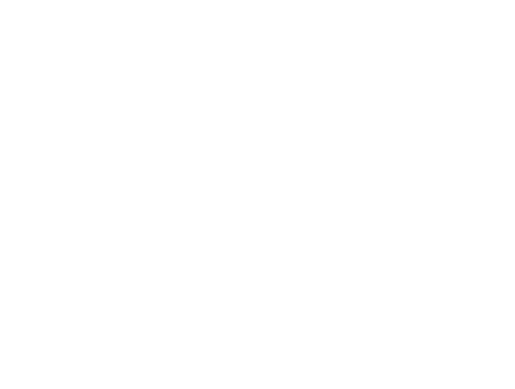

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   332


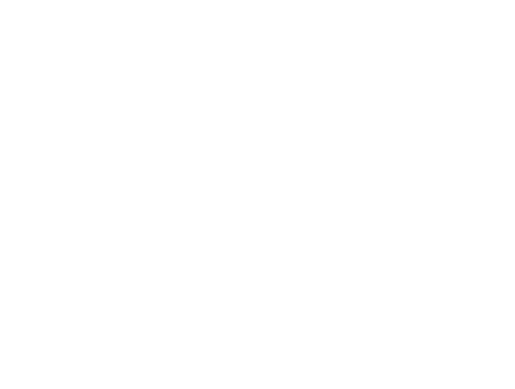

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   333


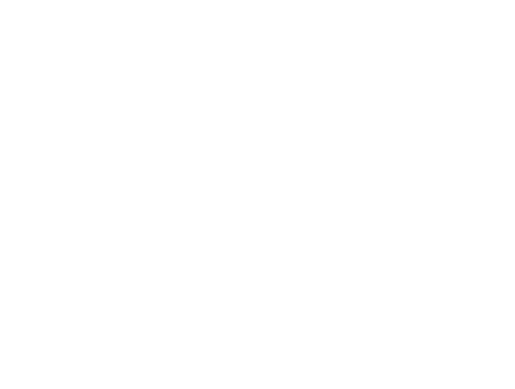

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   334


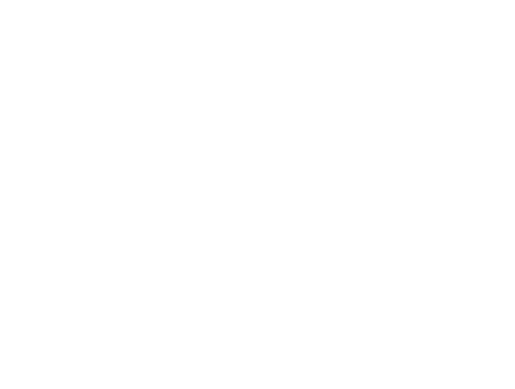

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   335


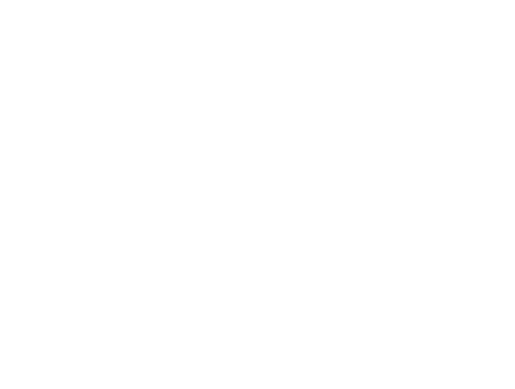

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   336


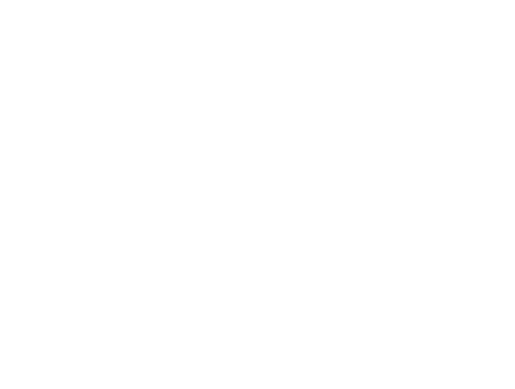

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   337


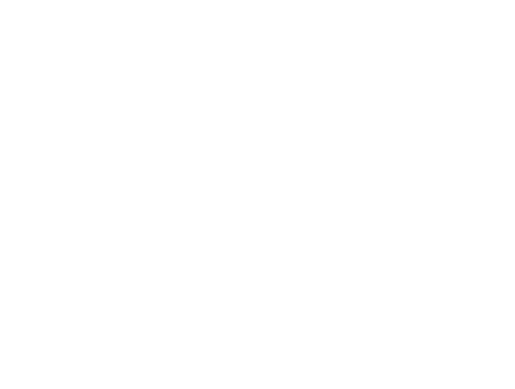

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   338


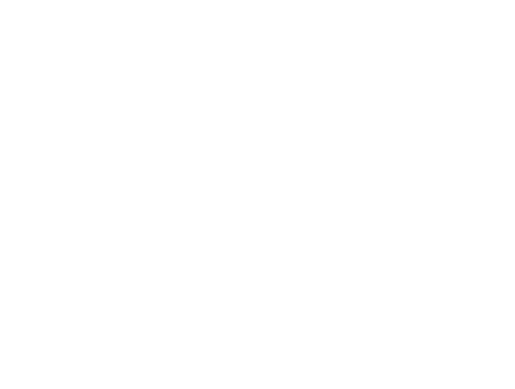

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   339


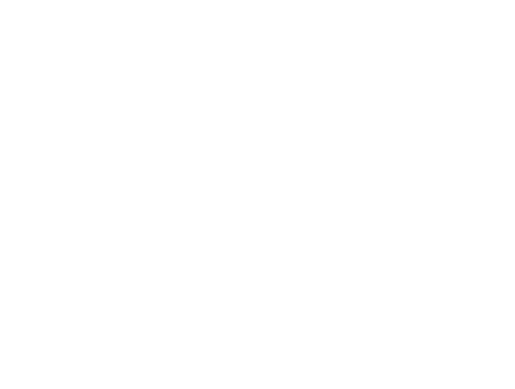

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   340


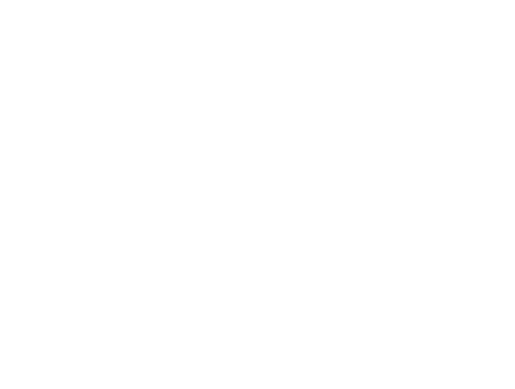

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   341


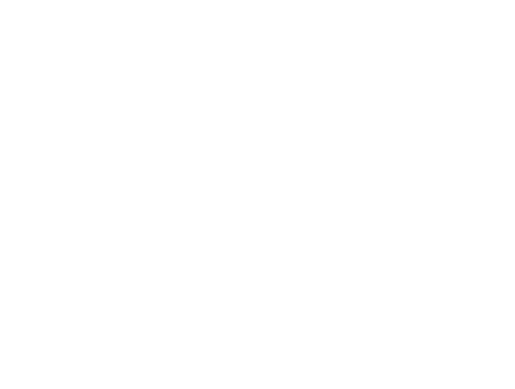

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   342


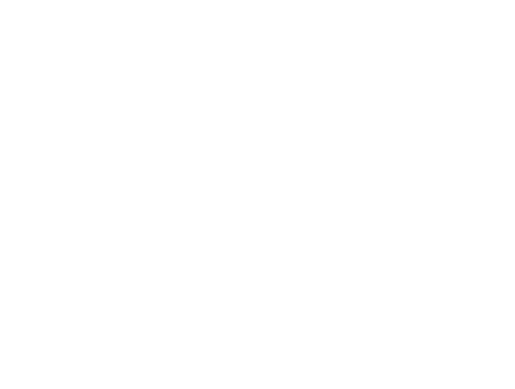

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   343


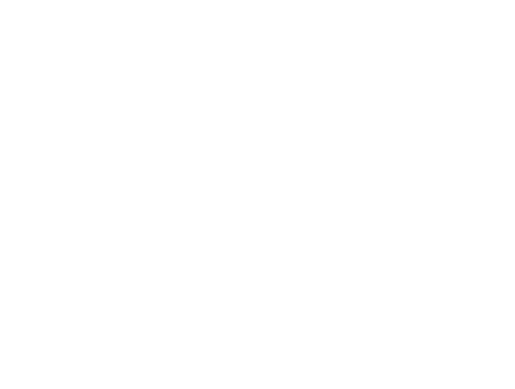

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   344


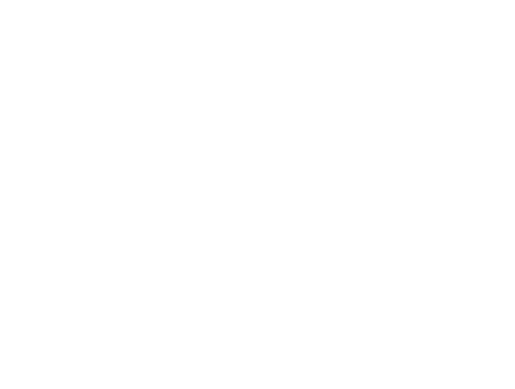

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   345


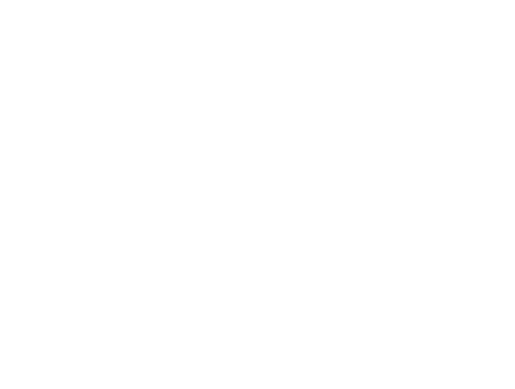

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   346


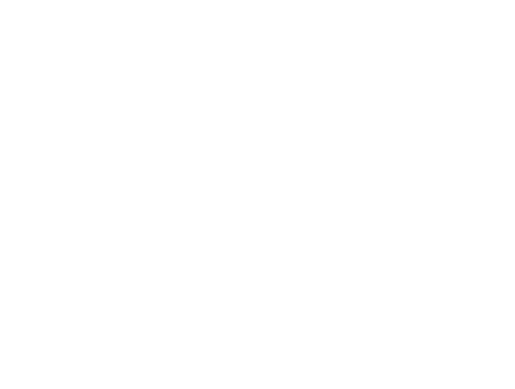

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   347


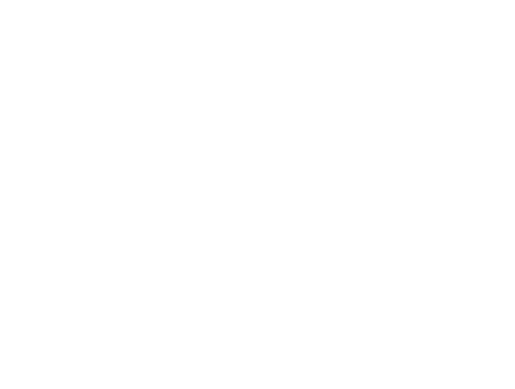

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   348


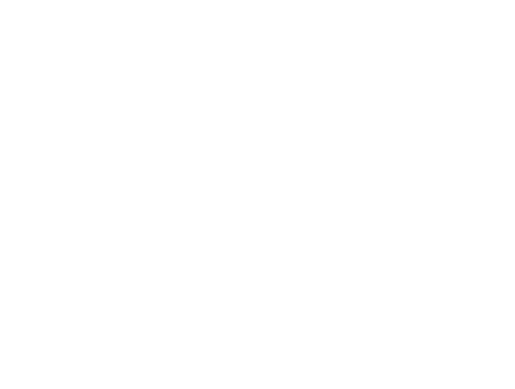

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   349


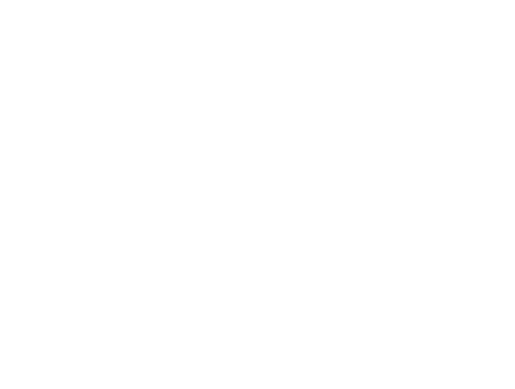

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   350


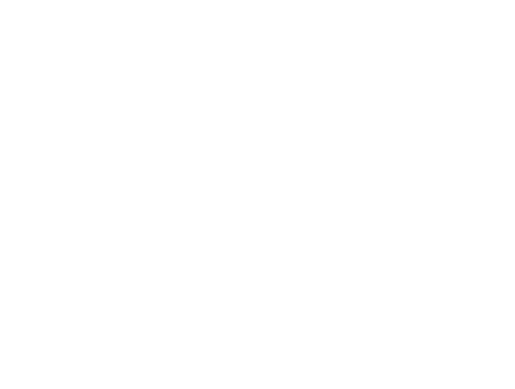

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   351


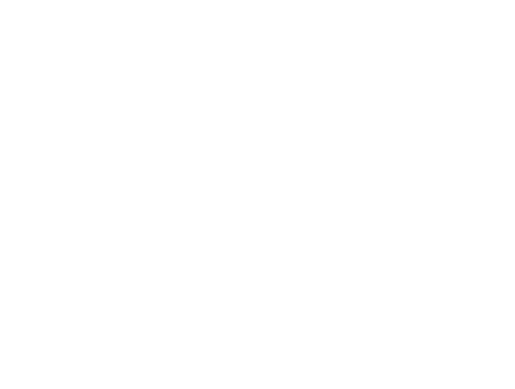

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   352


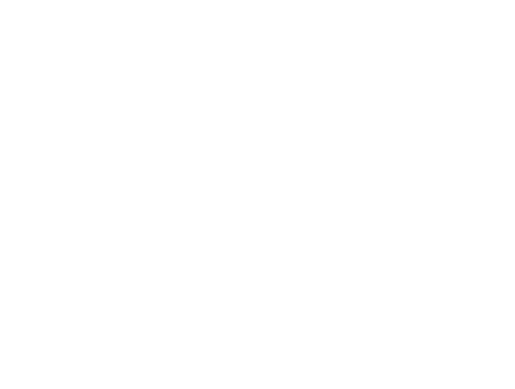

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   353


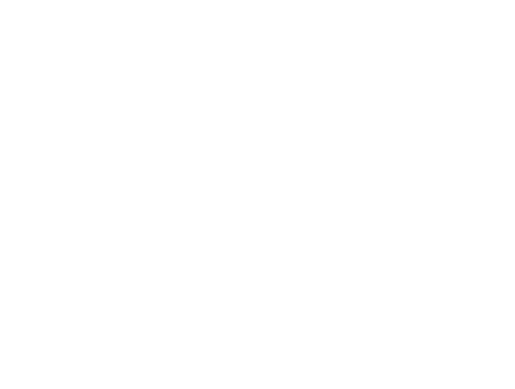

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   354


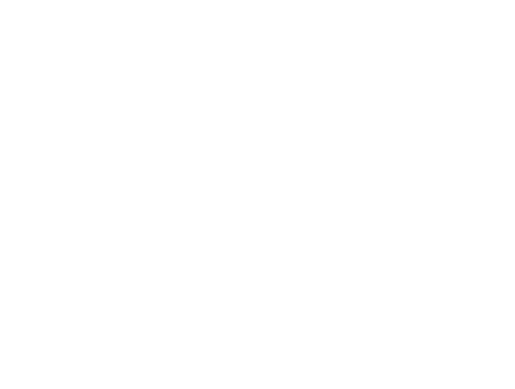

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   355


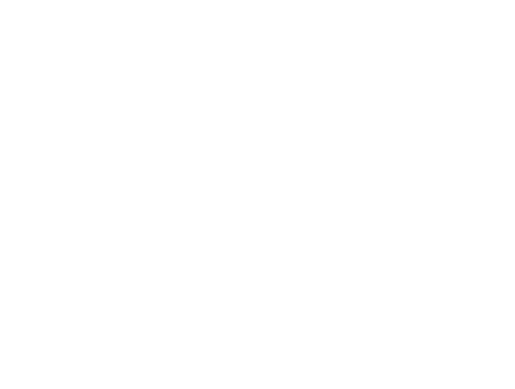

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   356


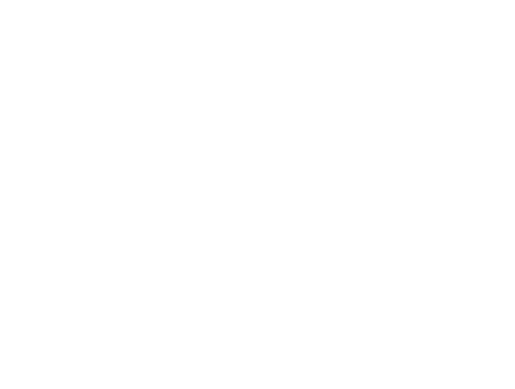

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   357


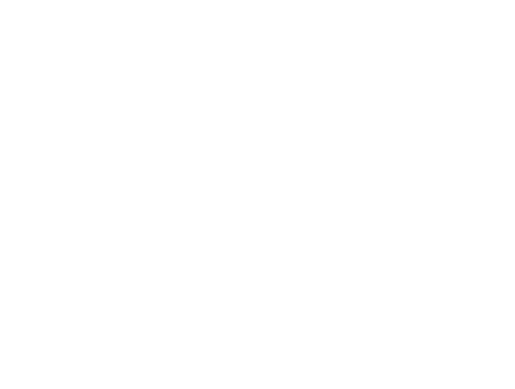

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   358


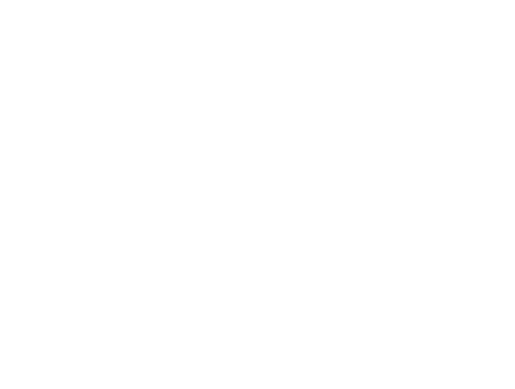

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   359


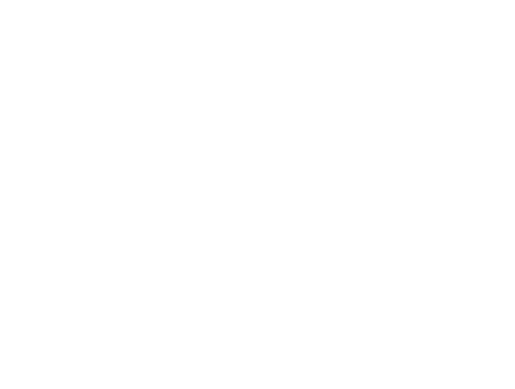

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   360


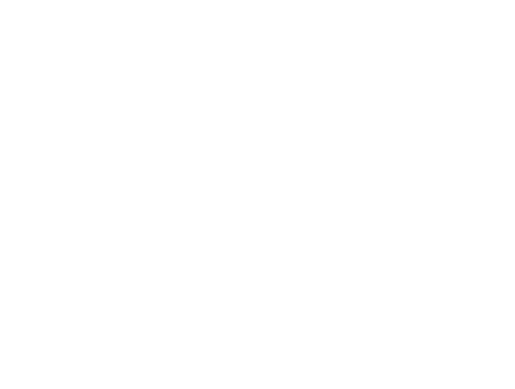

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   361


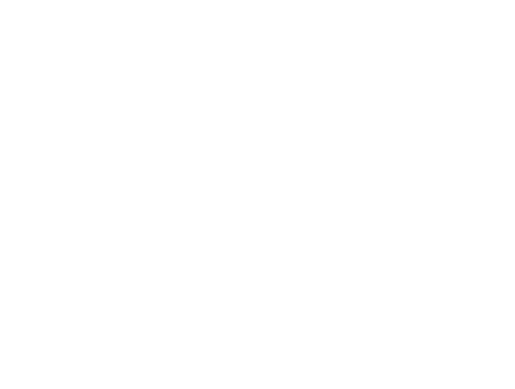

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   362


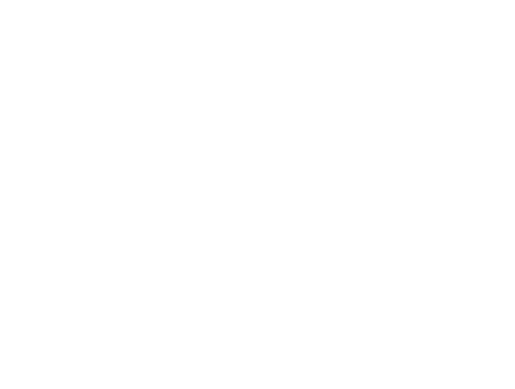

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   363


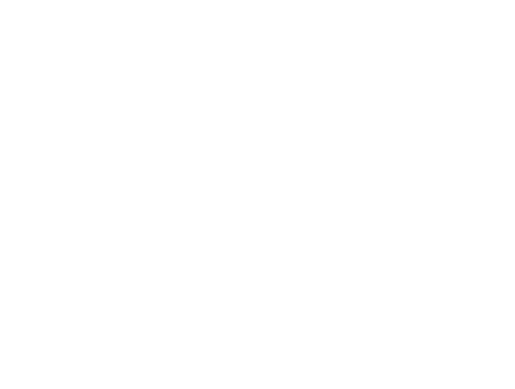

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   364


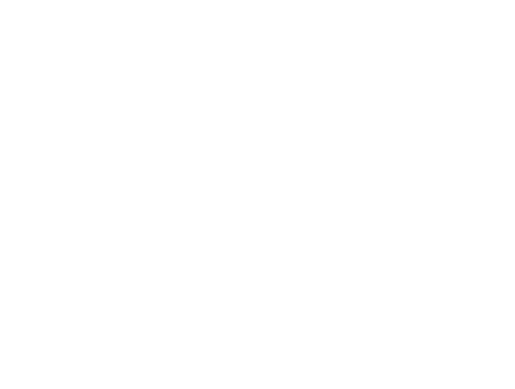

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   365


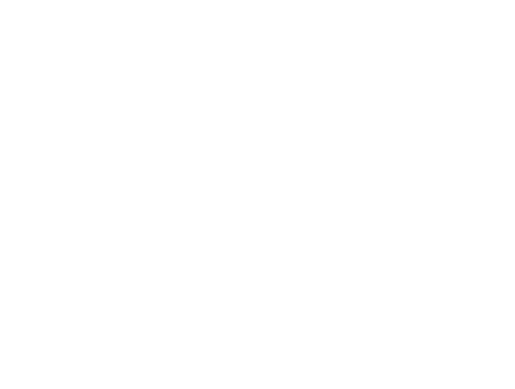

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   366


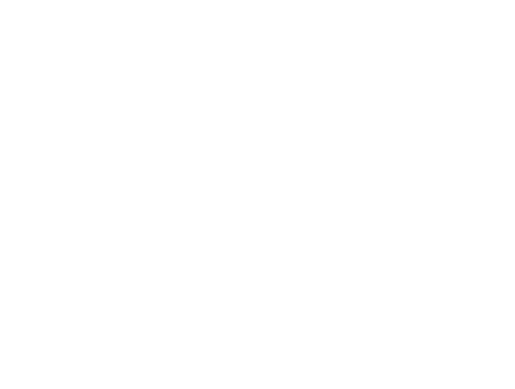

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   367


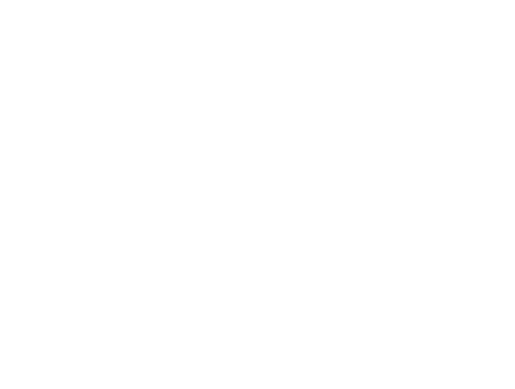

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   368


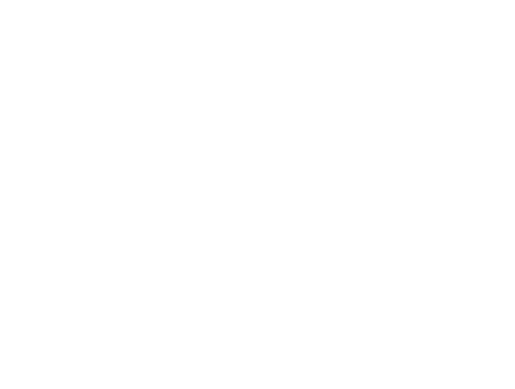

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   369


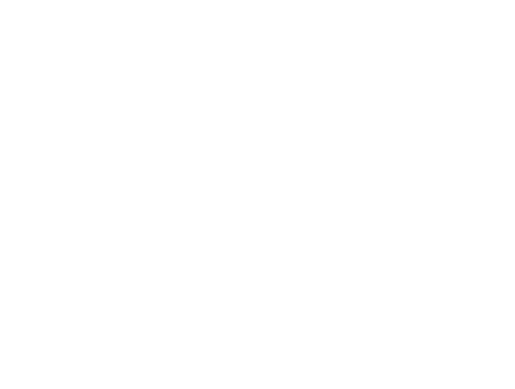

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   370


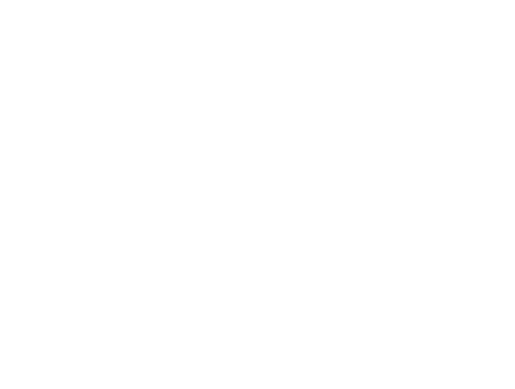

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   371


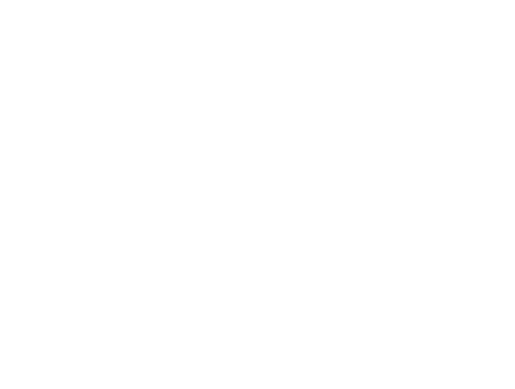

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   372


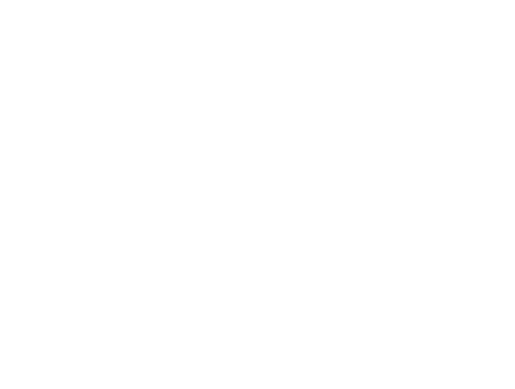

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   373


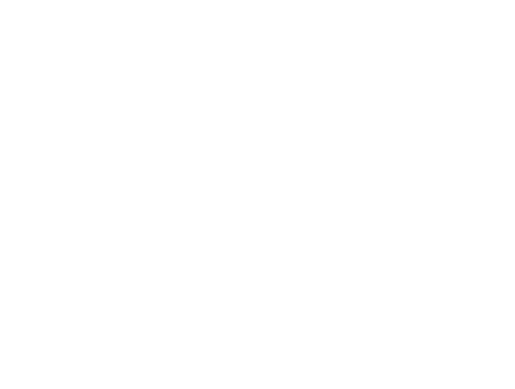

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   374


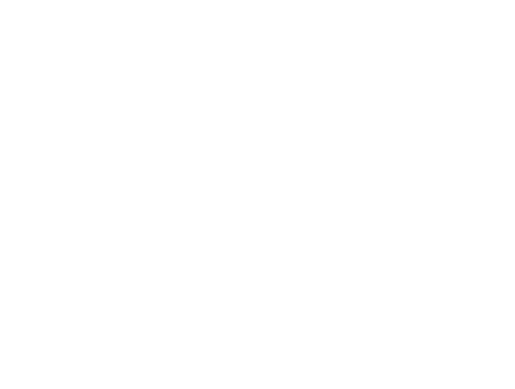

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   375


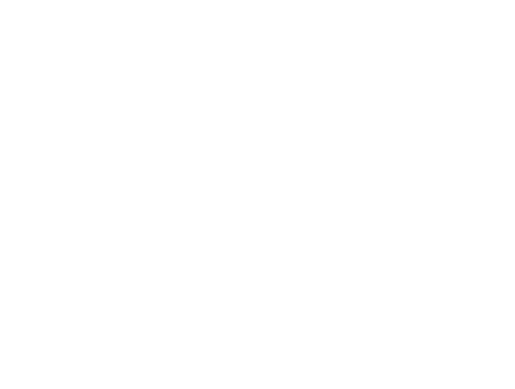

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   376


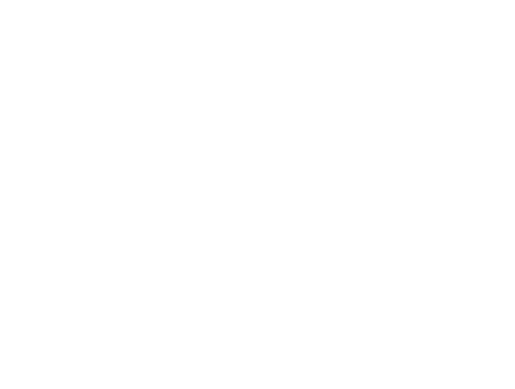

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   377


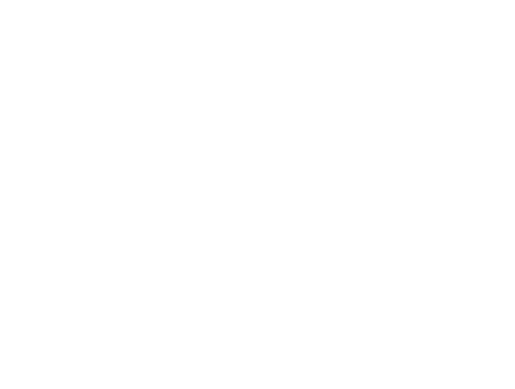

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   378


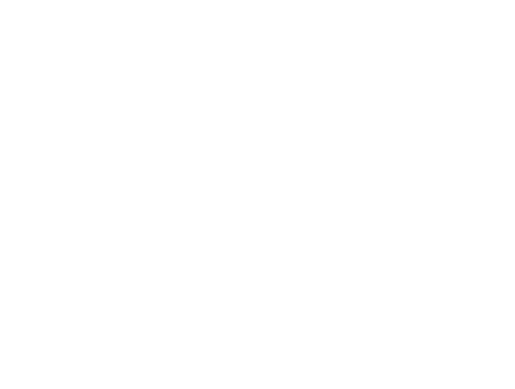

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   379


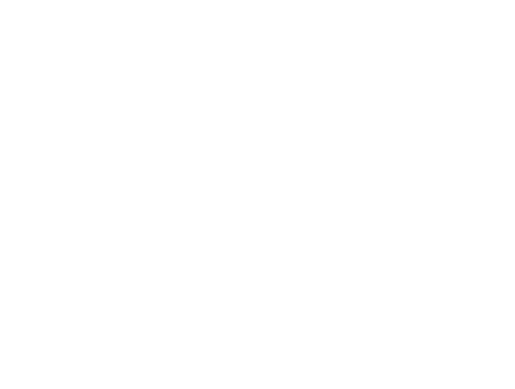

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   380


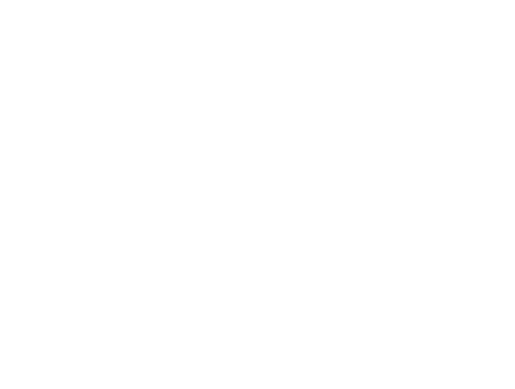

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   381


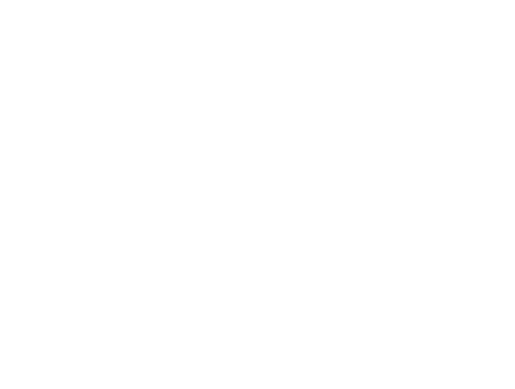

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   382


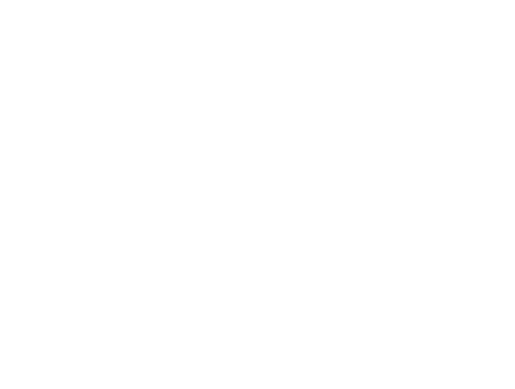

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   383


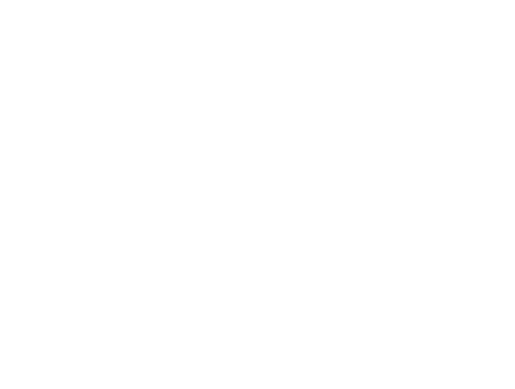

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   384


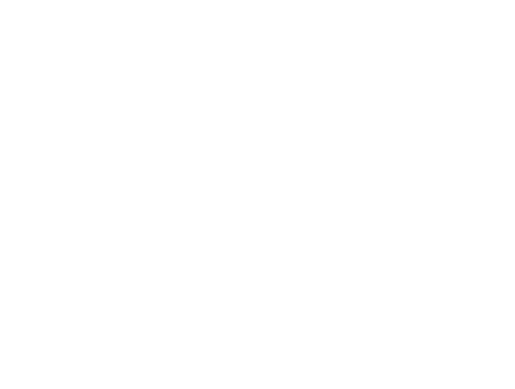

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   385


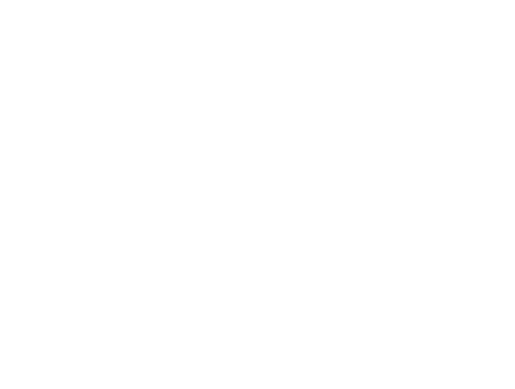

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   386


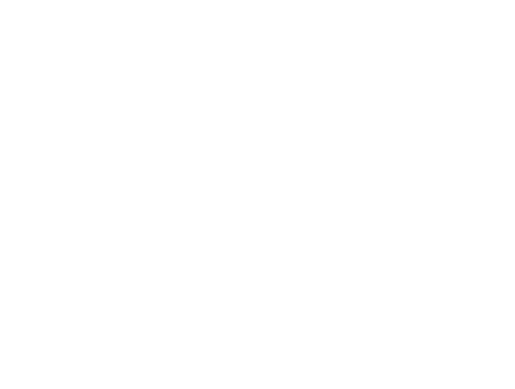

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   387


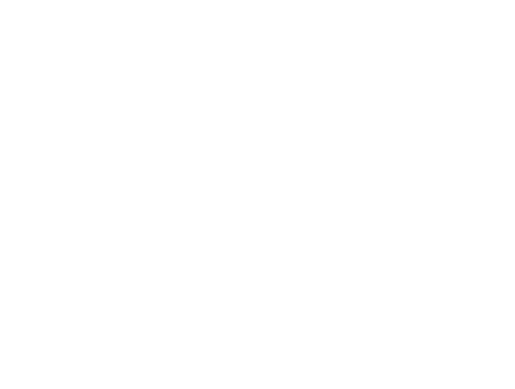

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   388


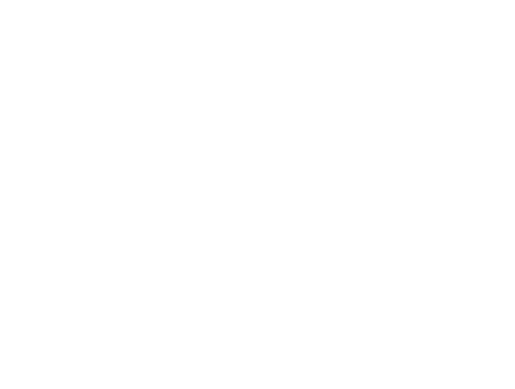

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   389


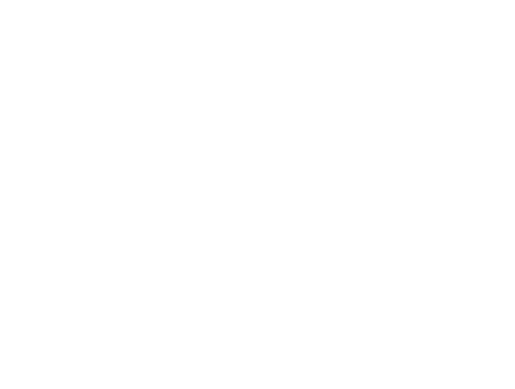

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   390


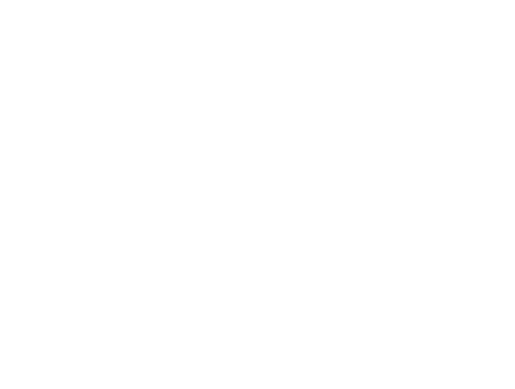

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   391


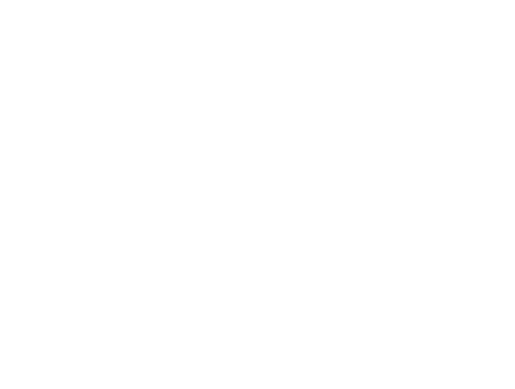

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   392


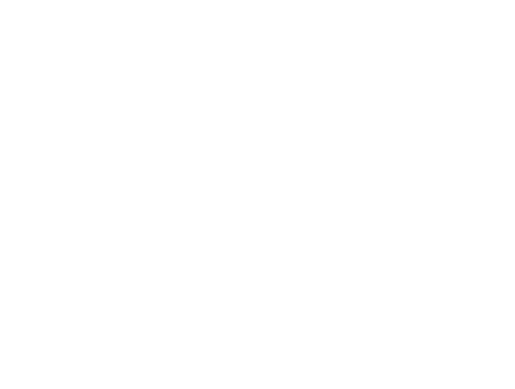

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   393


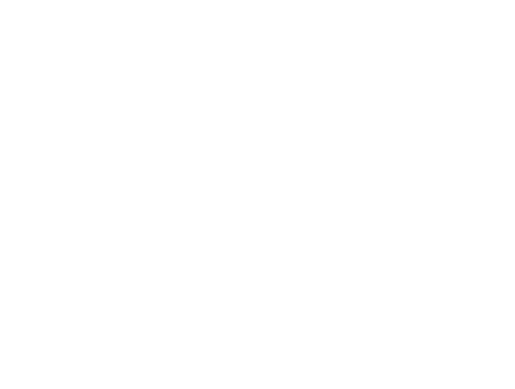

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   394


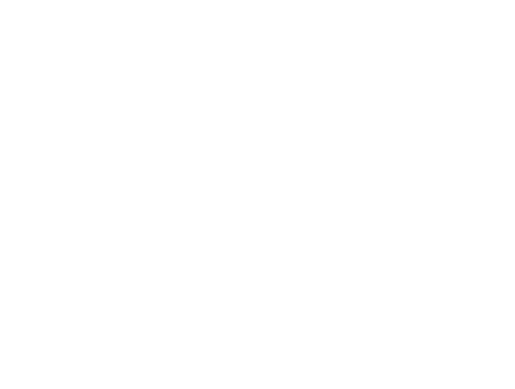

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   395


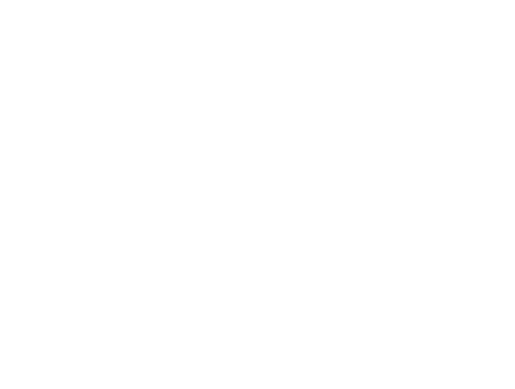

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   396


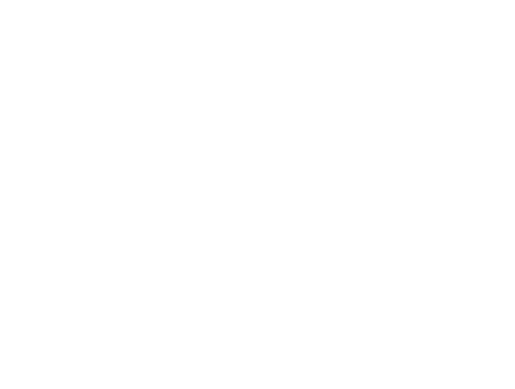

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   397


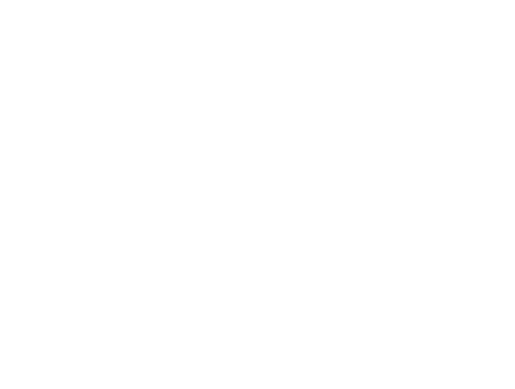

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   398


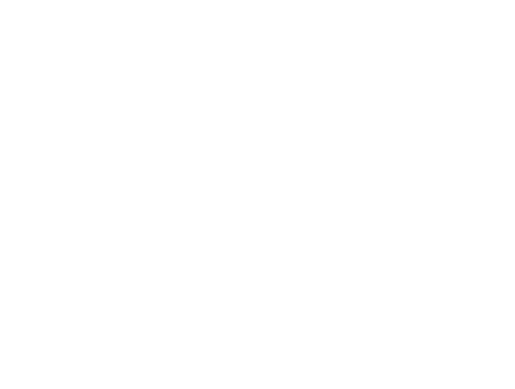

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   399


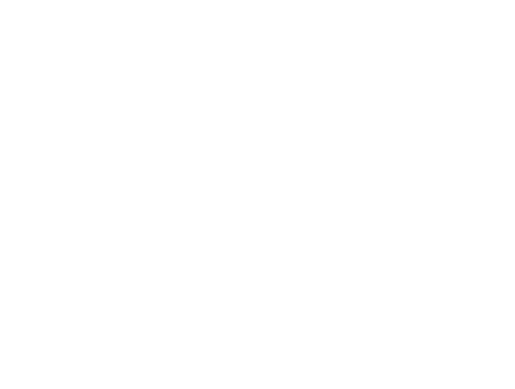

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   400


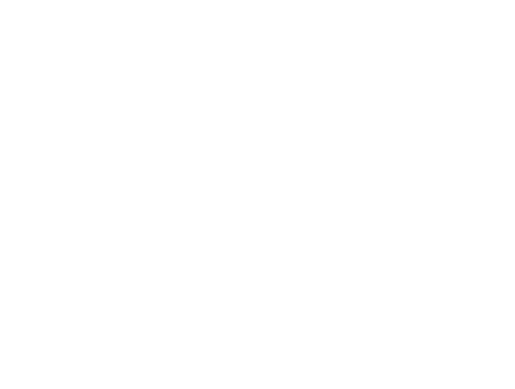

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   401


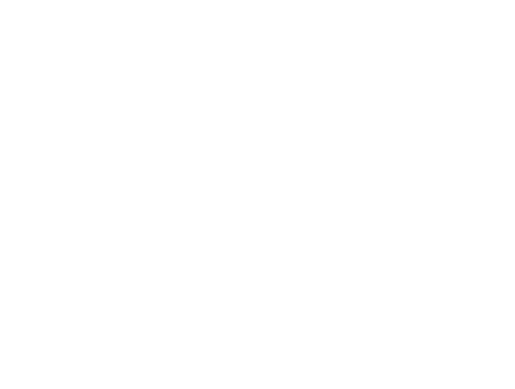

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   402


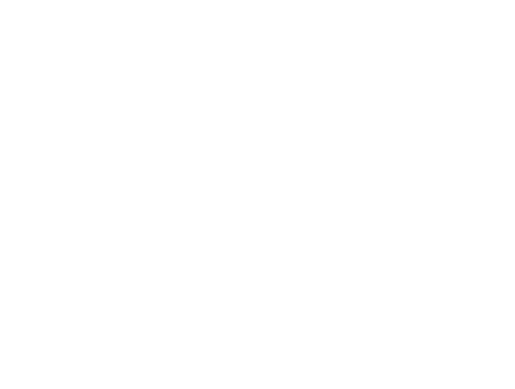

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   403


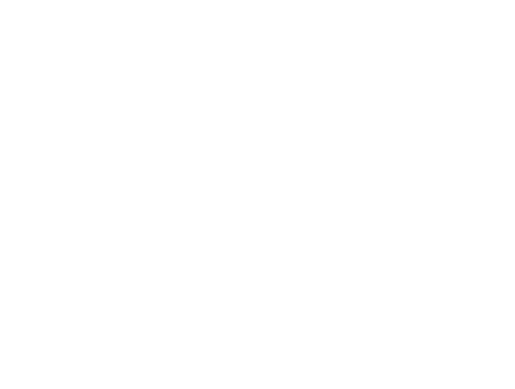

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   404


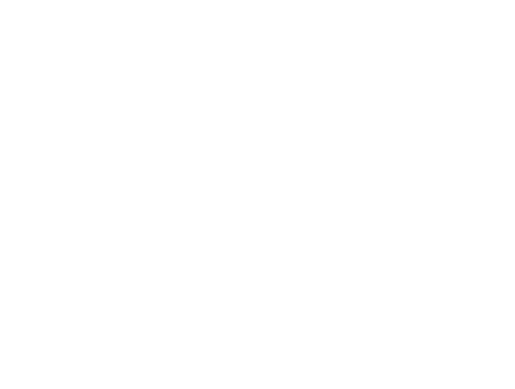

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   405


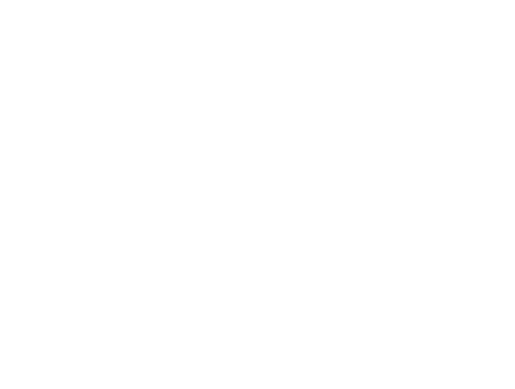

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   406


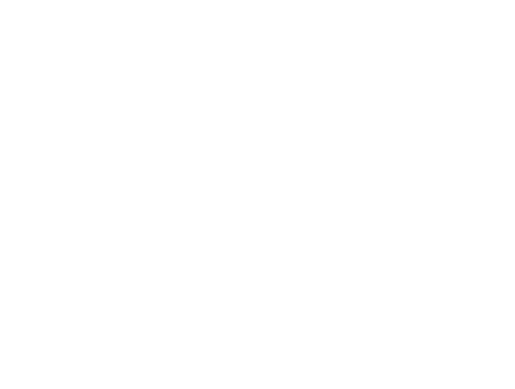

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   407


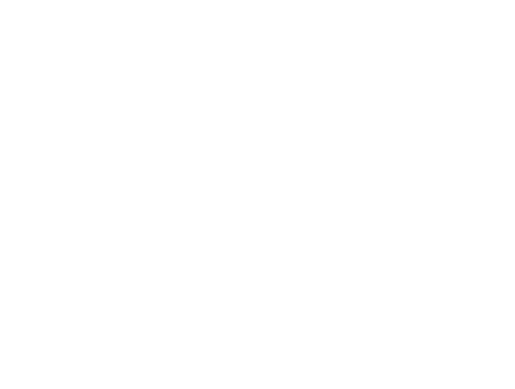

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   408


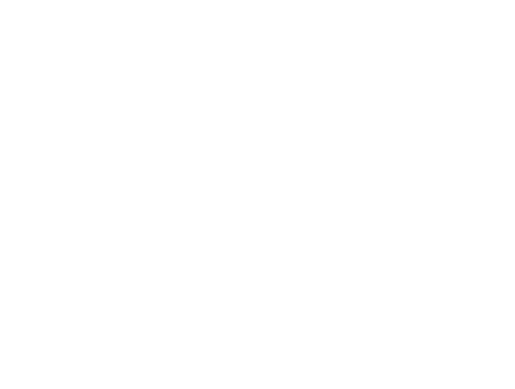

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   409


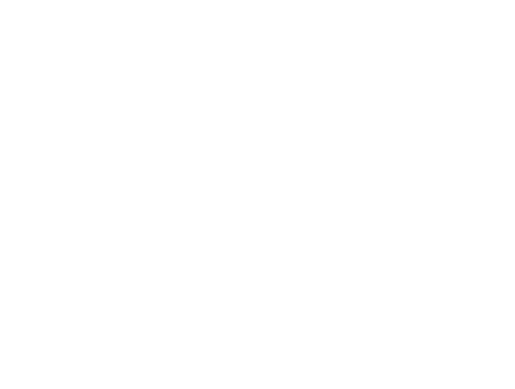

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   410


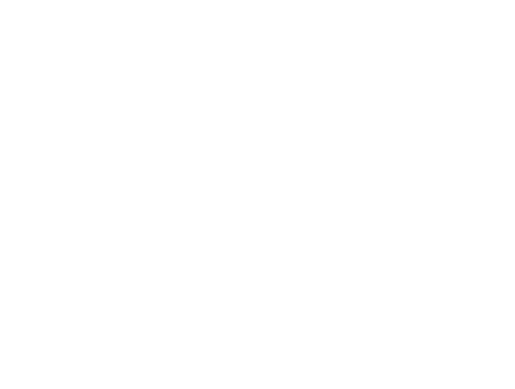

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   411


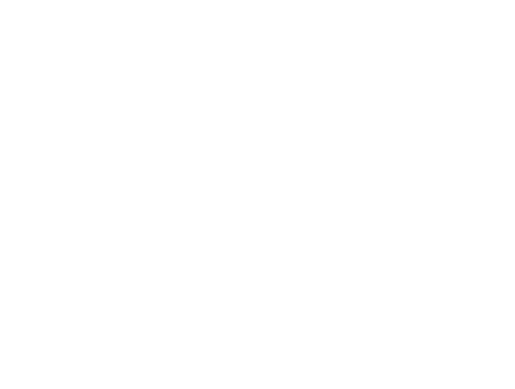

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   412


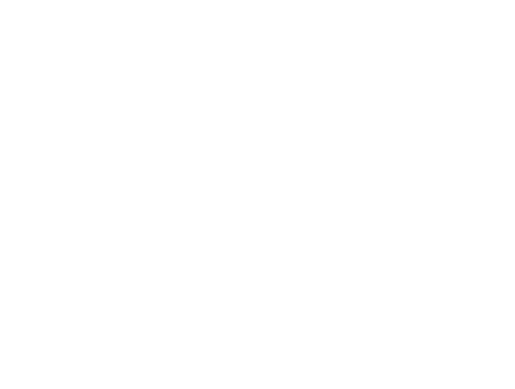

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   413


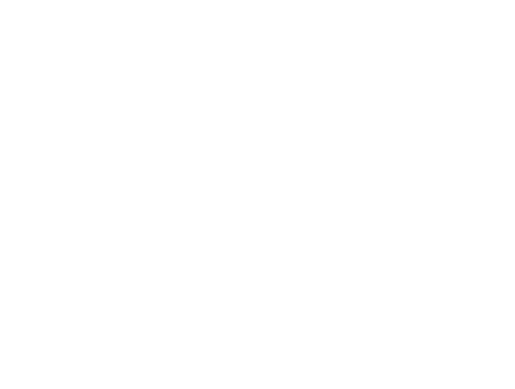

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   414


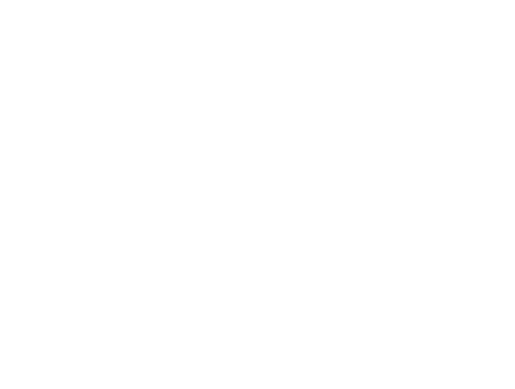

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   415


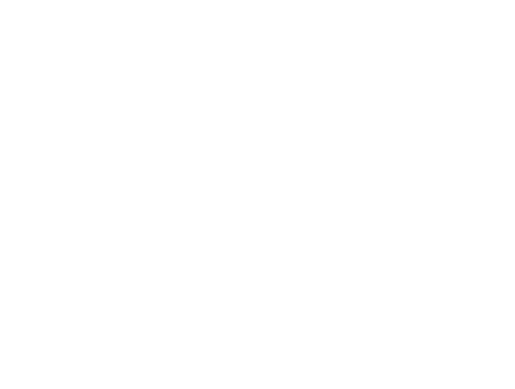

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   416


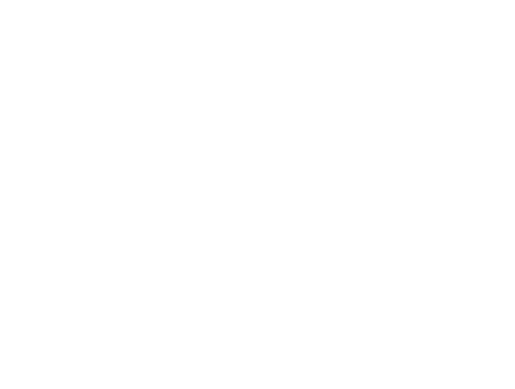

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   417


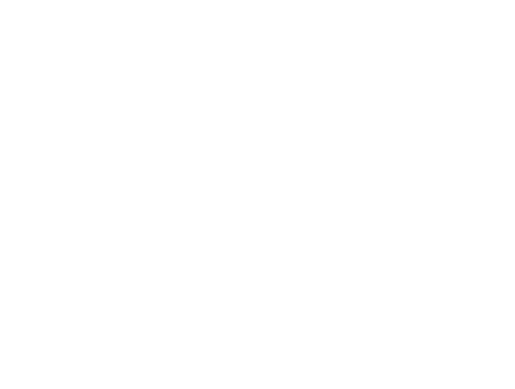

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   418


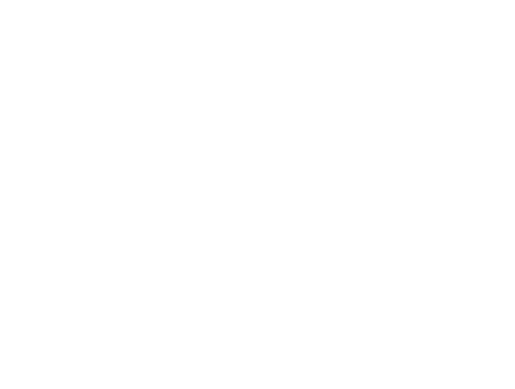

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   419


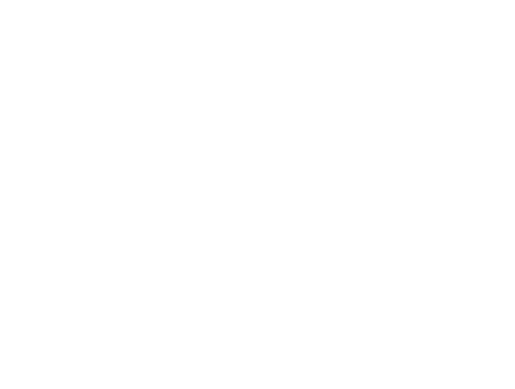

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   420


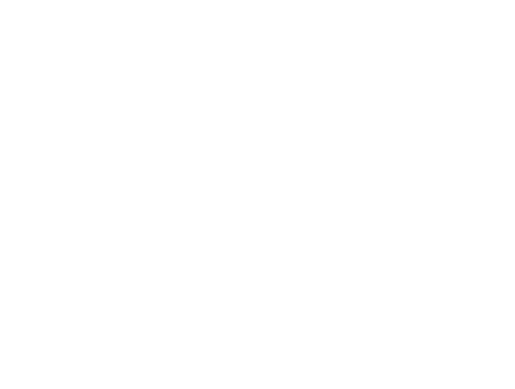

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   421


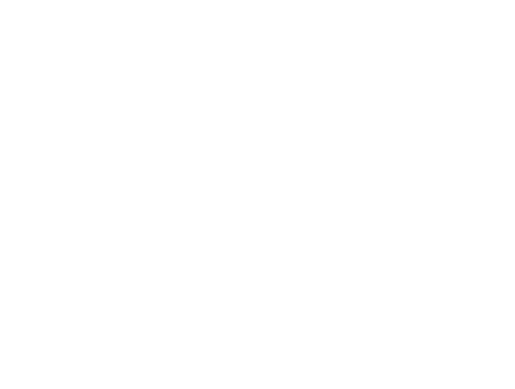

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   422


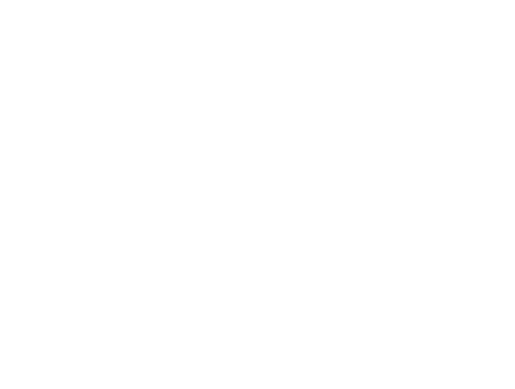

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   423


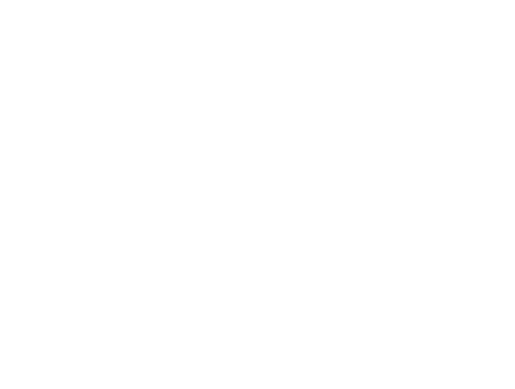

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   424


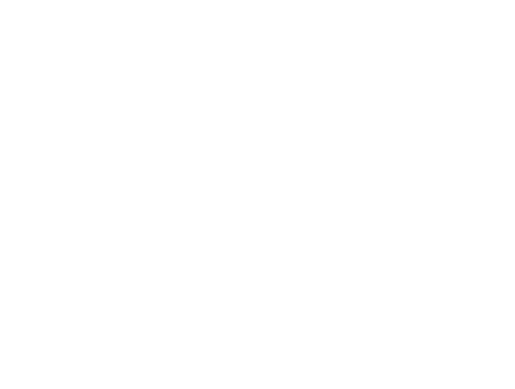

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   425


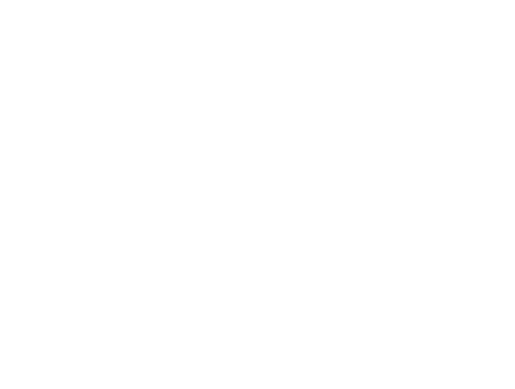

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   426


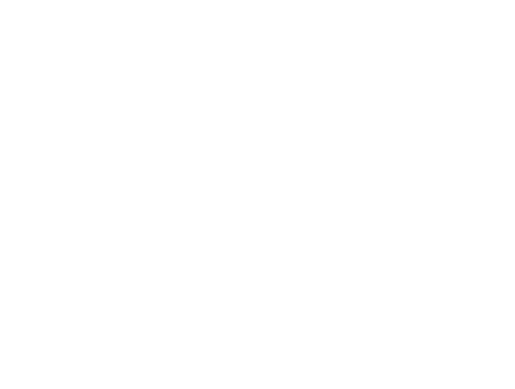

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   427


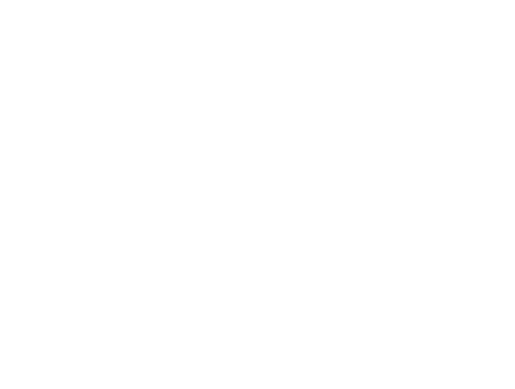

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   428


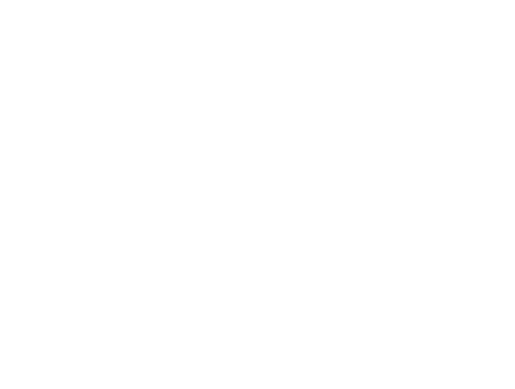

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   429


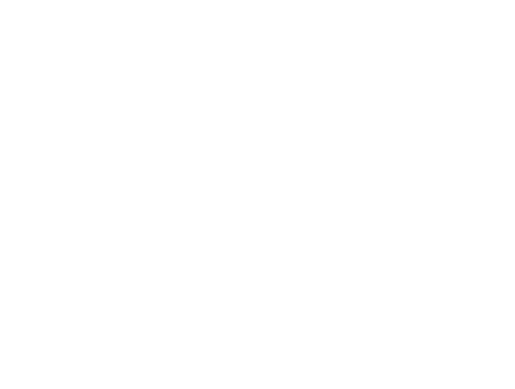

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   430


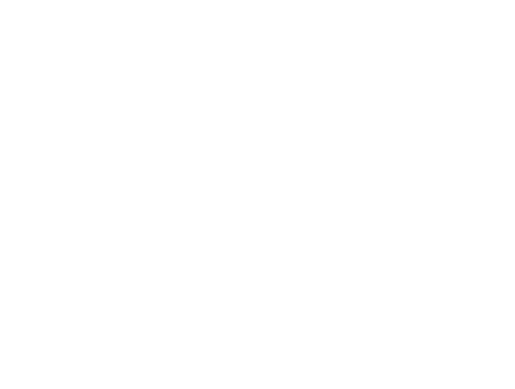

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   431


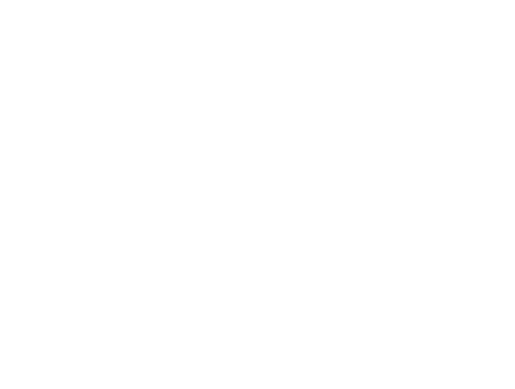

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


**********   432


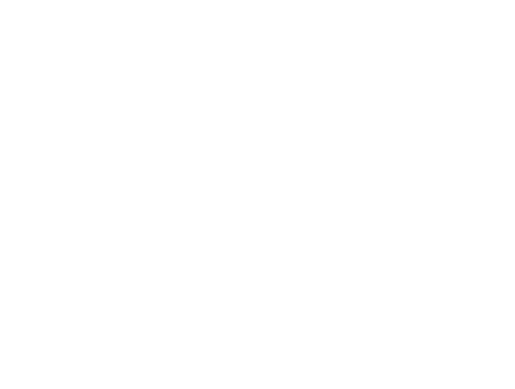

You are passing both `text` and `images` to `PaliGemmaProcessor`. The processor expects special image tokens in the text, as many tokens as there are images per each text. It is recommended to add `<image>` tokens in the very beginning of your text and `<bos>` token after that. For this call, we will infer how many images each text has and add special tokens.


KeyboardInterrupt: 

In [63]:
import cv2
import matplotlib.pyplot as plt

# Open the video
cap = cv2.VideoCapture('test_w.mp4')
review = ""
prompt = "Describe the image."
i = 0


# Get video properties to save the output video with the same settings
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Create VideoWriter object to save the output video
out = cv2.VideoWriter('output_video.avi', cv2.VideoWriter_fourcc(*'XVID'), fps, (frame_width, frame_height))
frame_i = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Convert frame to RGB (OpenCV uses BGR)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    if frame_i:

        
        #image_file = test_ds[99]["image"]
        
        # # Convert to a PIL image if needed
        # if not isinstance(image_file, Image.Image):
        #     image_file = Image.open(image_file)
        
        # # Display the image using Matplotlib
        # plt.imshow(image_file)
        # plt.axis("off")  # Hide axes
        # plt.title("Image: test_ds[99]")
        # plt.show()
        #print(image_file)
        inputs = processor(frame_rgb, prompt, return_tensors="pt")
        output = model.generate(**inputs, max_new_tokens=20)
        #print(processor.decode(output[0], skip_special_tokens=True)[len(prompt):])
        res = processor.decode(output[0], skip_special_tokens=True)[len(prompt):]
        review += processor.decode(output[0], skip_special_tokens=True)[len(prompt):]
        #print(review)
    
        # Display the review on the frame using OpenCV
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(frame_rgb, res, (50, 50), font, 1, (0, 255, 0), 2, cv2.LINE_AA)
    
        # Save the frame with the overlay text
        out.write(frame_rgb)
        print("*"*10," ",i)
        i=i+1
    
    
        
        ## Display the frame using Matplotlib
        #plt.imshow(frame_rgb)
        plt.axis('off')  # Hide axes
        plt.pause(0.01)  # Brief pause to update the frame
    frame_i +=1



# Release the video capture object
cap.release()
plt.close()  # Close the plot window
